## Проект:  Модель прогнозирования стоимости жилья для агентства недвижимости

📌 Цель проекта:       
Разработать модель машинного обучения, которая предсказывает стоимость недвижимости, основываясь на различных характеристиках объектов. Это поможет агентству автоматизировать оценку стоимости жилья и улучшить принятие решений.

📋 Список признаков и их описание:

➔ 'propertyType' — тип объекта недвижимости;           
➔ 'street' — адрес объекта;          
➔ 'baths' — количество ванных комнат;            
➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);              
➔ 'fireplace' — наличие камина;           
➔ 'city' — город;         
➔ 'schools' — сведения о школах в районе;           
➔ 'sqft' — площадь в футах;          
➔ 'zipcode' — почтовый индекс;           
➔ 'beds' — количество спален;          
➔ 'state' — штат;          
➔ 'stories' — количество этажей;        
➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система        
мультилистинга);        
➔ 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать        

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
import re
import ast
import category_encoders as ce
from itertools import chain
from pandas import json_normalize

%matplotlib inline
sns.set(style="whitegrid")
plt.style.use("ggplot")


In [3]:
# Загрузка данных
df_1 = pd.read_csv('data.csv')
df = df_1.copy()
print("Форма датасета:", df.shape)
display(df.head(3))

Форма датасета: (377185, 18)


status private pool        propertyType             street    baths  \
0    Active          NaN  Single Family Home     240 Heather Ln      3.5   
1  for sale          NaN  single-family home  12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home  2005 Westridge Rd  2 Baths   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000

In [4]:
# Проверка типов данных и пропусков
print("\nИнформация о данных:")
df.info()


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes:

Все столбцы представлены категориальными данными. 
Предстоит большая работа над преобразованием их в числовые.

Также много пропущенных значений, но сначала проведем разведовательный анализ данных, а по окончанию же посмотрим как быть  с пропусками, может их меньше станет. 

In [5]:
# Описательная статистика
print("\nОписательная статистика:")
display(df.describe())


Описательная статистика:


status private pool        propertyType                 street  \
count     337267         4181              342452                 377183   
unique       159            1                1280                 337076   
top     for sale          Yes  single-family home  Address Not Disclosed   
freq      156104         4181               92206                    672   

          baths                                          homeFacts fireplace  \
count    270847                                             377185    103115   
unique      229                                             321009      1653   
top     2 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...       yes   
freq      52466                                               7174     50356   

           city                                            schools    sqft  \
count    377151                                             377185  336608   
unique     2026                                             297365   25405   
top     Houston  [{'rating': [], 'data': {'Distance': [], 'Grad...       0   
freq      24442                                               4204   11854   

       zipcode    beds   state stories   mls-id PrivatePool   MlsId    target  
count   377185  285903  377185  226470    24942       40311  310305    374704  
unique    4549    1184      39     348    24907           2  232944     43939  
top      32137  3 Beds      FL     1.0  No MLS#         yes  NO MLS  $225,000  
freq      2141   53459  115449   67454        3       28793      24      1462

Первое, что бросается в глаза, это строка 'unique', очень много уникальных значений, что не есть хорошо.
Прийдется преображать много столбцов.

In [6]:
# Для начала уберем дубликаты. 
duplicate_rows = df[df.duplicated()]
print(f"Количество полных дубликатов: {duplicate_rows.shape[0]}")

# Удаление дубликатов
df = df.drop_duplicates()
print(f"Форма датасета после удаления дубликатов: {df.shape}")

Количество полных дубликатов: 50
Форма датасета после удаления дубликатов: (377135, 18)


### Начнем с преобразования столбцов.

### Начнем с целевого столбца df.target

Столбец df['target']  - обработаем его от лишних знаков и переведем в числовой формат.
Выявим медиану, чтобы примерно определить сегмент рынка недвижимости: средний, премиальный  и тд 

In [7]:
# Убираем знак доллара, запятую и все символы, кроме цифр
df['target'] = df['target'].replace({'\$': '', ',': '', '\+': ''}, regex=True)

# Преобразуем в числовое значение (float или int)
df['target'] = pd.to_numeric(df['target'], errors='coerce')


# Подсчитаем количество пропущенных значений
missing_count = df['target'].isna().sum()

# Подсчитаем процент пропущенных значений
total_count = df['target'].shape[0]
missing_percentage = round((missing_count / total_count) * 100, 2)
print(f"Процент пропущенных значений: {missing_percentage}%")

Процент пропущенных значений: 0.76%


In [8]:
# Посмотрим на статистику
df['target'].describe()

count    3.742570e+05
mean     6.454094e+05
std      1.842246e+06
min      1.000000e+00
25%      1.879000e+05
50%      3.200000e+05
75%      5.845000e+05
max      1.950000e+08
Name: target, dtype: float64

Большое отклонение — есть выбросы .      
* Минимальная цена 1 (очень низкая)     
* 25% объектов дешевле ~188 тыс
* Медиана — 320 тысяч
* 75% объектов дешевле 584,5 тыс
* Максимум — очень крупный выброс 195 000 000



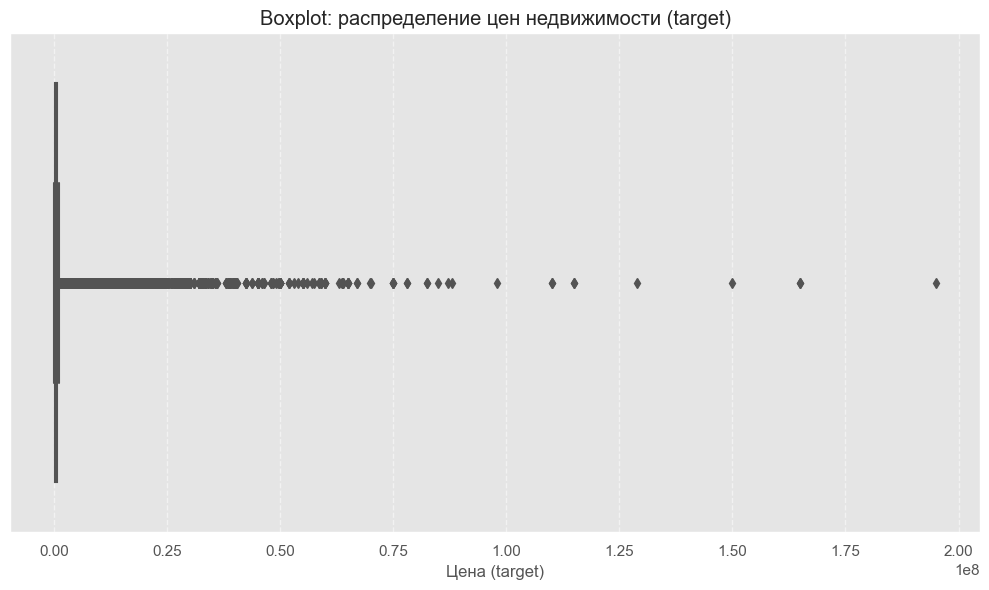

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['target'])

plt.title('Boxplot: распределение цен недвижимости (target)')
plt.xlabel('Цена (target)')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Выводы из boxplot по target:
* Большая часть цен сосредоточена в левом диапазоне (скорее всего, до 2–3 млн).   
* Много выбросов — цен выше 5–10 млн, некоторые даже под 200 млн.    
* Распределение сильно смещено вправо — это говорит о правосторонней асимметрии.    

In [10]:
# # Возьму порог в 60,000,000 - чтобы не резать явно, возможно до этого порога не выбросы. Потом рассужу.
df = df[~(df['target'] >= 60_000_000)]


Чтобы выбрать порог для фильтрации самых дешёвых квартир (или домов), надо учитывать цель анализа и баланс между:

Удалением слишком дешёвых объектов, которые могут быть выбросами или очень плохим жильём, и

Сохранением репрезентативности данных, чтобы не потерять важные сегменты рынка.

Порог (USD)	Описание	Что удаляет    
~10,000	Очень низкий порог	Только явные выбросы      
~50,000	Низкий порог	Убирает дешёвые и проблемные       
~185,000	25-й процентиль из твоих данных	Убирает нижние 25% по цене      
~300,000	Ближе к медиане	Убирает половину нижних объектов         

Уберем выбросы и мусор - поставим порог около 10,000

In [11]:
df1 = df[df['target'] <= 10000]
print(f"Количество строк до фильтрации: {df1.shape[0]}")

Количество строк до фильтрации: 6186


In [12]:
# Фильтруем DataFrame и присваиваем обратно в df
df = df[df['target'] >= 10000]


In [13]:
# Подсчитаем количество пропущенных значений
missing_count = df['target'].isna().sum()
print(f"Количество пропущенных значений после заполнения: {missing_count}")

Количество пропущенных значений после заполнения: 0


Пока оставлю 

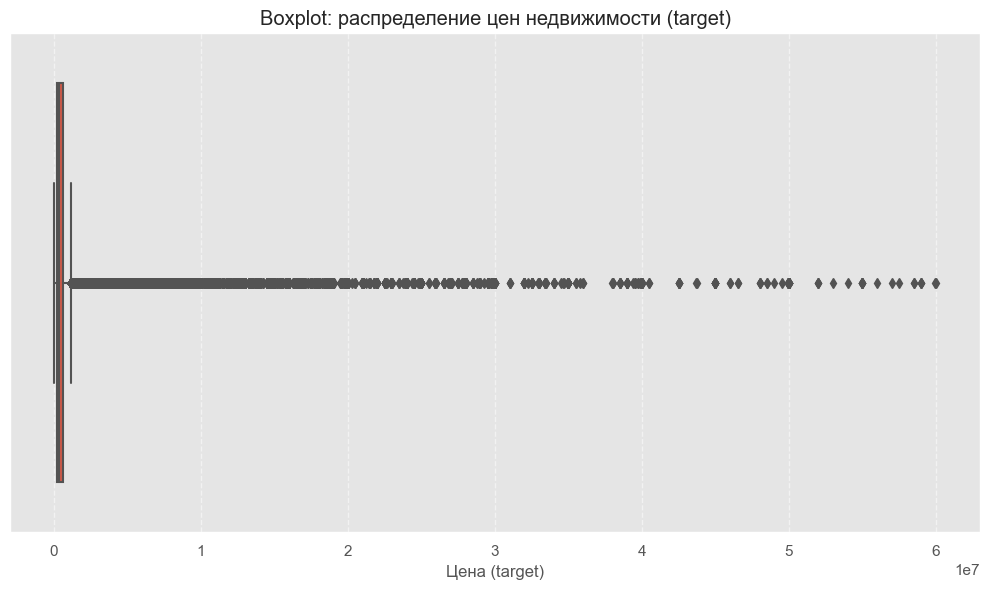

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['target'])

plt.title('Boxplot: распределение цен недвижимости (target)')
plt.xlabel('Цена (target)')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Все равно сильно искажены.   
Больше не буду удалять, потому как столбцы нужно предобаботать и по ходу дела буду резать данные.
В конце посмотрим что осталось и дочистим. 

### Переходим к столбцу df.zipcode

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368572 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        329479 non-null  object 
 1   private pool  4148 non-null    object 
 2   propertyType  334886 non-null  object 
 3   street        368570 non-null  object 
 4   baths         267517 non-null  object 
 5   homeFacts     368572 non-null  object 
 6   fireplace     102090 non-null  object 
 7   city          368543 non-null  object 
 8   schools       368572 non-null  object 
 9   sqft          331208 non-null  object 
 10  zipcode       368572 non-null  object 
 11  beds          281927 non-null  object 
 12  state         368572 non-null  object 
 13  stories       223908 non-null  object 
 14  mls-id        24873 non-null   object 
 15  PrivatePool   39985 non-null   object 
 16  MlsId         305321 non-null  object 
 17  target        368572 non-null  float64
dtypes: f

У нас столбец типа - object, необходимо привести к числовому формату

In [16]:
# Количество пропущенных значений
missing_count = (df.zipcode.isna().sum() / len(df)) * 100
print(f"Пропущенных значений в 'sqft': {round(missing_count, 2)}%")

Пропущенных значений в 'sqft': 0.0%


In [17]:
# Удаляем любые не‑цифровые символы (если они есть) и получаем числа
df['zipcode'] = df['zipcode'].str.extract(r'(\d+)').astype('Int64')

In [18]:
df.zipcode.describe()

count     368571
unique      4255
top        32137
freq        2138
Name: zipcode, dtype: int64

Приведены к единому формату, пропусков нет. 
Этот признак очень важен, поможет восстанавливать пропущенные значения в других столбцах. 

### Переходим к столбцам df['private pool'] и df['PrivatePool']

*Проблема состоит в том, что у нас два столбца означают один и тот же объект - бассейн: 
* df['private pool']
* df['PrivatePool']

Проверим какие уникальные значения есть в каждом из них 

In [19]:
df['private pool'].unique()

array([nan, 'Yes'], dtype=object)

In [20]:
df['PrivatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

In [21]:
# Приводим оба столбца к нижнему регистру
df['private pool'] = df['private pool'].str.lower()
df['PrivatePool'] = df['PrivatePool'].str.lower()

При внимательном знакомстве с датасетом, заметила, что не всега информация правильно дублируется.       
в одном столбце можт к примеру быть значение NAN, а в другом значеник 'yes' 
Необходимо объединить в один столбец значения, так, чтобы пропущенные значения заменялась на 'yes', в случае, если последнее имеется в строке. 

In [22]:
# Объединяем в новый столбец 'private_pool'
df['private_pool_clean'] = df[['private pool', 'PrivatePool']].apply(
    lambda row: 'yes' if 'yes' in row.values else np.nan, axis=1)

In [23]:
# Удаляем старые столбцы
df.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)

In [24]:
#Проверим как прошшло проебразование и удаление столбцов
df.private_pool_clean.describe()

count     44133
unique        1
top         yes
freq      44133
Name: private_pool_clean, dtype: object

In [25]:
print(f"Процент пропущенных значений в 'private_pool_clean': {df['private_pool_clean'].isna().sum() / len(df) * 100:.2f}%\n")

Процент пропущенных значений в 'private_pool_clean': 88.03%



Очень много пропущенных значений. 
Я несколько раз сюда возвращалась и пыталась восстановить через другие признаки.        
Но проблема в маленьком колиестве строк. Плюс отсутсвия закономерностей (только колонки - 'yes')   
Без категории 'no' -  в принципе сложно судить о влиянии цены на недвиимость. 
Поэтому удаляю столбец к сожалению. 

In [26]:
df = df.drop('private_pool_clean', axis=1)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368572 entries, 0 to 377184
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        329479 non-null  object 
 1   propertyType  334886 non-null  object 
 2   street        368570 non-null  object 
 3   baths         267517 non-null  object 
 4   homeFacts     368572 non-null  object 
 5   fireplace     102090 non-null  object 
 6   city          368543 non-null  object 
 7   schools       368572 non-null  object 
 8   sqft          331208 non-null  object 
 9   zipcode       368571 non-null  object 
 10  beds          281927 non-null  object 
 11  state         368572 non-null  object 
 12  stories       223908 non-null  object 
 13  mls-id        24873 non-null   object 
 14  MlsId         305321 non-null  object 
 15  target        368572 non-null  float64
dtypes: float64(1), object(15)
memory usage: 47.8+ MB


###  Переходим к столбцу df.sqft

У нас этот столбек типа object - замечаем, что у нас есть буквенная часть и числовая.    
Мы уберем слова, а оставим только числовые значения.     

In [28]:
# импортируем библиотеку re
def extract_sqft(value):
    if pd.isna(value):
        return np.nan
    # Найти только числа и запятые
    numbers_only = re.findall(r'[\d,]+', str(value))
    if numbers_only:
        # Удалить запятые и привести к целому числу
        cleaned = ''.join(numbers_only).replace(',', '')
        return int(cleaned)
    return np.nan

df['sqft'] = df['sqft'].apply(extract_sqft)

In [29]:
df.head(2)

status        propertyType             street    baths  \
0    Active  Single Family Home     240 Heather Ln      3.5   
1  for sale  single-family home  12911 E Heroy Ave  3 Baths   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   

             city                                            schools    sqft  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...  2900.0   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...  1947.0   

  zipcode    beds state stories mls-id      MlsId    target  
0   28387       4    NC     NaN    NaN     611019  418000.0  
1   99216  3 Beds    WA     2.0    NaN  201916904  310000.0

In [30]:
df.sqft.dtype
# Преобразовали столбец - идем дальше

dtype('float64')

In [31]:
# Количество пропущенных значений
missing_count = (df['sqft'].isna().sum() / len(df)) * 100

print(f"Пропущенных значений в 'sqft': {round(missing_count, 2)}%")

Пропущенных значений в 'sqft': 10.35%


Отлично. Приемлемое значение пропущенных.        
Восстановлю их через столбик df.beds - так как туда попали значения sqrt и acres.    
Если останутся пустые значения, заполню их по медиане, чтобы избежать выбросов. 

### Переходим к столбцу df.beds

In [32]:
# Проверяем какие и сколько уникальных значений у нас
print(f"Уникальных значений в 'beds': {df['beds'].unique()}")  
print(f"Кол-во уникальных значений в 'beds': {df['beds'].nunique()}") 

Уникальных значений в 'beds': ['4' '3 Beds' '5 Beds' ... '2.72 acres' '9,565 sqft' '8,479 sqft']
Кол-во уникальных значений в 'beds': 1127


In [33]:
df['beds'].value_counts(ascending=False)

3 Beds        52364
4 Beds        34938
3             31153
2 Beds        25865
4             19887
              ...  
3.8 acres         1
7,104 sqft        1
9,443 sqft        1
5.11 acres        1
8,479 sqft        1
Name: beds, Length: 1127, dtype: int64

Слишком много уникальных значений.
Сначала нужно очистить значения, которые действительно относятся к количеству спален, а потом уже отдельно рассматривать все остатки типа acres, sqft, и прочие шумы.

In [34]:
# 1 acre = 43,560 sqft
ACRE_TO_SQFT = 43560

def extract_beds_strict(value):
    """Извлекает количество спален, игнорируя площади"""
    if pd.isna(value):
        return np.nan

    value = str(value).lower().strip()

    # Пропускаем, если это площадь
    if 'sqft' in value or 'acre' in value:
        return np.nan

    match = re.search(r'\d+(\.\d+)?', value)
    if match:
        return int(float(match.group()))
    
    return np.nan

def extract_sqft_from_beds(value):
    """Извлекает площади из значений, где вместо спален указаны sqft или acres"""
    if pd.isna(value):
        return np.nan

    value = str(value).lower().strip()

    # Обработка sqft
    sqft_match = re.search(r'([\d,.]+)\s*sqft', value)
    if sqft_match:
        sqft_str = sqft_match.group(1).replace(',', '')
        return float(sqft_str)

    # Обработка acres
    acre_match = re.search(r'([\d.]+)\s*acres?', value)
    if acre_match:
        acres = float(acre_match.group(1))
        return acres * ACRE_TO_SQFT

    return np.nan

# Применяем
df['beds_clean'] = df['beds'].apply(extract_beds_strict)
df['beds_sqft'] = df['beds'].apply(extract_sqft_from_beds)

In [35]:
df['beds_clean'].dtype
# Отлично, перевели в числовой формат столбец

dtype('float64')

In [36]:
df.head(2)

status        propertyType             street    baths  \
0    Active  Single Family Home     240 Heather Ln      3.5   
1  for sale  single-family home  12911 E Heroy Ave  3 Baths   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   

             city                                            schools    sqft  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...  2900.0   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...  1947.0   

  zipcode    beds state stories mls-id      MlsId    target  beds_clean  \
0   28387       4    NC     NaN    NaN     611019  418000.0         4.0   
1   99216  3 Beds    WA     2.0    NaN  201916904  310000.0         3.0   

   beds_sqft  
0        NaN  
1        NaN

## Возвращаемся к столбцу df.sqrt 
Заполняем пропущенные значения из df.beds_sqft

In [37]:
# Заполняем пустые значения в 'sqrt' значениями из 'beds_sqft'
df['sqft'] = df['sqft'].fillna(df['beds_sqft'])

In [38]:
missing_sqrt_val = (df['sqft'].isna().sum() / len(df)) * 100
print(f"Пропущенных значений в 'sqft': {round(missing_sqrt_val )}%")

Пропущенных значений в 'sqft': 10%


Не получилось дополнить пустые значенияя столбцом 'beds_sqft'. Удаляем столбец


In [39]:
df = df.drop('beds_sqft', axis=1)

In [40]:
missing_beds_values = (df['beds_clean'].isna().sum() / len(df)) * 100
print(f"Пропущенных значений в 'beds_clean': {round(missing_beds_values )}%")

Пропущенных значений в 'beds_clean': 29%


Большой процент пропусков. Попробую позже восстановить через очищенные propertyType     


### Дополним пропуски sqft медианой, но сначала удалим явные выбросы. 

Посмотрим на описательную статистику для df.sqft

In [41]:
df.sqft.describe()

count    3.332410e+05
mean     7.350474e+03
std      1.590682e+06
min      0.000000e+00
25%      1.254000e+03
50%      1.817000e+03
75%      2.625000e+03
max      7.959794e+08
Name: sqft, dtype: float64

* Распределение очень скошено вправо (правосторонняя асимметрия).
* Большое стандартное отклонение и экстремально высокий максимум по сравнению с медианой указывают на наличие сильных выбросов.
* Большинство значений находится между 1300 и 2600, но есть крайне большие значения, возможно, ошибки или редкие случаи.
* Максимальное значение 795,979,400 (!! катастрофический выброс)   

Сейчас мы подчистим столбец.


In [42]:
#Восполним пробелы медианой 
df['sqft'].fillna(df['sqft'].median(), inplace=True)

print(df['sqft'].isna().sum()/len(df)*100)

0.0


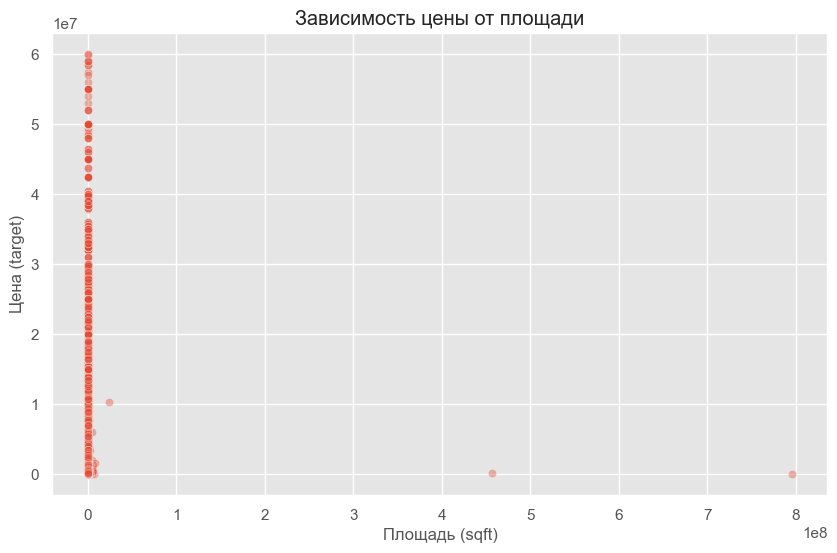

In [43]:
# Убираем строки с пропусками, если такие остались
df_plot = df[['sqft', 'target']].dropna()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='sqft', y='target', alpha=0.4)

plt.title('Зависимость цены от площади')
plt.xlabel('Площадь (sqft)')
plt.ylabel('Цена (target)')
plt.grid(True)
plt.show()

Сильно искажено. Подправим 

In [44]:
filtered_df = df[(df['sqft'] >= 100) & (df['sqft'] <= 10000)]
print("Количество объектов с площадью от 100 до 10,000 sqft:", len(filtered_df))


Количество объектов с площадью от 100 до 10,000 sqft: 353320



📌 Почему 100 sqft (нижняя граница):
Площадь меньше 100 sqft (~9 м²) — нереалистично мала для жилой недвижимости.

Это может быть:
* ошибка ввода (например, перепутали метры и футы),
* участок без постройки,
* технические объекты (гаражи, сараи и т.п.),
* отсутствующее или нулевое значение (sqft = 0).
Такие объекты искажают распределение и не представляют интереса для прогнозирования обычной цены жилья.



📌 Почему 10,000 sqft (верхняя граница):
10,000 sqft = ~929 м² — это огромный дом, но всё ещё реалистичный для люксового сегмента.

Объекты с площадью выше 10,000 sqft — редкие, часто являются:

*  коммерческой недвижимостью,
*  усадьбами, отелями, фермами,
*  или аномалиями/выбросами (например, ошибки в данных: 100,000 вместо 1,000).


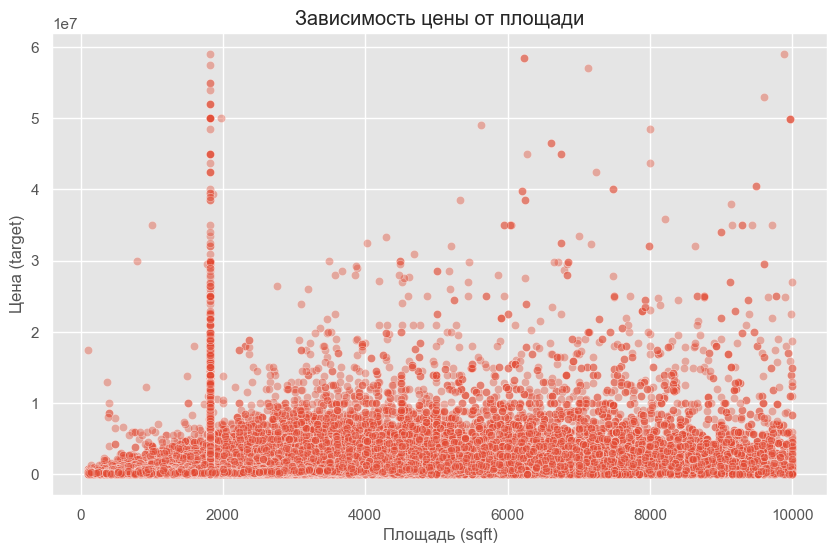

In [45]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='sqft', y='target', alpha=0.4)

plt.title('Зависимость цены от площади')
plt.xlabel('Площадь (sqft)')
plt.ylabel('Цена (target)')
plt.grid(True)
plt.show()

1. Аномалия вокруг 2000 sqft
В этой области наблюдается вертикальная линия точек, заполнение медианой пропусков

2. Выбросы по цене
Некоторые объекты с небольшой площадью (меньше 3000 sqft) имеют аномально высокие цены (выше 5–6×10⁷) — это явно выбросы.

Также в верхней части графика по всей ширине (на разных площадях) видны точки с чрезмерно высокими ценами, которые сильно превышают медианный уровень цен.

3. Шум и слабая зависимость
Несмотря на положительную тенденцию, зависимость цены от площади достаточно "размазанная" — в одной и той же области по площади цены могут отличаться на порядок.

Это говорит о том, что другие факторы (локация, состояние, тип недвижимости и т.д.) также существенно влияют на цену.


Теперь присваиваем категории в зависимости от квантилей по площади 

pd.qcut(df['sqft'], q=4) — это квантильное разбиение 
Он делит значения столбца sqft на 4 группы (квантили) так, чтобы:   
в каждой группе было примерно одинаковое количество строк (а не равные интервалы, как в pd.cut), 
границы между группами выбираются по распределению данных.  


In [46]:
# Присваиваем отфильтрованный датасет обратно df
df = filtered_df.copy()

df['sqft_category'] = pd.qcut(df['sqft'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

Порядковый категориальный признак (Q1 < Q2 < Q3 < Q4).

Для кодирования порядковых признаков лучше использовать OrdinalEncoder

In [47]:

encoder = OrdinalEncoder(categories=[['Q1', 'Q2', 'Q3', 'Q4']])
df['sqft_category_encoded'] = encoder.fit_transform(df[['sqft_category']])

### Переходим к столбцу df.baths

In [48]:
df['baths'].unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '5.0', '1,500', '7.0', '1,250', '9 Baths',
       '2,250', '6.0', '12 Baths', '5.5', '3,500', '1.5 Baths', '2,750',
       'Bathrooms: 6', '4.5 Baths', '0', '750', '5.5+', '6', '10 Baths',
       '6 ba', '10.0', '4 ba', '12 ba', '2.5+', '8', '7.5+',
       'Bathrooms: 10', '0 / 0', '5 ba', '4.5+', 'Sq. Ft. ', '-- baths',
       'Bathrooms: 7', '7', '3.5+', '1.5+', '11 Baths', '5,000',
       '1.75 Baths', '9', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '13 Baths', '9.0', '7 ba', '12', '1.1 Baths',
       '2.5 ba', 'Bathrooms: 241', '10.5+'

In [49]:
# Проверяем какие и сколько уникальных значений у нас
print(f"Количество уникальных значений в 'baths': {df.baths.nunique()}")  
print(f"Кол-во пропущенных значений в 'baths': {df.baths.isna().sum()}\n") 
print(f"Подсчет количества уникальных значений 'baths': \n{df.baths.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'baths': 183
Кол-во пропущенных значений в 'baths': 91071

Подсчет количества уникальных значений 'baths': 
2 Baths          19.612658
3 Baths          13.449813
2                 7.703366
2.0               6.221568
4 Baths           5.594683
                   ...    
23 Baths          0.000381
5.25 Baths        0.000381
41.0              0.000381
Bathrooms: 21     0.000381
6.75 Baths        0.000381
Name: baths, Length: 183, dtype: float64


Много мусора: слов, сокращений, дробных значений.   
Ниже написана функция преобразания столбца в надлежащий вид

In [50]:
# Функция для удаления слов и извлечения чисел
def clean_baths(value):
    if pd.isna(value):
        return np.nan
    
    # Убираем все слова, связанные с ванных комнатах и оставляем только цифры
    cleaned_value = re.sub(r'[^0-9.,]', '', str(value))  # Оставляем только цифры и запятые/точки
    
    # Преобразуем результат в число, если получилось
    try:
        # Заменим запятую на точку, чтобы корректно преобразовать в float
        cleaned_value = cleaned_value.replace(',', '')
        return float(cleaned_value)
    except ValueError:
        return np.nan

# Применяем функцию
df['baths_clean'] = df['baths'].apply(clean_baths)


In [51]:
df['baths_clean'].unique()

array([3.50000e+00, 3.00000e+00, 2.00000e+00, 8.00000e+00,         nan,
       1.75000e+03, 4.00000e+00, 5.00000e+00, 1.00000e+03, 7.00000e+00,
       1.00000e+00, 2.10000e+00, 2.50000e+00, 4.50000e+00, 6.00000e+00,
       2.50000e+03, 5.50000e+00, 1.50000e+00, 4.00000e+03, 2.00000e+03,
       3.00000e+03, 1.50000e+03, 1.25000e+03, 9.00000e+00, 2.25000e+03,
       1.20000e+01, 3.50000e+03, 2.75000e+03, 0.00000e+00, 7.50000e+02,
       1.00000e+01, 7.50000e+00, 1.10000e+01, 5.00000e+03, 1.75000e+00,
       6.50000e+00, 1.90000e+01, 1.30000e+01, 1.10000e+00, 2.41000e+02,
       1.05000e+01, 1.80000e+01, 7.50000e+03, 2.00000e+01, 4.00000e+01,
       1.01010e+04, 2.75000e+00, 2.25000e+00, 3.10000e+00, 3.25000e+00,
       1.60000e+01, 2.40000e+01, 9.50000e+00, 1.50000e+01, 3.75000e+00,
       2.90000e+01, 2.20000e+01, 8.50000e+00, 5.20000e+00, 3.12200e+03,
       2.10000e+01, 1.25000e+00, 2.20000e+00, 1.11100e+03, 1.40000e+01,
       2.50000e+01, 1.25000e+01, 5.00000e-01, 4.25000e+00, 4.750

Чтобы округлить значения в столбце df.baths до целых чисел и убрать явно ошибочные значения (например, 116116116.0), выполните следующие шаги:

In [52]:
# Округлить до целого
df['baths_clean'] = df['baths_clean'].round().astype('Int64')  # округляем и сохраняем как целые (с поддержкой NaN)

# Проверяем остаток
print(df['baths_clean'].value_counts(ascending=False))


2          114906
3           64587
4           32814
1           15925
5            9166
6            4897
1500         2195
7            1974
2000         1777
1750         1705
3000         1681
2250         1414
1000         1275
1250         1201
8            1076
2750          959
2500          885
3500          648
9             380
4000          285
750           236
5000          229
10            215
11             94
12             86
0              76
13             42
16             22
7500           19
14             17
15             11
18             10
20              8
24              7
30              4
22              2
19              2
21              2
23              1
26              1
17              1
10101           1
41              1
29              1
25              1
241             1
1111            1
40              1
3122            1
1101010         1
Name: baths_clean, dtype: Int64


In [53]:
print(df['baths_clean'].value_counts(ascending=False))

2          114906
3           64587
4           32814
1           15925
5            9166
6            4897
1500         2195
7            1974
2000         1777
1750         1705
3000         1681
2250         1414
1000         1275
1250         1201
8            1076
2750          959
2500          885
3500          648
9             380
4000          285
750           236
5000          229
10            215
11             94
12             86
0              76
13             42
16             22
7500           19
14             17
15             11
18             10
20              8
24              7
30              4
22              2
19              2
21              2
23              1
26              1
17              1
10101           1
41              1
29              1
25              1
241             1
1111            1
40              1
3122            1
1101010         1
Name: baths_clean, dtype: Int64


In [54]:
print(f"Кол-во пропущенных значений в 'baths_clean': {df.baths_clean.isna().sum()}\n") 
# Количество np.nan значений увеличилось примерно на 14,500 строк. ( это убрали мусор и экстремальные значения.)

Кол-во пропущенных значений в 'baths_clean': 92476



In [55]:
#Собираем все аномальные значения. 
print(f"Кол-во аномально высоких значений в'baths_clean': {df.loc[df['baths_clean'] > 8, 'baths_clean'].count()}") 

Кол-во аномально высоких значений в'baths_clean': 15423


Все это можно приравнять к пропущенным значениям. Скорее всего ошибки ввода


In [56]:
df.loc[df['baths_clean'] > 8, 'baths_clean'] = np.nan  # отбрасываем нереалистичные значения

missing_baths_values = (df['baths_clean'].isna().sum() / len(df)) * 100
print(f"Пропущенных значений в 'baths_clean': {round(missing_baths_values )}%")
# Много


Пропущенных значений в 'baths_clean': 31%


Кол-во ванных комнат можно попробовать восстановить по zipcode.    
Заполним пропуски медианным значением по почтовому индексу.

In [57]:
# Mедиану baths_clean по zipcode
median_baths_by_zip = df.groupby('zipcode')['baths_clean'].median()

#  Функция для заполнения:
def fill_baths(row):
    if pd.isna(row['baths_clean']):
        return median_baths_by_zip.get(row['zipcode'], np.nan)
    return row['baths_clean']

# Применяем 
df['baths_clean'] = df.apply(fill_baths, axis=1)

In [58]:
missing_baths_values = (df['baths_clean'].isna().sum() / len(df)) * 100
print(f"Пропущенных значений в 'baths_clean': {round(missing_baths_values )}%")

Пропущенных значений в 'baths_clean': 0%


In [59]:
df['baths_clean'].value_counts(ascending=False)

2.0    177977
3.0    100316
4.0     39534
1.0     16272
5.0      9288
6.0      4910
7.0      1975
8.0      1076
2.5      1032
3.5       138
4.5       109
1.5        77
0.0        76
5.5        36
Name: baths_clean, dtype: int64

In [60]:
# Преобразуем в число (ошибки будут заменены на NaN)
df['baths_clean'] = pd.to_numeric(df['baths_clean'], errors='coerce')

# Округлить до целого
df['baths_clean'] = df['baths_clean'].round().astype('Int64')  # округляем и сохраняем как целые (с поддержкой NaN)

# Проверяем преобразования
print(f"Количество уникальных значений в 'baths_clean': \n{df['baths_clean'].value_counts(ascending=False)}\n")

# Проверяем остаток
print(f"Пропущенных значений в 'baths_clean': {df['baths_clean'].isna().sum()}")


Количество уникальных значений в 'baths_clean': 
2    179086
3    100316
4     39781
1     16272
5      9288
6      4946
7      1975
8      1076
0        76
Name: baths_clean, dtype: Int64

Пропущенных значений в 'baths_clean': 504


In [61]:
#Остатков по пропущенным значениям не так уж много. Заполним общей модой по столбцу. 
df['baths_clean'] = df['baths_clean'].fillna(df['baths_clean'].median())

In [62]:
# Проверяем остаток
print(f"Пропущенных значений в 'baths_clean': {df['baths_clean'].isna().sum()}")

Пропущенных значений в 'baths_clean': 0


c:\Users\Lenovo-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Lenovo-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


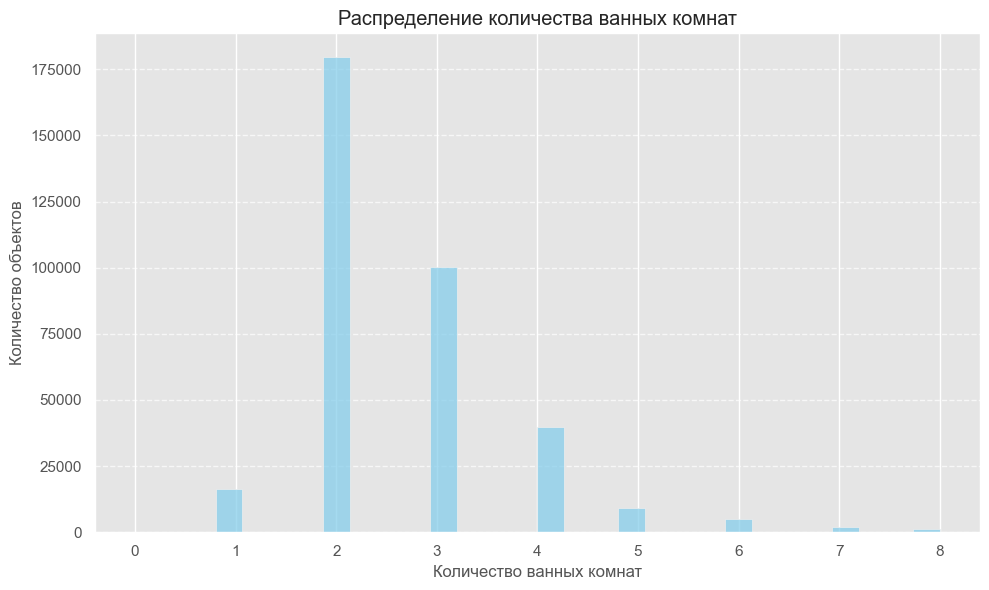

In [63]:
# Построение распределения
plt.figure(figsize=(10, 6))
sns.histplot(df['baths_clean'], bins=30, kde=False, color='skyblue')

plt.title('Распределение количества ванных комнат')
plt.xlabel('Количество ванных комнат')
plt.ylabel('Количество объектов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Судя по графику основные пики приходятся на:
* 2 ванны (наиболее частое значение),
* 3 ванны,
* 4 ванны.

Распределение уже преобретает нормальынй вид.

### Переходим к столбцу df.fireplace

In [64]:
print(f"Количество уникальных значений в 'fireplace': {df.fireplace.nunique()}\n")  
print(f"Кол-во пропущенных значений в 'fireplace': {df.fireplace.isna().sum()}\n") 
print(f"Подсчет количества уникальных значений 'fireplace': \n{df.fireplace.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'fireplace': 1608

Кол-во пропущенных значений в 'fireplace': 252342

Подсчет количества уникальных значений 'fireplace': 
yes                                                                                                                                                                            48.716552
Yes                                                                                                                                                                            20.186575
1                                                                                                                                                                              14.240726
2                                                                                                                                                                               2.361901
Not Applicable                                                                                          

In [65]:
df['fireplace'].unique()

array(['Gas Logs', nan, 'yes', ...,
       'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet',
       'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets', '9'],
      dtype=object)

In [66]:
# Извлекаем уникальные значения из столбца
unique_values = df['fireplace'].unique()

unique_values_list = unique_values.tolist()   
print(unique_values_list)

['Gas Logs', nan, 'yes', 'Yes', '2', '0', '1', 'Not Applicable', 'Fireplace YN', 'Family Room, Master Bedroom', '1 Fireplace', 'Fireplace', 'Living Room, Wood Burning', '1 Fireplace, Exterior Fireplace', '3', 'N/K', 'Firepit, Gas Fireplace', 'Gas Logs, In Den/Family Room', 'FAMILYRM', 'Wood', 'Direct Vent, Gas Log, 1 Fireplace', 'Family Room, Living Room, Wood Burning', '1 Fireplace, Wood Burning', 'Extra Closets', 'Gas Logs, Great Room', 'Special Features', 'No', 'Gas, Propane', 'Great Room', 'Ceiling Fan, Extra Closets, Storage, Utility Connection', 'Gas, Living Room', 'Insert, Wood', 'Living Room', 'Fireplace Features', 'Gas Logs, In Great Room', 'Ceiling Fan, Central Vacuum, Elevator, Extra Closets, Storage, Walk-In Closets', 'Living Room, Natural Gas', 'Baseboard, Fireplace-Wood, Hot Water/Steam, Radiators', 'Gas Log Starter, Gas Logs, In Great Room', 'Electric', 'Gas Log, 1 Fireplace', 'Ceiling Fan, Walk-In Closets, Wood Burning FP', 'Wood Burning', 'Ceiling Fan, Extra Closets, S

In [67]:
# в этом столбце есть нестроковые значения (например, NaN, числа и т.д.), 
# то сначала лучше привести все значения к строковому типу:
df['fireplace'] = df['fireplace'].apply(
    lambda x: x.lower() if isinstance(x, str) else x
)

Логика такова:
1. Сначала привожу все значения к 'yes' /  'no'
У нас средний сегмент рынка- в данном сегменте важно само наличие или отсутствие камина. На конечную стоимость не сильно влиает 2-а их или 1. 
2. Привожу к бинарноным значениям 0 / 1

In [68]:
#Заменяем 'fireplace' на 'yes
df['fireplace'] = df['fireplace'].apply(
    lambda x: 'yes' if isinstance(x, str) and 'fireplace' in x.lower() else x
)

#Заменяем 'not applicable' на 'no'
df['fireplace'] = df['fireplace'].replace('not applicable', 'no')

In [69]:
df['fireplace'].value_counts()

yes                                                                         72549
1                                                                           14380
2                                                                            2385
no                                                                           2252
3                                                                             535
                                                                            ...  
bonus room, den, familyrm                                                       1
great room, living room, master bedroom                                         1
ceiling fan, elevator, extra closets, storage, walk-in closets, wet bar         1
ceiling fan, extra closets, hot tub, utility connection, wood burning fp        1
9                                                                               1
Name: fireplace, Length: 1179, dtype: int64

In [70]:
# Объединённая функция для нормализации столбца 'fireplace'
def normalize_fireplace(x):
    if not isinstance(x, str):
        return x
    
    xl = x.lower()
    
    # Ключевые слова для отсутствия камина
    no_keywords = [
        'ceiling fan', 'elevator', 'storage', 'extra', 'free', 'other',
        'sprinkler', 'utility connection', 'closets', 'smapl', 'room',
        'fire pit', 'firepit','kitchen', 'dining', 'in-law quarters',
        'location', 'heating'
    ]
    # Ключевые слова для наличия камина (текстовые)
    yes_keywords = [
        'gas', 'electric', 'wood', 'woodburning', 'coal', 'propane',
        'brick', 'masonry', 'decorative', 'stove'
    ]
    # Ключевые слова‑слова числительных
    yes_number_words = ['one', 'two', 'three', 'four', 'five', 'six']
    # Ключевые слова‑цифры
    number_keywords = ['0', '1', '2', '3', '3+', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    
    # 1) Если есть явный признак камина — 'yes'
    if any(kw in xl for kw in yes_keywords):
        return 'yes'
    if any(word in xl for word in yes_number_words):
        return 'yes'
    if any(num in x for num in number_keywords):
        return 'yes'
    
    # 2) Иначе, если встречается из списка no_keywords — 'no'
    if any(kw in xl for kw in no_keywords):
        return 'no'
    
    # 3) Всё прочее — оставляем без изменений
    return x

# Применение к DataFrame
df['fireplace'] = df['fireplace'].apply(normalize_fireplace)

In [71]:
df['fireplace'].nunique()

42

In [72]:
df['fireplace'].value_counts()

yes                         94924
no                           5317
special features              278
familyrm                      245
den                            65
n/k                            47
factory built                  12
insert                         12
see agent                       9
basement, den                   7
den, familyrm                   7
smthr                           6
number                          5
wet bar                         4
basement                        4
direct vent                     3
redecorated                     3
flue                            2
outdoors                        2
bath features                   2
air filter                      2
see through                     2
living                          1
bath                            1
water filter                    1
central vacuum, smthr           1
insert unit, blower             1
hot tub, redecorated            1
frplc-fam rm/den/gr             1
attached doors

In [73]:
# Извлекаем уникальные значения из столбца
unique_values = df['fireplace'].unique()

unique_values_list = unique_values.tolist()   

print(unique_values_list)

['yes', nan, 'no', 'n/k', 'familyrm', 'special features', 'smthr', 'den', 'bath features', 'flue', 'number', 'factory built', 'unit features', 'pre-fab', 'insert', 'living', 'basement, den', 'see agent', 'den, familyrm', 'wet bar', 'outdoors', 'direct vent', 'basement', 'smcam', 'redecorated', 'in living area', 'pellet', 'air filter', 'water filter, wet bar', 'ventless', 'prefab', 'heatilator type system', 'central vacuum', 'bath', 'familyrm, porch', 'see through', 'attached doors, ventless', 'frplc-fam rm/den/gr', 'hot tub, redecorated', 'insert unit, blower', 'central vacuum, smthr', 'water filter', 'study']


In [74]:
df['fireplace'] = df['fireplace'].apply(
    lambda x: x if pd.isna(x) or x in ['yes', 'no'] else 'no'
)

In [75]:
df['fireplace'].value_counts(normalize=True)

yes    0.940046
no     0.059954
Name: fireplace, dtype: float64

In [76]:
df['fireplace'] = df['fireplace'].map({'yes': 1, 'no': 0})

In [77]:
print(f"Кол-во пропущенных значений в 'fireplace': {round(df.fireplace.isna().sum()/len(df)*100)}%\n") 

Кол-во пропущенных значений в 'fireplace': 71%



Вернусь к этому столбцу, когда подчищу признак df.propertyType -  тогда сгруппирую по zipcode, propertyType и fireplace

### Переходим к столбцу df.state

In [78]:
print(f"Количество уникальных значений в 'state': {df.state.nunique()}\n")  
print(f"Кол-во пропущенных значений в 'state': {df.state.isna().sum()}\n") 
print(f"Подсчет количества уникальных значений 'state': \n{df.state.value_counts(normalize=True)*100}")

Количество уникальных значений в 'state': 38

Кол-во пропущенных значений в 'state': 0

Подсчет количества уникальных значений 'state': 
FL    29.828201
TX    22.834258
NY     6.490151
CA     6.387128
NC     5.812861
TN     4.803577
WA     3.743632
OH     3.267576
IL     2.428110
NV     2.361882
CO     1.770916
GA     1.727046
PA     1.526944
DC     1.266274
MI     1.093626
AZ     0.913336
IN     0.888430
OR     0.777482
MA     0.420582
UT     0.362561
MD     0.301993
MO     0.229537
VT     0.202083
VA     0.189630
WI     0.114344
NJ     0.101608
IA     0.057172
ME     0.053493
KY     0.018680
OK     0.008491
SC     0.007642
MS     0.007359
DE     0.001415
MT     0.000849
Fl     0.000283
BA     0.000283
OT     0.000283
OS     0.000283
Name: state, dtype: float64


Лидирующие позиции у Флориды и Техаса. Это южные штаты. 


Убираем вне невалидные значения, вместо них ставим np.nan 

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353320 entries, 0 to 377184
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   status                 316040 non-null  object  
 1   propertyType           321565 non-null  object  
 2   street                 353318 non-null  object  
 3   baths                  262249 non-null  object  
 4   homeFacts              353320 non-null  object  
 5   fireplace              100978 non-null  float64 
 6   city                   353316 non-null  object  
 7   schools                353320 non-null  object  
 8   sqft                   353320 non-null  float64 
 9   zipcode                353319 non-null  object  
 10  beds                   277422 non-null  object  
 11  state                  353320 non-null  object  
 12  stories                220958 non-null  object  
 13  mls-id                 24723 non-null   object  
 14  MlsId               

Некоторых аббревиатур не существует. Мы их уберем. Так же исправим 'Fl' на 'FL'

In [80]:
# Набор "ошибочных" значений

valid_codes = {
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY',
    'DC'
}

cleaned_states = []
for val in df['state']:
    if isinstance(val, str):
        code = val.strip().upper()
        if code in valid_codes:
            cleaned_states.append(code)
        else:
            cleaned_states.append(np.nan)
    else:
        cleaned_states.append(np.nan)

df['state'] = cleaned_states


In [81]:
df['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'PA', 'FL', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT', 'AZ',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', nan], dtype=object)

In [82]:
df['state'].isna().sum() 
#Их 3 значения. Удаляем

3

In [83]:
# Оставляем только строки с валидными значениями в 'state_cleaned'
df = df[df['state'].notna()].copy()

Посмотрим на распределения продвж по всей Америке

In [84]:
us_state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

# Преобразуем сокращения в полные названия
df['state_full'] = df['state'].map(us_state_abbrev)

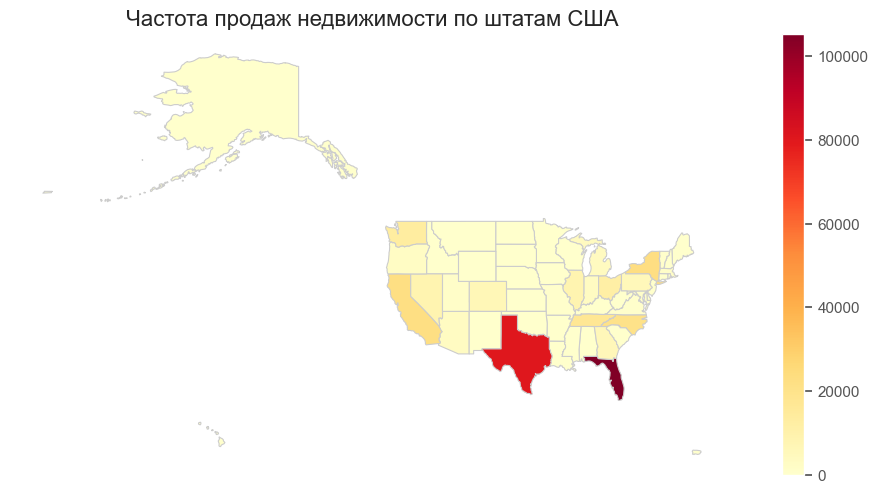

In [85]:

# Загрузка границ штатов США из GitHub (GeoJSON)
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
us_states = gpd.read_file(url)

# Подсчёт количества объектов недвижимости по штатам
state_counts = df['state_full'].value_counts().rename_axis('state').reset_index(name='count')

# Объединение с геоданными
merged = us_states.merge(state_counts, left_on='name', right_on='state', how='left')
merged['count'] = merged['count'].fillna(0)

# Построение тепловой карты
fig, ax = plt.subplots(figsize=(10, 5))
merged.plot(column='count', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax=ax, legend=True)

ax.set_title('Частота продаж недвижимости по штатам США', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


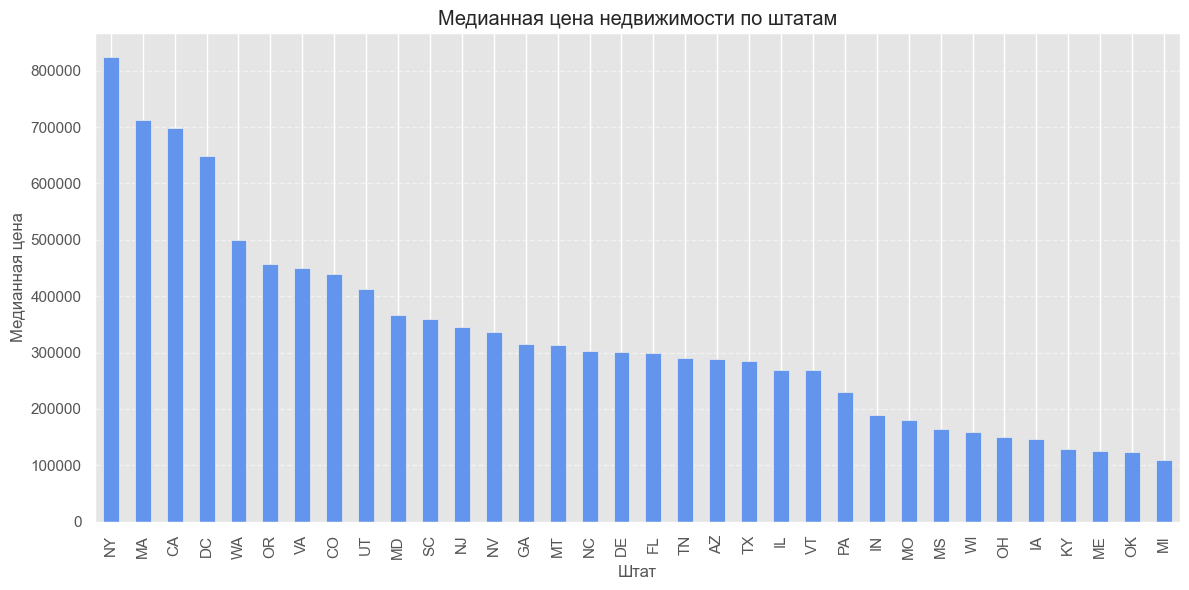

In [86]:

# Группировка
state_medians = df.groupby('state')['target'].median().sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
state_medians.plot(kind='bar', color='cornflowerblue')
plt.title('Медианная цена недвижимости по штатам')
plt.ylabel('Медианная цена')
plt.xlabel('Штат')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


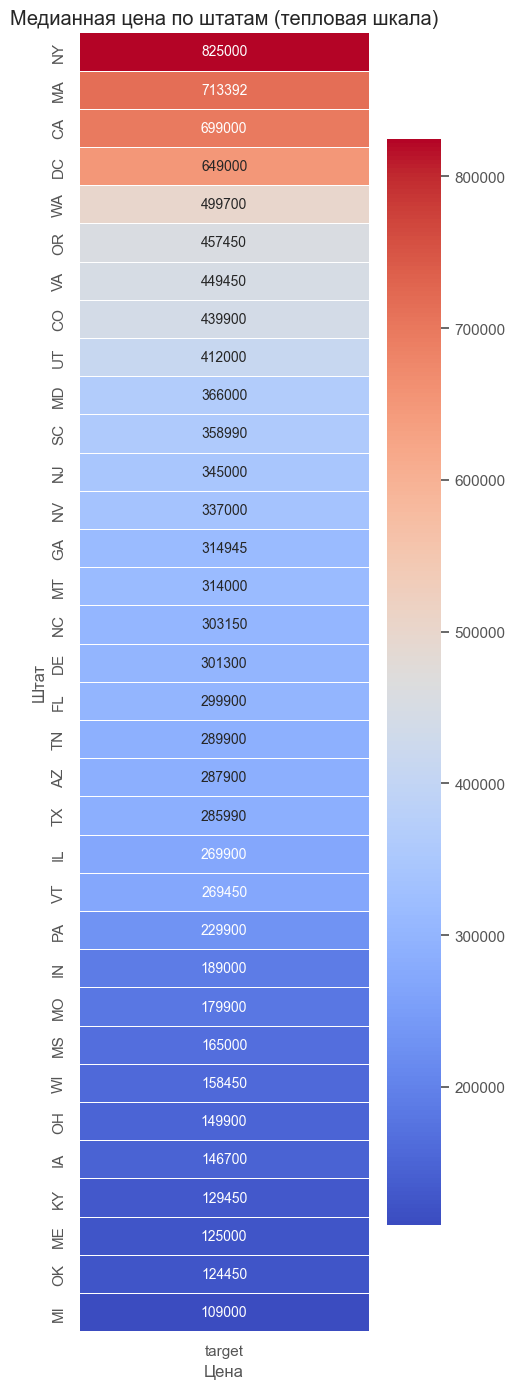

In [87]:
plt.figure(figsize=(5, 14))
sns.heatmap(state_medians.to_frame(), cmap='coolwarm', annot=True, fmt='.0f', linewidths=0.5)
plt.title('Медианная цена по штатам (тепловая шкала)')
plt.xlabel('Цена')
plt.ylabel('Штат')
plt.tight_layout()
plt.show()

In [88]:
# Топ по количеству
top_states_by_count = df['state'].value_counts().head(10)

# Топ по цене
top_states_by_price = df.groupby('state')['target'].median().sort_values(ascending=False).head(10)

# Сравнение
print("Топ 10 по количеству:\n", top_states_by_count)
print("\nТоп 10 по цене:\n", top_states_by_price)


Топ 10 по количеству:
 FL    105390
TX     80678
NY     22931
CA     22567
NC     20538
TN     16972
WA     13227
OH     11545
IL      8579
NV      8345
Name: state, dtype: int64

Топ 10 по цене:
 state
NY    825000.0
MA    713391.5
CA    699000.0
DC    649000.0
WA    499700.0
OR    457450.0
VA    449450.0
CO    439900.0
UT    412000.0
MD    366000.0
Name: target, dtype: float64


Ценовая политика пляшет от штату к штату. По количеству предложений TX и FL лидируют, а вот по ценовому диапозону сильно выбиваются (по дороговизне) NY, MA, CA, DC. Тут прийдетя при обучении обязательно стратифицировать данные, чтобы в равных долях попали данные о дорогих и дешевых предложениях, особенно когда дорогих мало, а вес значительный 

Также признаки частного бассеина вжен для южных штатов, а камин важен в северных да и еще премиальных штатах. 
Так что прийдется заполнять все. 


 Создаем Binary Encoding для 'state', так как у нас больше 35 значений.

In [89]:
encoder = ce.BinaryEncoder(cols=['state'])

# Кодируем столбец 'state' (получаем только бинарные колонки)
state_encoded = encoder.fit_transform(df[['state']])

# Добавляем бинарно закодированные признаки в исходный датафрейм
df = pd.concat([df, state_encoded], axis=1)


In [90]:
df.head(2)

status        propertyType             street    baths  \
0    Active  Single Family Home     240 Heather Ln      3.5   
1  for sale  single-family home  12911 E Heroy Ave  3 Baths   

                                           homeFacts  fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...        1.0   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...        NaN   

             city                                            schools    sqft  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...  2900.0   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...  1947.0   

  zipcode  ... sqft_category sqft_category_encoded baths_clean  \
0   28387  ...            Q4                   3.0           4   
1   99216  ...            Q3                   2.0           3   

       state_full state_0  state_1  state_2 state_3  state_4  state_5  
0  North Carolina       0        0        0       0        0        1  
1      Washington       0        0        0       0        1        0  

[2 rows x 27 columns]

In [91]:
df.state.unique()

array(['NC', 'WA', 'CA', 'TX', 'PA', 'FL', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT', 'AZ',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE'], dtype=object)

### Переходим к столбцу df.propertyType

In [92]:
# Проверяем какие и сколько уникальных значений у нас
print(f"Количество уникальных значений в 'propertyType': {df.propertyType.nunique()}")  
print(f"Кол-во пропущенных значений в 'propertyType': {df.propertyType.isna().sum()}\n") 
print(f"Подсчет количества уникальных значений 'propertyType': \n{df.propertyType.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'propertyType': 1268
Кол-во пропущенных значений в 'propertyType': 31752

Подсчет количества уникальных значений 'propertyType': 
single-family home                                             27.896071
Single Family                                                  19.085099
Single Family Home                                              9.682335
condo                                                           8.032280
lot/land                                                        5.606643
                                                                 ...    
1 Story, Spanish, Ranch, Traditional                            0.000311
Condo/Townhome, Single Detached                                 0.000311
Contemporary/Modern, French, Mediterranean, Traditional         0.000311
Custom, Elevated, Other                                         0.000311
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit     0.000311
Name: propertyType, Length: 1268, 

In [93]:
df['propertyType'].unique()

array(['Single Family Home', 'single-family home', 'townhouse', ...,
       'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam',
       'Lake House, Single Detached, Tudor',
       'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit'],
      dtype=object)

In [94]:
unique_values = df['propertyType'].unique()

unique_values_list = unique_values.tolist()   

print(unique_values_list)

['Single Family Home', 'single-family home', 'townhouse', 'Florida', nan, 'Single Family', 'coop', 'English', '2 Story', 'Townhouse', 'multi-family', 'Penthouse, Split-Level', 'Multi-Family Home', 'Condo', 'condo', 'lot/land', ' ', 'Detached, Two Story', '1 Story, Ranch', 'Other Style', 'Colonial', 'Transitional', 'High Rise', 'mobile/manufactured', 'Tri-Level, Northwestern Contemporary', 'Condo/Townhome/Row Home/Co-Op', 'Detached, One Story', 'Craftsman', '1 Story, Traditional', 'Single Detached, Traditional', 'Federal', 'Multi Family', 'Traditional', 'Custom', 'Cooperative', 'Contemporary/Modern, Traditional', 'Cape Cod, Contemporary, Florida, Key West', 'Single Detached', 'Mobile / Manufactured', 'Contemporary/Modern', 'Miscellaneous', 'Mfd/Mobile Home', 'Bungalow', '1 Story', 'Spanish/Mediterranean', 'Contemporary', 'Multi-Level, Modern', 'Condo/Unit', '2 Stories, Traditional', 'Ranch', 'Low-Rise (1-3 Stories)', '1 Story, Contemporary', 'Rancher, Raised Ranch', 'Bungalow, Cape Cod'

In [95]:
# ЗАменяем все мелкие знаки препенания и т д 
def clean_property_type(x):
    if pd.isna(x):
        return np.nan  # оставляем NaN без изменений
    
    x = x.lower()
    x = x.replace('-', ' ')
    x = x.replace(',', '')
    x = x.replace('/', '')
    x = x.replace('\\', '')
    x = x.strip()
    return x

df['propertyType'] = df['propertyType'].apply(clean_property_type)

In [96]:
df.propertyType.value_counts(normalize=True).head(15)

single family home             0.375784
single family                  0.190851
condo                          0.131457
townhouse                      0.056797
lotland                        0.056066
multi family                   0.031854
condotownhomerow homeco op     0.023510
traditional                    0.018354
coop                           0.007352
high rise                      0.005706
ranch                          0.005539
detached one story             0.005016
mobilemanufactured             0.004948
single detached traditional    0.004904
contemporary                   0.004836
Name: propertyType, dtype: float64

Тут я много раз переписывала код, вот конечный вариант функции по очистки propertyType

In [97]:
# Ключевые списки для проверки (в lower)
single_family_keywords = [
    'single family', 'single family home','detached', 'single detached', 'one story', '1 story', 'ranch',
    'bungalow', 'split level', 'raised ranch', 'traditional', 'patio',
    'colonial', 'craftsman', 'craftsmanship', 'victorian', 'a frame'
]

house_keywords = [
    'townhouse', 'duplex', 'triplex', 'multiplex', 'cluster home', 'carriage', 'coach',
    'cottage', 'villa', 'farmhouse', 'transitional', 'modern', 'contemporary', 'rustic',
    'multi level', 'custom', 'multi generational', 'historic', 'early american', 'bi level',
    'cape cod', 'cape', 'french', 'spanishmediterranean', 'mediterranean', 'spanish', 'tudor',
    'european', 'english', 'southwestern', 'florida', 'key west', 'saltbox', 'old world',
    'arts & crafts', 'american 4 square', 'denver square', 'coastal', 'log', 'cabin', 'prairie',
    '2 stories', '2 story', 'two story', 'co op', 'coop'
]

apartment_keywords = [
    'apartment', 'condo', 'condounit', 'condotownhome', 'hi rise', 'loft', 'unit', 'flat',
    'resort property', 'mid century modern', 'warehouse', 'high rise'
]

lot_keywords = [
    'lot', 'land', 'courtyard', 'lotland', 'garden', 'zero lot line'
]

multi_family_keywords = [
    'multi family', 'multi family home'
]

mobile_keywords = [
    'mobile', 'manufactured', 'manuf', 'modular', 'mh', 'modularprefab'
]

# Допустимые категории
valid_categories = {
    'single family home',
    'house',
    'apartment',
    'lot',
    'multi family home',
    'mobile manufactured'
}

# Объединённая и расширенная функция
def normalize_property_type(x):
    if not isinstance(x, str):
        return x

    xl = x.lower().strip()

    # Специальные случаи, найденные вручную
    if 'singlefamily' in xl or 'singlefamilyresidence' in xl:
        return 'single family home'

    if 'multiple occupancy' in xl or 'fourplex' in xl or 'triplex' in xl:
        return 'multi family home'

    if any(kw in xl for kw in ['low rise', 'mid rise', 'penthouse', 'elevated']):
        return 'apartment'

    if any(kw in xl for kw in ['federal', 'georgian', 'beaux arts', 'tuscan', 'straight thru']):
        return 'house'

    # Single family
    if any(kw in xl for kw in single_family_keywords):
        return 'single family home'

    # House
    if any(kw in xl for kw in house_keywords):
        return 'house'

    # Apartment
    if any(kw in xl for kw in apartment_keywords):
        return 'apartment'

    # Lot / Land
    if any(kw in xl for kw in lot_keywords):
        return 'lot'

    # Multi-family
    if any(kw in xl for kw in multi_family_keywords):
        return 'multi family home'

    # Mobile / Manufactured
    if any(kw in xl for kw in mobile_keywords):
        return 'mobile manufactured'

    # Уже допустимая категория
    if xl in valid_categories:
        return xl

    # Всё остальное
    return 'other'


In [98]:
df['propertyType_clean'] = df['propertyType'].apply(normalize_property_type)

In [99]:
df['propertyType_clean'].value_counts()

single family home     203368
apartment               45835
house                   37473
lot                     18382
multi family home       11765
mobile manufactured      3434
other                    1308
Name: propertyType_clean, dtype: int64

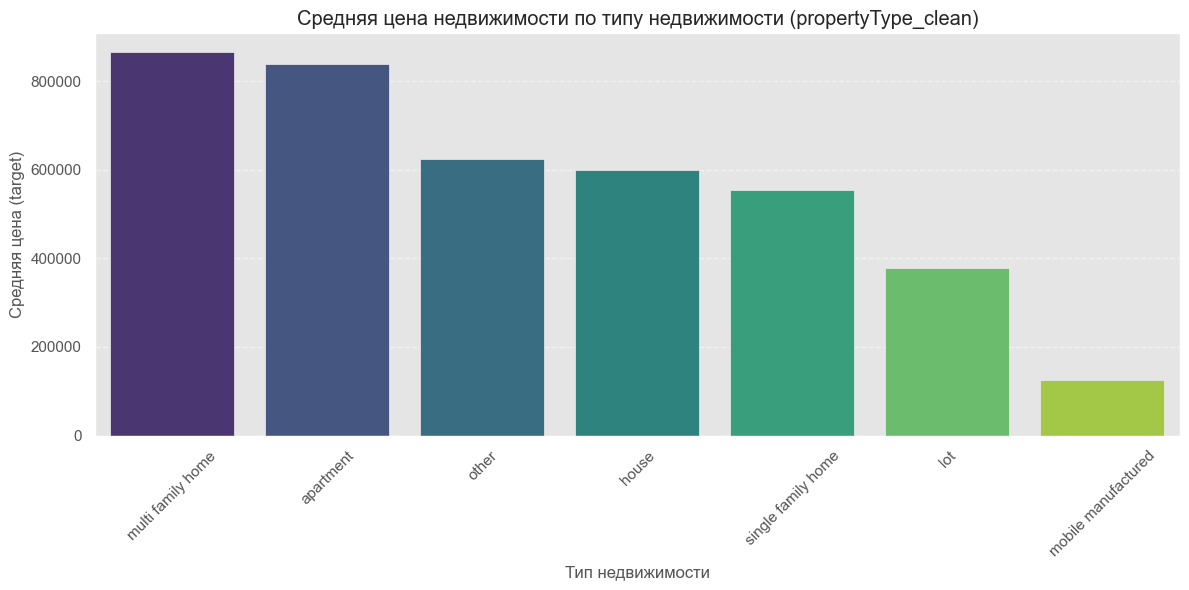

In [100]:
# Группировка и расчёт среднего
grouped_type = df.groupby('propertyType_clean')['target'].mean().sort_values(ascending=False)

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_type.index, y=grouped_type.values, palette='viridis')

plt.title('Средняя цена недвижимости по типу недвижимости (propertyType_clean)')
plt.xlabel('Тип недвижимости')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Хорошее - плавное распределение по цене.
Проверяем что осталось в категории 'others' 

In [101]:
df[df['propertyType_clean'] == 'other']['propertyType'].value_counts().head(20)
# осталась всякая мелкая шушора, больше ничего достать нельзя. Идем дальше

other style              249
other                    220
                         122
other (see remarks)       96
residential (<1 acre)     95
miscellaneous             88
tri level                 77
unknown                   29
residential (1+ acre)     20
attached                  19
farm house                17
commercialindustrial      17
art deco                  16
split entry               15
less than 4 floors        15
charleston                15
3+ stories                14
townhome style            12
store & dwelling          11
bilevel                   11
Name: propertyType, dtype: int64

Действительно - осталось много неинформативной мешанины. Оставляем столбец 'other' без изменений.

In [102]:
# Удаляем пустые строки и строки из пробелов
df['propertyType'] = df['propertyType'].replace(r'^\s*$', np.nan, regex=True)
df['propertyType_clean'] = df['propertyType'].apply(normalize_property_type)

In [103]:
df['propertyType_clean'].value_counts()


single family home     203368
apartment               45835
house                   37473
lot                     18382
multi family home       11765
mobile manufactured      3434
other                    1186
Name: propertyType_clean, dtype: int64

In [104]:
(df['propertyType_clean'].isna().sum())/len(df)*100

9.021360421377969

In [105]:
#Восстанавливаем пропуски модой propertyType по zipcode
zip_mode = df.groupby('zipcode')['propertyType_clean'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Подставляем, где пропуск
df['propertyType_clean'] = df.apply(
    lambda row: zip_mode[row['zipcode']] if pd.isna(row['propertyType_clean']) and row['zipcode'] in zip_mode else row['propertyType_clean'],
    axis=1
)

In [106]:
(df['propertyType_clean'].isna().sum())/len(df)*100


0.028020163196223222

Осталось совсем мало неизвестных. Их можно удалить.

In [107]:
df = df[~df['propertyType_clean'].isna()]

In [108]:
print(f"Осталось строк: {len(df)}")
print(f"Пропущенных в 'propertyType_clean': {df['propertyType_clean'].isna().sum()}")

Осталось строк: 353218
Пропущенных в 'propertyType_clean': 0


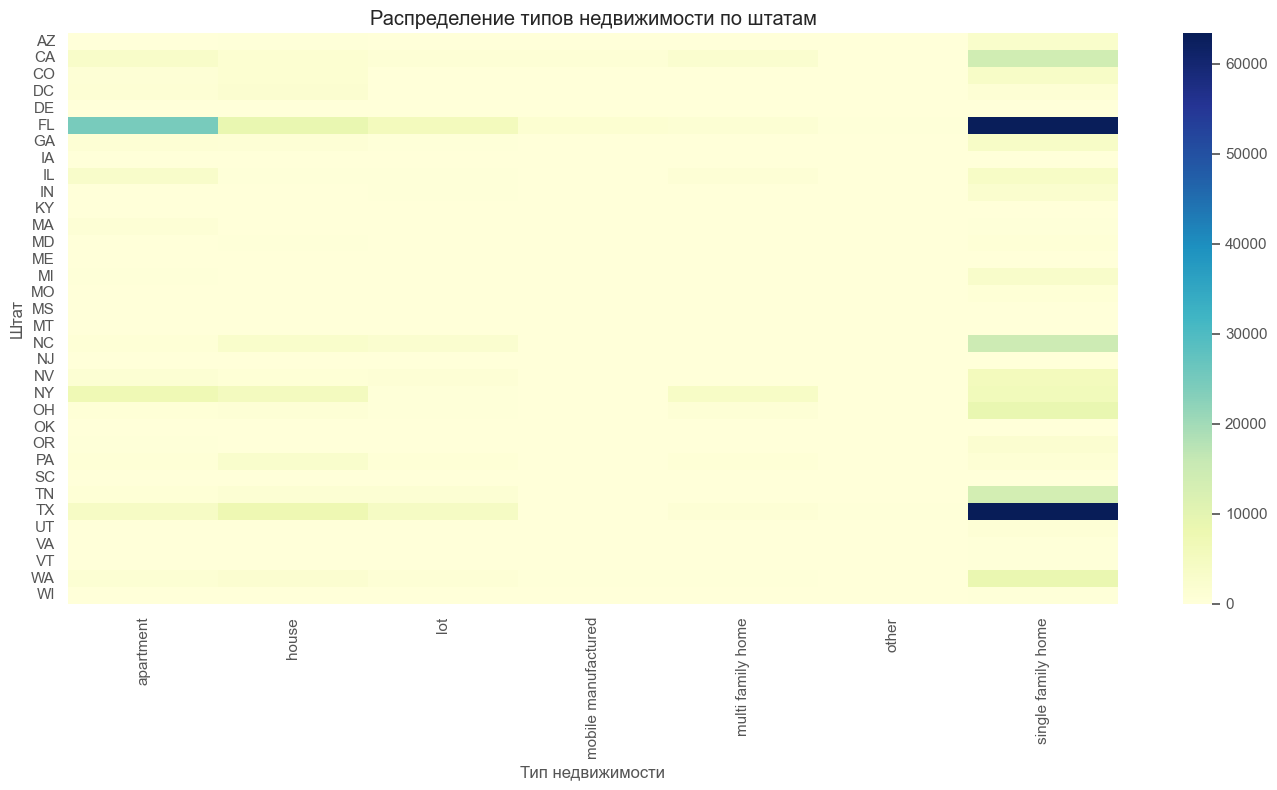

In [109]:
grouped = df.groupby('state')['propertyType_clean'].value_counts().unstack().fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(grouped, cmap='YlGnBu')
plt.title('Распределение типов недвижимости по штатам')
plt.xlabel('Тип недвижимости')
plt.ylabel('Штат')
plt.tight_layout()
plt.show()

Подтверждаются наши замечания по поводу FL и TX - много продаются single family house. 
Все остальное не так сильно выбивается, разве что apartments /lot в FL  и парочку других штатов по single family house.
Удивительно, что цена на multi family home очень высокая, а распространение по штатам очень низкое. 

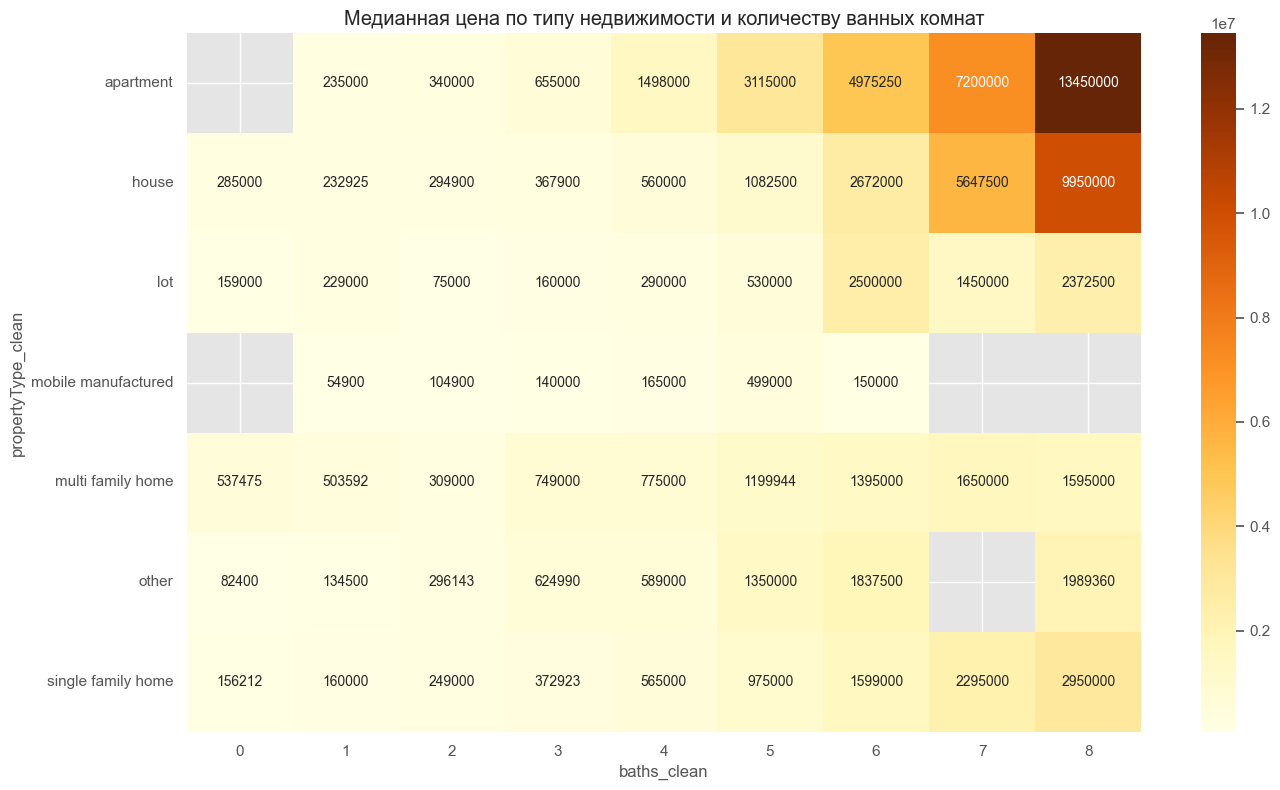

In [110]:

pivot = df.pivot_table(index='propertyType_clean', columns='baths_clean', values='target', aggfunc='median')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='YlOrBr', annot=True, fmt='.0f')
plt.title('Медианная цена по типу недвижимости и количеству ванных комнат')
plt.xlabel('baths_clean')
plt.ylabel('propertyType_clean')
plt.tight_layout()
plt.show()


от 0 до 5 ванных комнат цены то меньше то больше, тут скореее всего разные категории и города. Но есть ц категории, 
где цены сильно выбиваются : apartment и house
Обратить внимание позже на эти 2 типа, тут может быть элитное жилье либо выбросы. 

Посмотрим на расспределение цен на недаижимость 


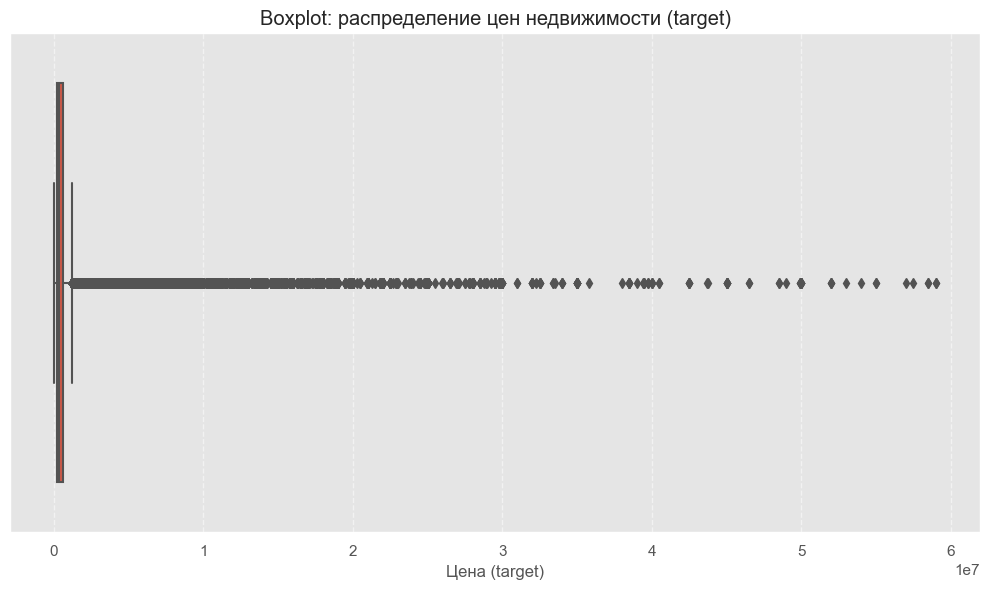

In [111]:

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['target'])

plt.title('Boxplot: распределение цен недвижимости (target)')
plt.xlabel('Цена (target)')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Лучше не стало.В других штатах тоже есть выбросы. Нужно пройтись по всем

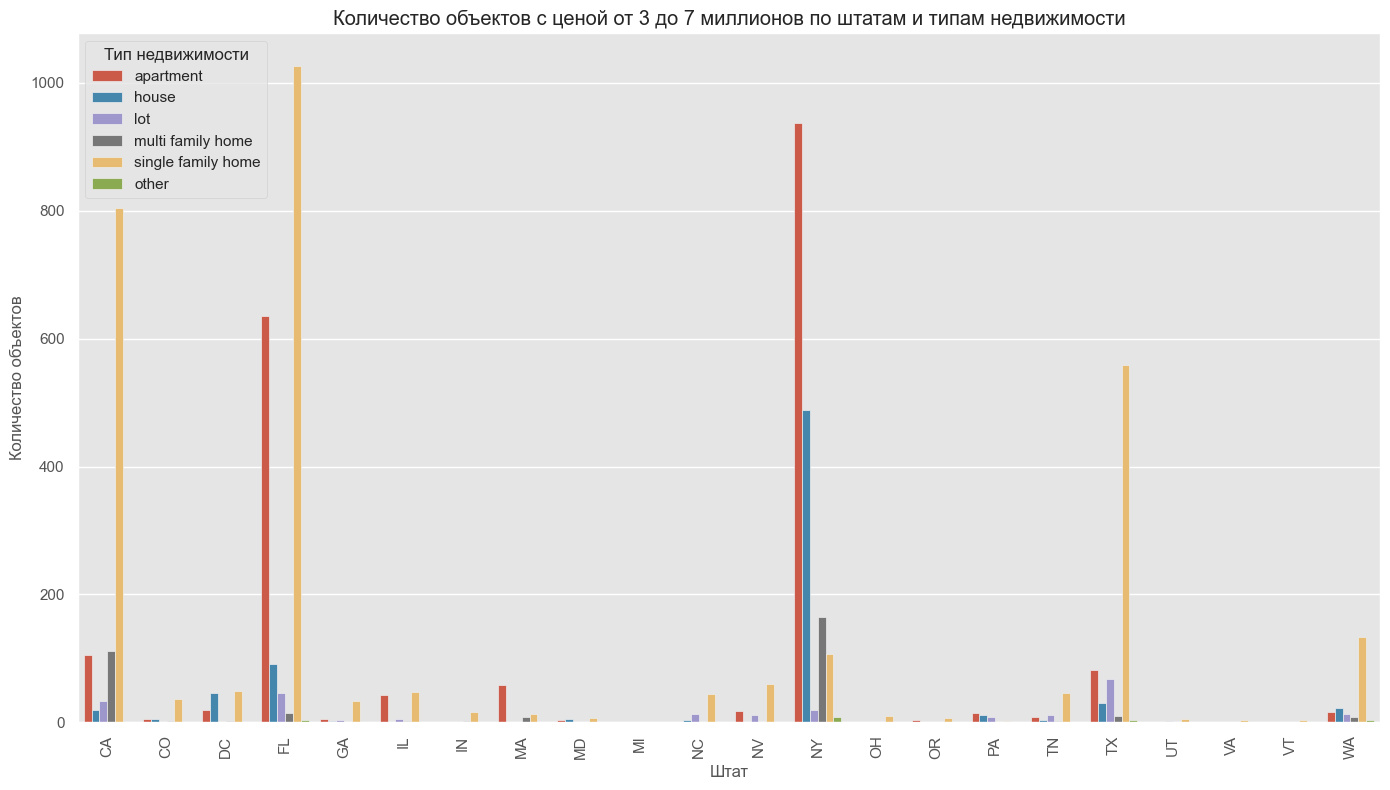

In [112]:
# Фильтр по ценам от 3 до 7 млн включительно
price_filtered = df[(df['target'] >= 3_000_000) & (df['target'] <= 7_000_000)]

# Для примера — посмотрим распределение по штатам и типам недвижимости
# Можно сгруппировать и посчитать количество или медианные цены

grouped = price_filtered.groupby(['state', 'propertyType_clean'])['target'].median().reset_index()


# Посчитаем количество объектов
counts = price_filtered.groupby(['state', 'propertyType_clean']).size().reset_index(name='count')

plt.figure(figsize=(14, 8))
sns.barplot(data=counts, x='state', y='count', hue='propertyType_clean')
plt.title('Количество объектов с ценой от 3 до 7 миллионов по штатам и типам недвижимости')
plt.xticks(rotation=90)
plt.ylabel('Количество объектов')
plt.xlabel('Штат')
plt.legend(title='Тип недвижимости')
plt.tight_layout()
plt.show()



Видим много недвижимости выше ценового порога.В разных штатах и типах недвижимости.   
Пишем функцию, которая проходит по штатам и по каждому типу недвижимости и считает верхние и нижние границы по  методу межквартильного размаха

In [113]:
def remove_outliers_by_state_and_type(df, column='target'):
    """
    Удаляет выбросы по колонке `column` внутри каждой группы (штат + тип недвижимости) с использованием метода IQR.
    Возвращает обновлённый DataFrame.
    """
    df_cleaned = pd.DataFrame()

    for state in df['state'].unique():
        for prop_type in df[df['state'] == state]['propertyType_clean'].unique():
            subset = df[(df['state'] == state) & (df['propertyType_clean'] == prop_type)]

            if subset.empty:
                continue

            Q1 = subset[column].quantile(0.25)
            Q3 = subset[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            filtered = subset[(subset[column] >= lower_bound) & (subset[column] <= upper_bound)]

            df_cleaned = pd.concat([df_cleaned, filtered], ignore_index=True)

    # Обновляем df
    df = df_cleaned
    return df

In [114]:
df = remove_outliers_by_state_and_type(df, column='target')


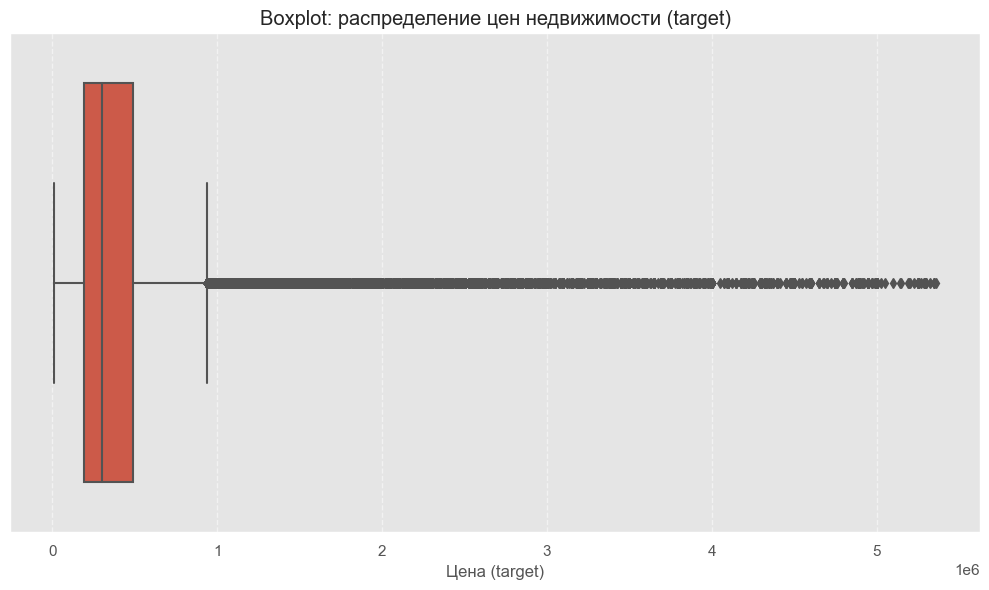

In [115]:
# Сначала вызываем функцию очистки

# Затем строим график
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['target'])

plt.title('Boxplot: распределение цен недвижимости (target)')
plt.xlabel('Цена (target)')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


У нас сохранились выбросы, но это связано с тем,что у всех штатов своя медиана и большие цифры в общем котле конечно считаются выбросами.
цены уже сместиллись до 4 миллионов

# Возращаемся к столбцу df.fireplace. 
Восстанавливаем пропущенные значения через df.propertyType_clean

In [116]:
# Убедимся, что значения приведены к нижнему регистру
df['fireplace'] = df['fireplace'].astype(str).str.lower().replace('nan', np.nan)

# Заполнение по наиболее частому значению в группе
df['fireplace'] = df['fireplace'].fillna(
    df.groupby(['zipcode', 'propertyType_clean'])['fireplace'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

print(f"Процент пропущенных значений в 'fireplace': {df['fireplace'].isna().sum() / len(df) * 100:.2f}%\n")

Процент пропущенных значений в 'fireplace': 12.27%



Уменьшили процент пропущенных значений с 73% до 12%.         
Далее можно восстановить пропущенные значения через df.state и df.propertyType_clean

In [117]:
# Второй этап — по state и типу
df['fireplace'] = df['fireplace'].fillna(
    df.groupby(['state', 'propertyType_clean'])['fireplace'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)
print(f"Процент пропущенных значений в 'fireplace': {df['fireplace'].isna().sum() / len(df) * 100:.2f}%\n")

Процент пропущенных значений в 'fireplace': 0.51%



In [118]:
df['fireplace'].unique()

array(['1.0', '0.0', nan], dtype=object)

Оставшиеся значения заполню с помощью статистики по группам.

In [119]:
df['fireplace'] = pd.to_numeric(df['fireplace'], errors='coerce') 
df['fireplace'] = df['fireplace'].astype('Int64')  
print(f"Процент пропущенных значений в 'fireplace': {df['fireplace'].isna().sum() / len(df) * 100:.2f}%\n")

Процент пропущенных значений в 'fireplace': 0.51%



Не получилось изменить. Процент совсем маленький, удалять не хочется. Может быть важная информация.
Логично, если уже группировка по другим столбцам не дает результата, то можно оставшиесся значения просто преобразить 
np.nan == 0 

In [120]:
df['fireplace'].fillna(0, inplace=True)
print(f"Процент пропущенных значений в 'fireplace': {df['fireplace'].isna().sum() / len(df) * 100:.2f}%\n")

Процент пропущенных значений в 'fireplace': 0.00%



Отлично, у нас получилось избавиться от пропущенных значений.     
Посмотрим как меняется цена в разных штатах в зависимости от наличия камина

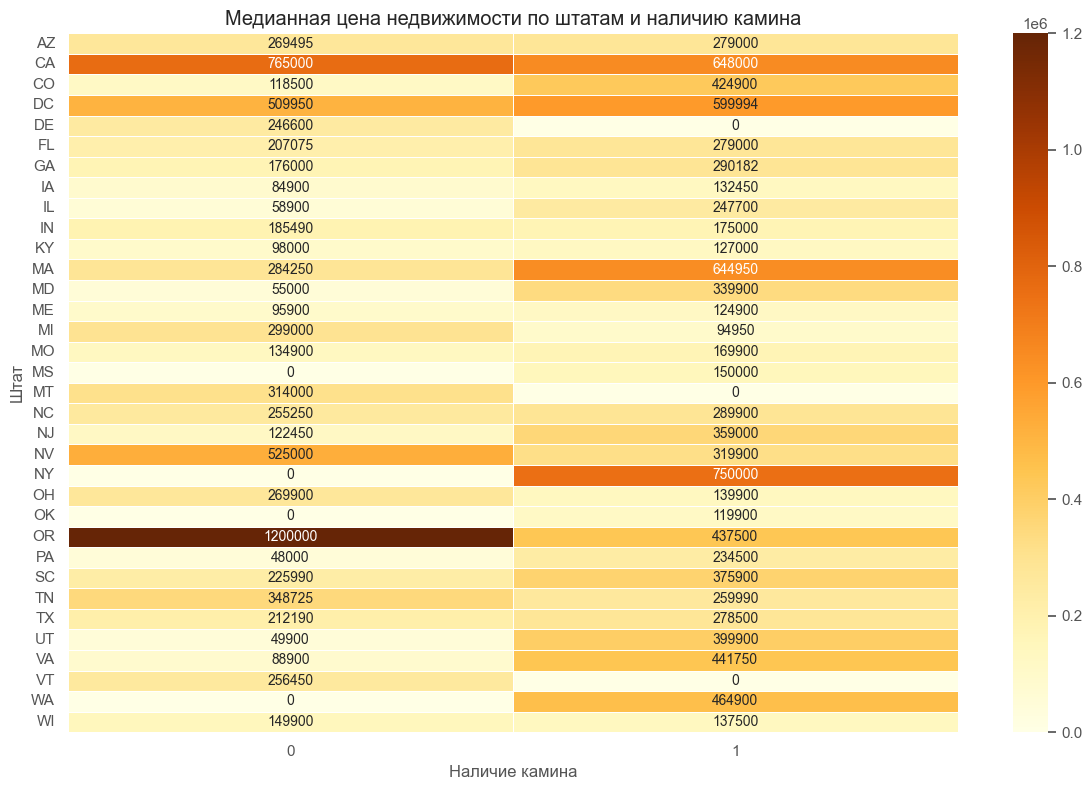

In [121]:
pivot = df.pivot_table(
    values='target',
    index='state',
    columns='fireplace',
    aggfunc='median'
).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrBr', linewidths=0.5)

plt.title('Медианная цена недвижимости по штатам и наличию камина')
plt.xlabel('Наличие камина')
plt.ylabel('Штат')
plt.tight_layout()
plt.show()

Видим 2 колонки. Там где 1 - цены в общем случае выше. Отлично. Зависимость есть. Идем дальше
Заметила один выброс в Орегоне. проверю

In [122]:
filtered_df = df[
    (df['state'] == 'OR') &
    (df['fireplace'] == 0) &
    (df['target'] > 1_000_000)
]

In [123]:
filtered_df

status   propertyType              street         baths  \
261405  For sale  single family  61610 Gribbling Rd  Bathrooms: 2   

                                                homeFacts  fireplace  city  \
261405  {'atAGlanceFacts': [{'factValue': '2011', 'fac...          0  Bend   

                                                  schools    sqft zipcode  \
261405  [{'rating': ['8/10', '5/10', '6/10'], 'data': ...  1988.0   97702   

        ... sqft_category_encoded baths_clean state_full state_0 state_1  \
261405  ...                   2.0           2     Oregon       0       0   

        state_2  state_3 state_4  state_5  propertyType_clean  
261405        1        0       1        0  single family home  

[1 rows x 28 columns]

Отлично, мы преобразили столбец. Убрали в конце концов пропущенные значения. Двигаемся дальше

Мишура, а не данные. Убрать!

In [124]:
df = df[~(
    (df['state'] == 'OR') &
    (df['fireplace'] == 0) &
    (df['target'] > 1_000_000)
)]

### Возвращаемся к столбцу df.beds	
У нас есть небольшое количество пропущенных значений. Постараемся заменить модой по типу недвижимости. 

In [125]:
# Медиана по типу недвижимости:
df['beds_clean'] = df.groupby('propertyType_clean')['beds_clean'].transform(
    lambda x: x.fillna(x.median())
)

In [126]:
df['beds_clean'].isna().sum()

0

In [127]:
df['beds_clean'].unique()

array([  4.,   2.,   3.,   5.,   6.,   7.,   1.,   0.,   8.,   9., 708.,
        14.,  12.,  64.,  15.,  10.,  16.,  20.,  11.,  18.,  47.,  23.,
        13.,  17.,  44.,  28.,  24.,  30., 360.,  42.,  22.,  21.,  46.])

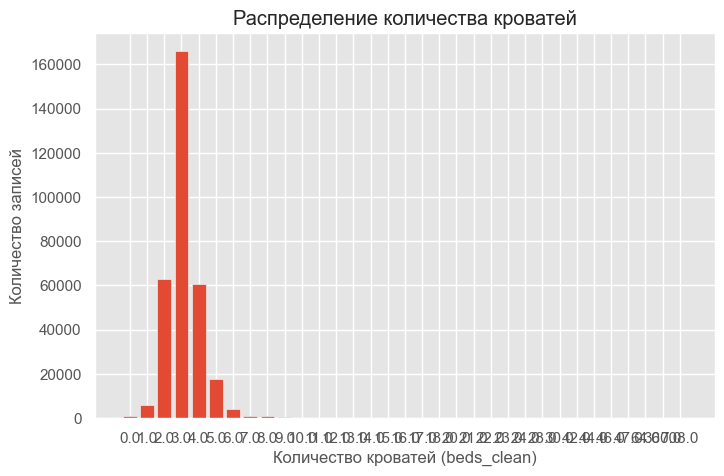

In [128]:

# Подсчёт количества каждого уникального значения в столбце
counts = df['beds_clean'].value_counts().sort_index()

# Вариант 1: matplotlib
plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Количество кроватей (beds_clean)')
plt.ylabel('Количество записей')
plt.title('Распределение количества кроватей')
plt.show()


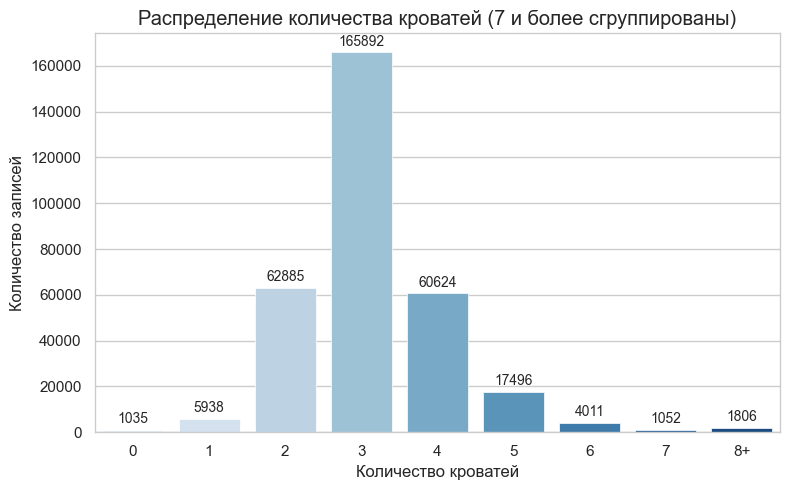

In [129]:
# Шаг 1: Преобразуем в числа (если ещё не сделано)
df['beds_clean'] = pd.to_numeric(df['beds_clean'], errors='coerce')

# Шаг 2: Ограничиваем — всё выше 7 превращаем в '8+'
def limit_beds_label(x):
    return str(int(x)) if x <= 7 else '8+'

df['beds_clean'] = df['beds_clean'].apply(limit_beds_label)

# Шаг 3: Группируем без value_counts
counts = df.groupby('beds_clean').size().reset_index(name='count')

# Шаг 4: Сортируем: от '1' до '7',
def sort_key(val):
    return int(val) if val.isdigit() else 8  

counts = counts.sort_values(by='beds_clean', key=lambda col: col.map(sort_key))

# Шаг 5: Визуализация
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x='beds_clean', y='count', data=counts, palette='Blues')

# Подписи над столбцами
for index, row in counts.iterrows():
    barplot.text(index, row['count'] + max(counts['count']) * 0.01, str(row['count']), 
                 ha='center', va='bottom')

plt.xlabel('Количество кроватей')
plt.ylabel('Количество записей')
plt.title('Распределение количества кроватей (7 и более сгруппированы)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Нормальное распределение
Самое частое количетсво кроватей это 3. 


Перевести этот признак в числовой формат. 

In [130]:
df['beds_clean'] = pd.to_numeric(df['beds_clean'], errors='coerce')
print(df['beds_clean'].dtypes)  # должно быть float или int
print(df['beds_clean'].isna().sum())  # сколько NaN появилось после конверсии

float64
1806


После появились пропуски. Их заполню модой для сохранения распределения и избежания нецелых чисел 

In [131]:
mode_value = int(df['beds_clean'].mode()[0])
df['beds_clean'] = df['beds_clean'].fillna(mode_value)

df['beds_clean'] = df['beds_clean'].astype(int)

In [132]:
print(df['beds_clean'].isna().sum())  # сколько NaN появилось после конверсии

0


### Переходим к столбцу df.status	

In [133]:
# Проверяем какие и сколько уникальных значений у нас
print(f"Количество уникальных значений в 'status': {df.status.nunique()}")  
print(f"Кол-во пропущенных значений в 'status': {df.status.isna().sum()}\n") 
print(f"Подсчет количества уникальных значений 'status': \n{df.status.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'status': 145
Кол-во пропущенных значений в 'status': 33223

Подсчет количества уникальных значений 'status': 
for sale                                48.032110
Active                                  28.983430
For sale                                13.592635
New construction                         1.684776
foreclosure                              1.620084
                                          ...    
Contingent   No Show                     0.000348
Lease/Purchase                           0.000348
Coming soon: Dec 27.                     0.000348
Reactivated                              0.000348
Under Contract Taking Back Up Offers     0.000348
Name: status, Length: 145, dtype: float64


In [134]:
df.status.unique()

array(['Active', 'New construction', 'for sale', 'Under Contract Show',
       'For sale', 'foreclosure', 'Pre-foreclosure / auction',
       'Foreclosure', 'Pending', ' / auction', 'pending', nan,
       'Foreclosed', 'Auction', 'Active/Contingent',
       'Under Contract - Show', 'Coming soon: Dec 14.',
       'Active Contingent', 'Coming soon: Dec 6.',
       'Under Contract - No Show', 'Contingent', 'Closed',
       'Uc Continue To Show', 'Coming soon: Dec 23.', 'P', 'C', 'Pi',
       'Pre-foreclosure', 'Pending Inspection', 'Pending In',
       'Contract P', 'Ct', 'Pf', 'Ps', 'Pending - Backup Offer Requested',
       'Active Under Contract', 'Contingent Show', 'Pending Bring Backup',
       'Coming soon: Nov 29.', 'Coming soon: Dec 24.',
       'Coming soon: Nov 14.', 'Coming soon: Dec 25.',
       'Pending (Do Not Show)', 'Coming soon: Nov 26.',
       'Coming soon: Dec 10.', 'Coming soon: Dec 5.',
       'Contingent   Release', 'Coming soon: Dec 7.',
       'Coming soon: Oct 29

In [135]:
# Приводим к нижнему регистру строки кроме NAN
df['status'] = df['status'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [136]:
# Пишем функцию для обработке столбца 
def normalize_status(x):
    if isinstance(x, str):
        x_lower = x.lower()
        if 'coming soon' in x_lower:
            return 'coming soon'
        elif any(keyword in x_lower for keyword in ['foreclosure', 'pre-foreclosure', 'foreclosed', 'auction']):
            return 'foreclosure'
        elif 'pending' in x_lower:
            return 'pending'
        elif 'p' in x_lower:
            return 'pending'
        elif 'contingent' in x_lower:
            return 'contingent'
        elif 'contingency' in x_lower:
            return 'contingency'
        elif any(keyword in x_lower for keyword in ['closed', 'sold', 'accepted offer']):
            return 'sold'
        elif 'active' in x_lower:
            return 'active'
        elif any(keyword in x_lower for keyword in ['back on market', 're activated', 'reactivated']):
            return 'back on market'
        elif 'under contract' in x_lower:
            return 'under contract'
        elif 'for sale' in x_lower:
            return 'for sale'
        elif 'new' in x_lower:
            return 'new construction'
    return x  # всё остальное остаётся без изменений

df['status'] = df['status'].apply(normalize_status)


In [137]:
df.status.value_counts()

for sale                177183
active                   84434
foreclosure               9821
pending                   7226
new construction          5511
under contract            2341
contingent                 669
back on market             111
coming soon                105
c                           37
listing extended            27
contingency                 22
c continue show             17
sold                         5
ct                           4
uc continue to show          2
conditional contract         1
Name: status, dtype: int64

Все равно много униркальных значений. Еще сократим. 

In [138]:
def normalize_status_group(x):
    if not isinstance(x, str):
        return x  # оставляем NaN и нестроковые без изменений
    
    x_lower = x.lower()
    
    active_set = {'active', 'coming soon', 'back on market', 'listing extended', 'new construction'}
    for_sale_set = {'for sale', 'pending', 'under contract', 'contingent', 'c', 'contingency',
                    'c continue show', 'ct', 'contract', 'conditional contract', 'uc continue to show', 'foreclosure'}
    other_set = {'sold', 'for rent', 'condo for rent'}
    
    # Проверяем принадлежность
    if any(status in x_lower for status in active_set):
        return 'active'
    elif any(status in x_lower for status in for_sale_set):
        return 'for sale'
    elif any(status in x_lower for status in other_set):
        return x_lower  # оставляем как есть: sold, for rent и т.д.
    else:
        return 'other'  # для прочих, если вдруг есть новые категории

# Применяем к df
df['status'] = df['status'].apply(normalize_status_group)

In [139]:
df.status.value_counts(normalize=True)*100

for sale    68.630268
active      31.367993
sold         0.001739
Name: status, dtype: float64

Посмотрим на пропуски 

In [140]:
pct_missing = df['status'].isna().sum() / len(df) * 100
print(f"Количество пропусков: {pct_missing:.2f}%")

Количество пропусков: 10.36%


10% умеренный показатель. 
Заполнять модой не будем. Есть вероятность сместить разброс, хоть и не существенно.
У нас 2-е самые большие категории - можно сделать иначе. 
Стратифицировать -заполнить пропуски распределённо, сохраняя исходные пропорции.

In [141]:
# Стратифицированная (пропорциональная) импутация
# заполнить пропуски распределённо, сохраняя исходные пропорции
# исходные вероятности
probs = {
    'for sale': 0.663262,
    'active':   0.334647,
    'for rent': 0.001180,
    'sold':     0.000910
}

# Превратим в два списка
keys = list(probs.keys())
vals = np.array(list(probs.values()), dtype=float)

# Нормируем так, чтобы сумма стала ровно 1
vals = vals / vals.sum()

# Используем в random.choice
mask = df['status'].isna()
df.loc[mask, 'status'] = np.random.choice(
    keys,
    size=mask.sum(),
    p=vals
)

df.status.value_counts(normalize=True)*100

for sale    68.402346
active      31.578947
for rent     0.009977
sold         0.008730
Name: status, dtype: float64

In [142]:
pct_missing = df['status'].isna().sum() / len(df) * 100
print(f"Количество пропусков: {pct_missing}%")

Количество пропусков: 0.0%


По категории df.status - очевидно.
Есть 4 уникальных признака, привалирует 2 категории означающие продажи.

Приварирует у нас 2-е категории - for sale и active.        

status: active и status: for sale —  в мире недвижимости hfpkbxf.ncz, особенно если данные приходят из MLS (Multiple Listing Service).       

Cуть:

🔹 For Sale  -    	Широкое обозначение: объект доступен для покупки       
Общее состояние, означающее, что недвижимость выставлена на продажу.


🔹 Active       -  Подкатегория: активно продаётся, без подписанного контракта  
Это технический статус в MLS, означающий:

1. Недвижимость активно продаётся
2. Агент принимает предложения
3. У объекта ещё нет подписанного договора

Закодируем этот признак. Это порядковый, так  есть четкая градация по этапам сделок.      
Расположим значения по степени часто встречаемого запроса в объявлении 

In [143]:
# Задаём порядок
status_order = ['for sale', 'active', 'sold', 'for rent']

# Создаём словарь соответствий
status_map = {status: idx for idx, status in enumerate(status_order)}

# Применяем кодировку
df['status'] = df['status'].map(status_map)


### Переходим к столбцу df.schools

In [144]:
df.schools.nunique()

253659

In [145]:
df.schools.unique()

array(['[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]',
       '[{\'rating\': [\'5/10\', \'3/10\', \'4/10\'], \'data\': {\'Distance\': [\'2.4 mi\', \'2.4 mi\', \'1.9 mi\'], \'Grades\': [\'PK-5\', \'6-8\', \'9-12\']}, \'name\': [\'Parkwood Elementary\', "Lowe\'s Grove Middle", \'Hillside High\']}]',
       "[{'rating': ['5/10', '10/10', '6/10'], 'data': {'Distance': ['4.28mi', '1.2mi', '3.38mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Mint Hill Middle School', 'Bain Elem

In [146]:
# Преобразуем строку в список словарей
df['schools'] = df['schools'].apply(ast.literal_eval)

# Взрываем список школ в отдельные строки
df_exploded = df.explode('schools').reset_index(drop=True)

# Преобразуем каждый словарь в отдельные столбцы
schools_expanded = json_normalize(df_exploded['schools'])

#Добавим суффикс "_schools" ко всем названиям колонок
schools_expanded.columns = [f"{col}_schools" for col in schools_expanded.columns]

# Объединяем с исходным DataFrame (без колонки 'schools')
df = pd.concat([df_exploded.drop(columns=['schools']), schools_expanded], axis=1)

In [147]:
# Переименовываем столбцы  для удобства
df= df.rename(columns={
    'data.Distance_schools': 'distance_schools',
    'data.Grades_schools': 'grades_schools'
})

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320739 entries, 0 to 320738
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   status                 320739 non-null  int64   
 1   propertyType           292057 non-null  object  
 2   street                 320738 non-null  object  
 3   baths                  237483 non-null  object  
 4   homeFacts              320739 non-null  object  
 5   fireplace              320739 non-null  Int64   
 6   city                   320737 non-null  object  
 7   sqft                   320739 non-null  float64 
 8   zipcode                320738 non-null  object  
 9   beds                   252190 non-null  object  
 10  state                  320739 non-null  object  
 11  stories                201671 non-null  object  
 12  mls-id                 22908 non-null   object  
 13  MlsId                  261156 non-null  object  
 14  target              

### Переходим к столбцу df.rating_schools

In [149]:
# Каждый элемент списка в строке превращается в отдельную строку
df_exploded = df.explode('rating_schools')
df_exploded['rating_schools'].unique()


array(['4', '7', 'NR', '5/10', '3/10', '4/10', '10/10', '6/10', '9', '5',
       '6', '3', '8', '1', '2', '7/10', '8/10', '9/10', '1/10', '10',
       '2/10', nan, 'None/10', 'NA', ''], dtype=object)

In [150]:
# Приводим мстолбец к единому формату
def clean_rating(value):
    if pd.isna(value) or value in ['NA', 'NR', 'None/10', '']:
        return np.nan
    elif isinstance(value, str) and '/10' in value:
        try:
            return int(value.split('/')[0])
        except:
            return np.nan
    else:
        try:
            return int(value)
        except:
            return np.nan

# Применяем очистку
df['rating_schools'] = df['rating_schools'].apply(
    lambda x: [clean_rating(val) for val in x] if isinstance(x, list) else np.nan
)


In [151]:
df.head(3)

status        propertyType                                  street  \
0       1  single family home                          240 Heather Ln   
1       1       single family                    5315 Fayetteville Rd   
2       0  single family home  Armstrong Plan in Cadence at Mint Hill   

       baths                                          homeFacts  fireplace  \
0        3.5  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1          3  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
2  2.5 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   

             city    sqft zipcode    beds  ... state_1 state_2 state_3  \
0  Southern Pines  2900.0   28387       4  ...       0       0       0   
1          Durham  2375.0   27713       4  ...       0       0       0   
2       Mint Hill  1731.0   28227  2 Beds  ...       0       0       0   

  state_4  state_5  propertyType_clean                  rating_schools  \
0       0        1  single family home  [4, 4, 7, nan, 4, 7, nan, nan]   
1       0        1  single family home                       [5, 3, 4]   
2       0        1  single family home                      [5, 10, 6]   

                                        name_schools  \
0  [Southern Pines Elementary School, Southern Mi...   
1  [Parkwood Elementary, Lowe's Grove Middle, Hil...   
2  [Mint Hill Middle School, Bain Elementary, Ind...   

                                    distance_schools  \
0  [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...   
1                           [2.4 mi, 2.4 mi, 1.9 mi]   
2                            [4.28mi, 1.2mi, 3.38mi]   

                                  grades_schools  
0  [3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]  
1                              [PK-5, 6-8, 9-12]  
2                               [6-8, K-5, 9-12]  

[3 rows x 31 columns]

In [152]:
# Считаем срений рейтинг по школам. 
df['mean_rating_schools'] = df['rating_schools'].apply(
    lambda x: round(np.nanmean(x), 1) if isinstance(x, list) and not all(pd.isna(x)) else np.nan
)

In [153]:
print(f"Процент пропущенных значений: {df['mean_rating_schools'].isna().sum() / len(df) * 100:.2f}%")


Процент пропущенных значений: 1.15%


In [154]:
# Процент пропущенных значений не так велик. Можно заполнит средней по штату
df['mean_rating_schools'] = df.groupby('state')['mean_rating_schools'].transform(lambda x: x.fillna(x.mean()))

print(f"Процент пропущенных значений: {df['mean_rating_schools'].isna().sum() / len(df) * 100:.2f}%")

Процент пропущенных значений: 0.00%


In [155]:
# Удаляем ненужный столбец
df.drop(columns='rating_schools', inplace=True)

### Переходим к столбцу df.distance_schools


In [156]:
# Переходим к столбцу df.distance_schools
df.distance_schools

0         [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...
1                                  [2.4 mi, 2.4 mi, 1.9 mi]
2                                   [4.28mi, 1.2mi, 3.38mi]
3                  [0.3 mi, 2.5 mi, 6.3 mi, 6.3 mi, 6.3 mi]
4                                  [1.1 mi, 3.8 mi, 3.4 mi]
                                ...                        
320734                     [0.1 mi, 0.1 mi, 0.1 mi, 4.5 mi]
320735                             [1.4 mi, 4.5 mi, 3.6 mi]
320736                             [1.4 mi, 4.5 mi, 3.6 mi]
320737                             [1.4 mi, 4.5 mi, 3.6 mi]
320738                             [6.3 mi, 0.6 mi, 7.7 mi]
Name: distance_schools, Length: 320739, dtype: object

In [157]:

def median_distance(dist_list):
    """
    Принимает список строк вроде ['2.7 mi', '1.65mi', ...],
    возвращает медиану расстояний в милях (float) или NaN, если список пуст или некорректен.
    """
    distances = []
    for v in dist_list:
        if isinstance(v, str):
            # убираем 'mi' и лишние пробелы, конвертим в float
            try:
                num = float(v.lower().replace('mi', '').strip())
                distances.append(num)
            except ValueError:
                continue
    if not distances:
        return np.nan
    return float(np.median(distances))

# Применяем к столбцу и создаём новый столбец с медианой
df['median_distance_schools'] = df['distance_schools'].apply(median_distance)

# Проверим пару первых строк
print(df['median_distance_schools'].head())

0    3.80
1    2.40
2    3.38
3    6.30
4    3.40
Name: median_distance_schools, dtype: float64


In [158]:
df['median_distance_schools'].isna().sum()/len(df)*100

0.9172567102846862

In [159]:
# Заполняем мелдтаной пропуски их не много
df['median_distance_schools'].fillna(df['median_distance_schools'].median(), inplace=True)

In [160]:
print(df['median_distance_schools'].unique().tolist())

[3.8, 2.4, 3.38, 6.3, 3.4, 4.4, 2.85, 1.35, 1.6, 1.79, 1.86, 1.73, 1.0, 1.06, 2.11, 3.1, 1.2, 2.05, 0.37, 1.1, 4.13, 0.76, 1.62, 4.3, 1.34, 2.95, 1.7000000000000002, 6.2, 3.0, 3.7, 1.9, 1.72, 3.15, 2.25, 1.5, 2.6, 2.2, 1.68, 0.59, 8.2, 1.69, 1.7, 2.0, 1.65, 1.51, 3.27, 0.9500000000000001, 4.77, 0.7, 0.75, 3.8499999999999996, 2.5, 1.4, 5.5, 1.3, 2.9, 3.2, 0.36, 1.1849999999999998, 1.57, 0.9, 2.74, 1.75, 2.0149999999999997, 0.8500000000000001, 3.85, 2.8, 2.67, 2.3, 0.6950000000000001, 2.18, 1.58, 3.5, 2.8499999999999996, 5.74, 1.85, 6.34, 2.15, 0.8, 3.75, 7.73, 1.26, 3.05, 2.65, 7.1, 6.68, 0.63, 2.59, 5.1, 2.31, 1.425, 1.12, 2.1, 1.9849999999999999, 2.7, 2.71, 1.95, 2.73, 4.9, 4.85, 5.8, 3.14, 2.09, 1.45, 17.1, 3.95, 4.7, 2.5999999999999996, 0.47, 1.08, 2.27, 1.2000000000000002, 1.17, 4.49, 1.19, 1.82, 0.2, 1.9000000000000001, 0.91, 2.02, 3.9, 1.0499999999999998, 1.97, 9.2, 0.5, 1.25, 1.52, 2.54, 1.09, 1.8, 4.14, 3.98, 2.855, 0.79, 4.0, 6.0, 0.87, 1.785, 1.15, 3.35, 2.24, 6.67, 2.705, 2.

In [161]:
df['median_distance_schools'].describe()

count    320739.000000
mean          2.316843
std           5.669751
min           0.000000
25%           0.890000
50%           1.500000
75%           2.600000
max        1591.020000
Name: median_distance_schools, dtype: float64

Уменьшим количество уникальных значений в признаке median_distance_schools,    
группируем значения по диапазонами исходя из stats значений выше (bins):

In [162]:
# Градация на основе describe()
def categorize_distance(val):
    if pd.isna(val):
        return np.nan
    elif val == 0:
        return 0
    elif val <= 0.5:
        return 0.5
    elif val <= 1:
        return 1
    elif val <= 1.5:
        return 1.5
    elif val <= 2:
        return 2
    elif val <= 3:
        return 3
    elif val <= 5:
        return 5
    elif val <= 10:
        return 10
    elif val <= 20:
        return 20
    else:
        return 100  # условно обозначим всё, что выше 20 км

df['median_distance_schools'] = df['median_distance_schools'].apply(categorize_distance)



In [163]:
df['median_distance_schools'].value_counts()

1.0      71176
1.5      61813
3.0      49389
2.0      42308
5.0      36300
0.5      31191
10.0     19837
20.0      8097
100.0      619
0.0          9
Name: median_distance_schools, dtype: int64

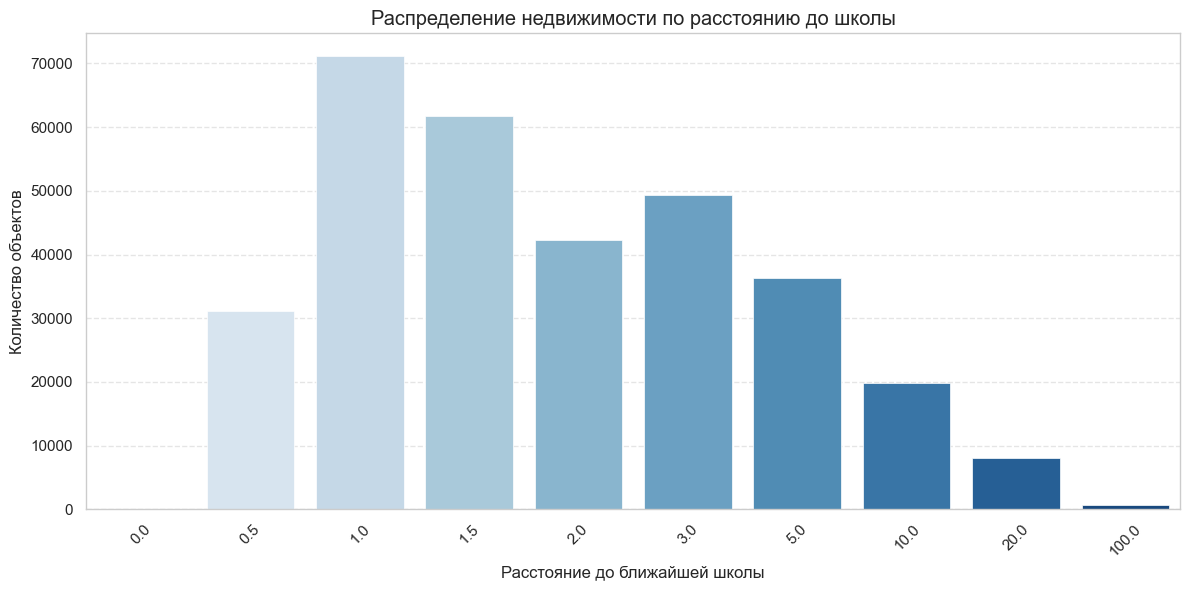

In [164]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='median_distance_schools', palette='Blues')

plt.title('Распределение недвижимости по расстоянию до школы')
plt.xlabel('Расстояние до ближайшей школы')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Есть явные выбросы. расстояния свыше  50 мили 


In [165]:
df.loc[df['median_distance_schools'] > 50, 'state'].value_counts()

TX    461
FL     89
NV     51
TN      8
CA      4
NC      3
IL      1
UT      1
CO      1
Name: state, dtype: int64

In [166]:
df.loc[df['median_distance_schools'] > 50, 'propertyType_clean'].value_counts()

single family home     516
lot                     65
house                   23
apartment                9
mobile manufactured      3
other                    3
Name: propertyType_clean, dtype: int64

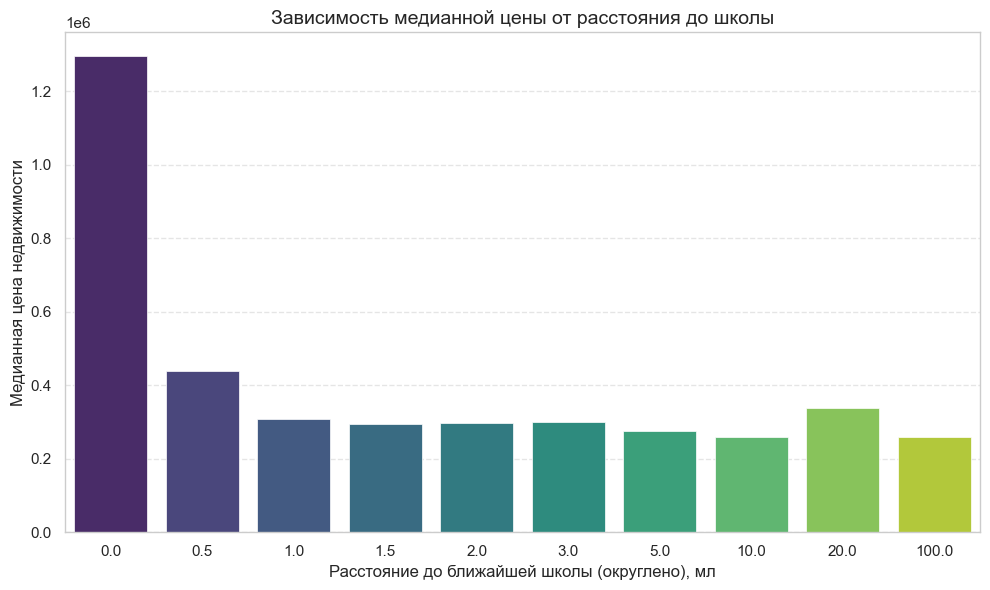

In [167]:
# Группировка: медианная цена по каждой группе расстояния
grouped = df.groupby('median_distance_schools')['target'].median().reset_index()

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x='median_distance_schools', y='target', palette='viridis')

plt.title('Зависимость медианной цены от расстояния до школы', fontsize=14)
plt.xlabel('Расстояние до ближайшей школы (округлено), мл')
plt.ylabel('Медианная цена недвижимости')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Чем ближе заведения,тем дороже жилье. Есть интересные скачки в районе 0, 20 и 100 миль. Проверим

In [168]:
zero_distance_rows = df[df['median_distance_schools'] == 0]

# Посмотреть, сколько таких строк
print(f"Количество записей, где median_distance_schools == 0: {len(zero_distance_rows)}")

# Если хочешь — вывести сами строки
zero_distance_rows

Количество записей, где median_distance_schools == 0: 9


status propertyType                     street baths  \
239936       1    townhouse  255 W 113 St Unit Harlem    NaN   
240954       1          NaN         MLS #: DEGI3649222   NaN   
241117       1          NaN         MLS #: UCOM1848787   NaN   
242531       1          NaN         MLS #: DEGI3988791   NaN   
242679       1          NaN         MLS #: CCRI1828810   NaN   
243262       1          NaN         MLS #: DOMU1841203   NaN   
243520       1          NaN          MLS #: SOTH784745   NaN   
244156       1          NaN        MLS #: HALS19867891   NaN   
259829       1          NaN            922 Lincoln Pl    NaN   

                                                homeFacts  fireplace  \
239936  {'atAGlanceFacts': [{'factValue': '1890', 'fac...          1   
240954  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
241117  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
242531  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
242679  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
243262  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
243520  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
244156  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
259829  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   

            city    sqft zipcode  beds  ... state_2 state_3 state_4 state_5  \
239936  New York  3600.0   10026  Bath  ...       1       0       0       1   
240954  New York  1817.0   10025   NaN  ...       1       0       0       1   
241117  New York  1817.0   10025   NaN  ...       1       0       0       1   
242531  New York  1817.0   10025   NaN  ...       1       0       0       1   
242679  New York  1817.0   10025   NaN  ...       1       0       0       1   
243262  New York  1817.0   10025   NaN  ...       1       0       0       1   
243520  New York  1817.0   10025   NaN  ...       1       0       0       1   
244156  New York  1817.0   10025   NaN  ...       1       0       0       1   
259829  Brooklyn  1817.0   11213   NaN  ...       1       0       0       1   

        propertyType_clean                                       name_schools  \
239936               house  [Stem Institute of Manhattan, Success Academy ...   
240954               house  [PS 163 Alfred E Smith, Solomon Schechter Scho...   
241117               house  [PS 163 Alfred E Smith, Solomon Schechter Scho...   
242531               house  [PS 163 Alfred E Smith, Solomon Schechter Scho...   
242679               house  [PS 163 Alfred E Smith, Solomon Schechter Scho...   
243262               house  [PS 84 Lilian Weber, PS 333 Manhattan School F...   
243520               house  [PS 163 Alfred E Smith, Solomon Schechter Scho...   
244156               house  [PS 165 Robert E Simon, Ascension School, Mott...   
259829   multi family home  [PS 138, Educational Institute Onolei, Educati...   

                        distance_schools  \
239936  [0.0 mi, 0.0 mi, 0.0 mi, 0.1 mi]   
240954  [0.2 mi, 0.0 mi, 0.0 mi, 0.0 mi]   
241117  [0.2 mi, 0.0 mi, 0.0 mi, 0.0 mi]   
242531  [0.2 mi, 0.0 mi, 0.0 mi, 0.0 mi]   
242679  [0.2 mi, 0.0 mi, 0.0 mi, 0.0 mi]   
243262  [0.2 mi, 0.0 mi, 0.0 mi, 0.0 mi]   
243520  [0.2 mi, 0.0 mi, 0.0 mi, 0.0 mi]   
244156  [0.0 mi, 0.0 mi, 0.0 mi, 0.1 mi]   
259829  [0.4 mi, 0.0 mi, 0.0 mi, 0.0 mi]   

                                           grades_schools  \
239936                 [K to 5, K to 4, 6 to 12, 6 to 12]   
240954   [Preschool to 5, K to 8, K to 8, Preschool to 8]   
241117   [Preschool to 5, K to 8, K to 8, Preschool to 8]   
242531   [Preschool to 5, K to 8, K to 8, Preschool to 8]   
242679   [Preschool to 5, K to 8, K to 8, Preschool to 8]   
243262           [Preschool to 5, K to 8, 6 to 8, 6 to 8]   
243520   [Preschool to 5, K to 8, K to 8, Preschool to 8]   
244156   [Preschool to 8, Preschool to 8, 6 to 8, K to 8]   
259829  [Preschool to 8, Preschool to 12, Preschool to

 10025 (Upper West Side, NYC) — это действительно дорогой и престижный район с высоким качеством жизни.
  Школа находится прямо по тому же адресу, что и объект недвижимости
→ Часто в dataset'ах, если школа находится буквально в том же здании или на той же улице, расстояние округляется до 0.

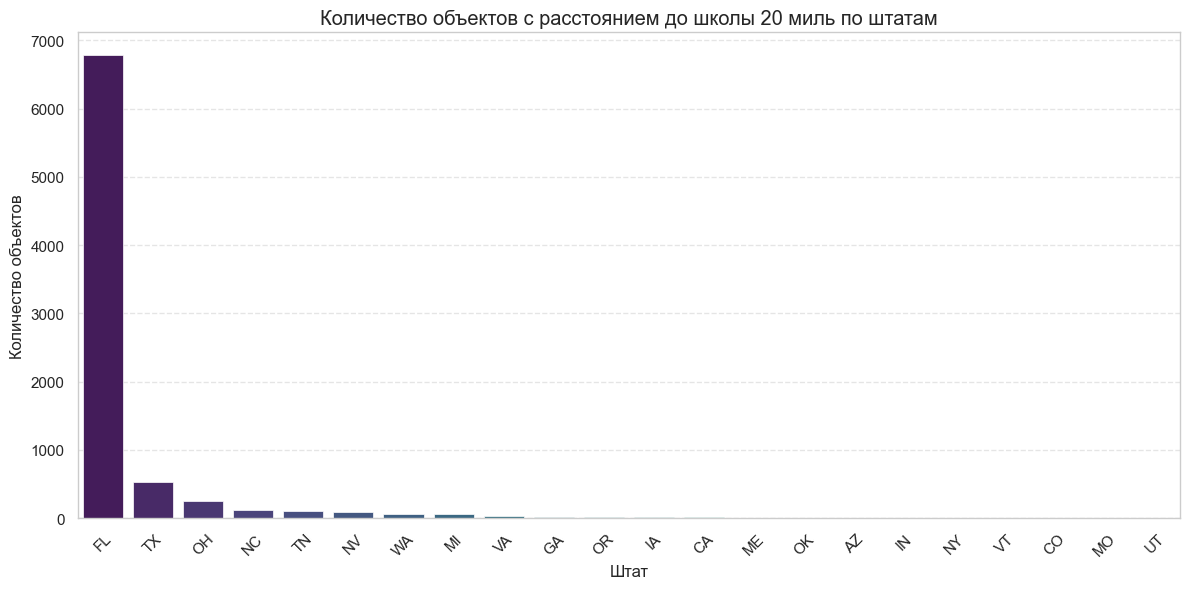

In [169]:

# Фильтр по расстоянию 20.0
filtered = df[df['median_distance_schools'] == 20.0]

# Подсчёт объектов по штатам
state_counts = filtered['state'].value_counts().sort_values(ascending=False)

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')

plt.title('Количество объектов с расстоянием до школы 20 миль по штатам')
plt.xlabel('Штат')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


В таких больших и разнородных по плотности населённых пунктах, как во Флориде, расстояние около 20 миль (примерно 32 км) от дома до школы — это не редкость, особенно если речь о сельских или пригородных районах.

В густонаселённых городах, вроде Майами или Орландо, школы обычно ближе, но высокая цена жилья поблизости заставляет людей селиться дальше, из-за чего commute (поездка на работу или учебу) может быть длительной — 20 миль и более.

Так что:

* 20 миль — это достаточно обычное расстояние для многих районов Флориды.
* В городах школы обычно ближе, но из-за доступности жилья люди могут ездить дальше.
* В сельских и отдалённых районах такое расстояние вполне стандартное.

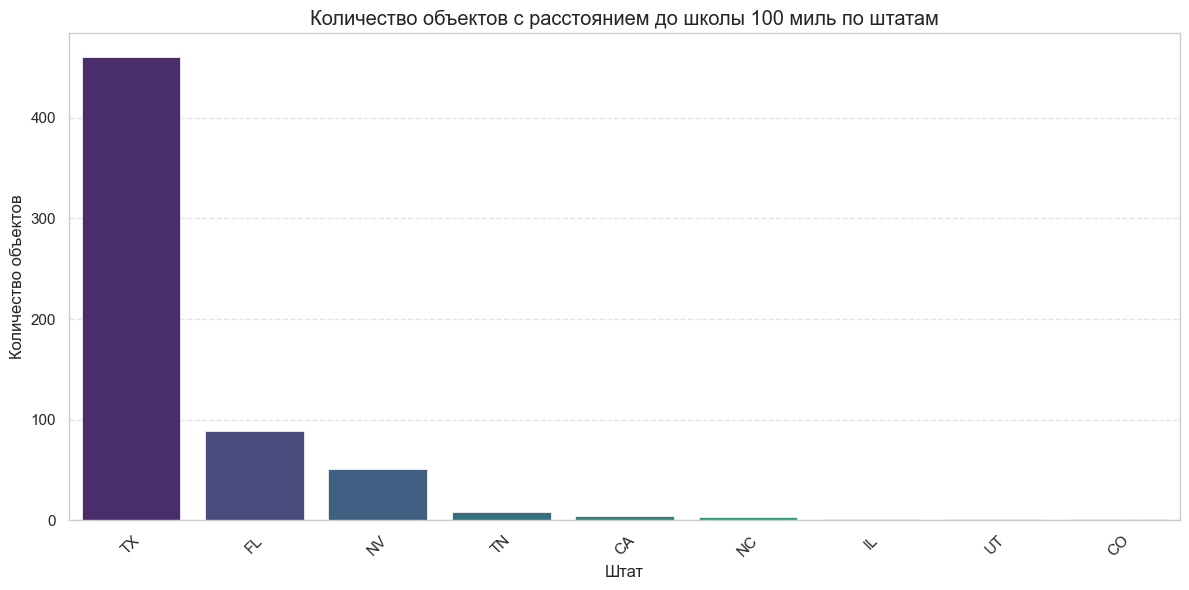

In [170]:

# Фильтр по расстоянию 20.0
filtered = df[df['median_distance_schools'] == 100.0]

# Подсчёт объектов по штатам
state_counts = filtered['state'].value_counts().sort_values(ascending=False)

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')

plt.title('Количество объектов с расстоянием до школы 100 миль по штатам')
plt.xlabel('Штат')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Таже система, что и во Флориде. 

In [171]:
df.drop(columns='distance_schools', inplace=True)

### Переходим к столбцу df.grades_schools

In [172]:
def normalize_grade_range(grade_list):
    if isinstance(grade_list, list):
        return [g.replace(' to ', '-') if isinstance(g, str) else g for g in grade_list]
    return grade_list

df['grades_schools'] = df['grades_schools'].apply(normalize_grade_range)

In [173]:
df['grades_schools']

0         [3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]
1                                     [PK-5, 6-8, 9-12]
2                                      [6-8, K-5, 9-12]
3                          [K-5, 6-8, 9-12, 9-12, 9-12]
4                                      [K-5, 6-8, 9-12]
                              ...                      
320734                           [PK–6, 7–8, 9–12, 1–7]
320735                                [PK-5, 6-8, 9-12]
320736                                [PK-5, 6-8, 9-12]
320737                                [PK-5, 6-8, 9-12]
320738                                [PK-5, 6-8, 9-12]
Name: grades_schools, Length: 320739, dtype: object


Чтобы вытащить все уникальные значения из списков, 
хранящихся в столбце grades_schools (например, ['3–5', '6–8', '9–12'] и т.п.), нужно

* убедиться, что значения — это списки (list), а не строки.
* "расплющить" (flatten) все списки в один.
* превратить в множество set() для получения уникальных значений.
* исключить None/NaN из множества перед сортировкой:

In [174]:
from itertools import chain

# Собираем уникальные значения, исключая None/NaN
unique_grades = set(
    g for grade_list in df['grades_schools']
    if isinstance(grade_list, list)
    for g in grade_list
    if g is not None and isinstance(g, str)
)

# Теперь сортировка сработает
print(sorted(unique_grades))

['1-10', '1-11', '1-12', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '10-12', '10–10', '10–11', '10–12', '11-12', '11–11', '11–12', '12', '12–12', '1–1', '1–10', '1–11', '1–12', '1–2', '1–3', '1–4', '1–5', '1–6', '1–7', '1–8', '1–9', '2-11', '2-12', '2-3', '2-4', '2-5', '2-6', '2-8', '2–12', '2–2', '2–3', '2–4', '2–5', '2–6', '2–7', '2–8', '2–9', '3', '3-11', '3-12', '3-4', '3-5', '3-5, 10', '3-6', '3-8', '3–10', '3–11', '3–12', '3–4', '3–5', '3–6', '3–7', '3–8', '4-12', '4-5', '4-6', '4-7', '4-8', '4-9', '4–10', '4–11', '4–12', '4–4', '4–5', '4–6', '4–7', '4–8', '4–9', '5', '5-10', '5-11', '5-12', '5-6', '5-7', '5-8', '5-9', '5–10', '5–11', '5–12', '5–5', '5–6', '5–7', '5–8', '5–9', '6', '6-10', '6-11', '6-12', '6-7', '6-8', '6-8, 10', '6-9', '6–10', '6–11', '6–12', '6–6', '6–7', '6–8', '6–9', '7', '7-10', '7-11', '7-12', '7-8', '7-9', '7–10', '7–11', '7–12', '7–7', '7–8', '7–9', '8', '8-10', '8-12', '8-9', '8–10', '8–11', '8–12', '8–8', '8–9', '9', '9-10', '9-11', '9-12', '9–10'

In [175]:
def categorize_grade_range(gr):
    if not isinstance(gr, str):
        return 'unknown'
    
    gr = gr.replace('–', '-')  # нормализуем тире
    gr = gr.upper().strip()

    if 'NA' in gr or gr == '':
        return 'unknown'
    if 'PRESCHOOL' in gr or 'PK' in gr:
        if re.fullmatch(r'PK(-\d+)?', gr) or 'PK-' in gr:
            return 'preschool'
    if gr in ['K', 'K-K'] or gr.startswith('K-') or gr.startswith('K–'):
        return 'elementary'
    if re.match(r'^[1-5](-[1-5])?$', gr):
        return 'elementary'
    if re.match(r'^[5-8](-[5-8])?$', gr):
        return 'middle'
    if re.match(r'^9(-1[0-2])?$', gr) or gr in ['10-12', '11-12', '12']:
        return 'high'
    if re.search(r'K-12|PK-12|1-12', gr):
        return 'K12'
    if ',' in gr or ' ' in gr:
        return 'other/mixed'
    return 'other/mixed'


In [176]:
df['grades_schools'] = df['grades_schools'].apply(
    lambda lst: [categorize_grade_range(g) for g in lst] if isinstance(lst, list) else ['unknown']
)

# При желании можно также сделать сводку:
#from collections import Counter
#all_cats = [cat for sublist in df['grade_category'] for cat in sublist]
#Counter(all_cats)

In [177]:
df['total_num_grades_schools'] = df['grades_schools'].apply(len)


In [178]:
df['total_num_grades_schools'].value_counts()

3     182713
2      31077
8      28029
5      24855
4      20517
6       8337
1       7428
7       7010
0       2942
24      1719
63       748
22       741
10       733
13       706
11       640
9        522
12       504
14       359
65       347
49       272
15       245
61       117
16        86
21        77
26         8
17         6
19         1
Name: total_num_grades_schools, dtype: int64

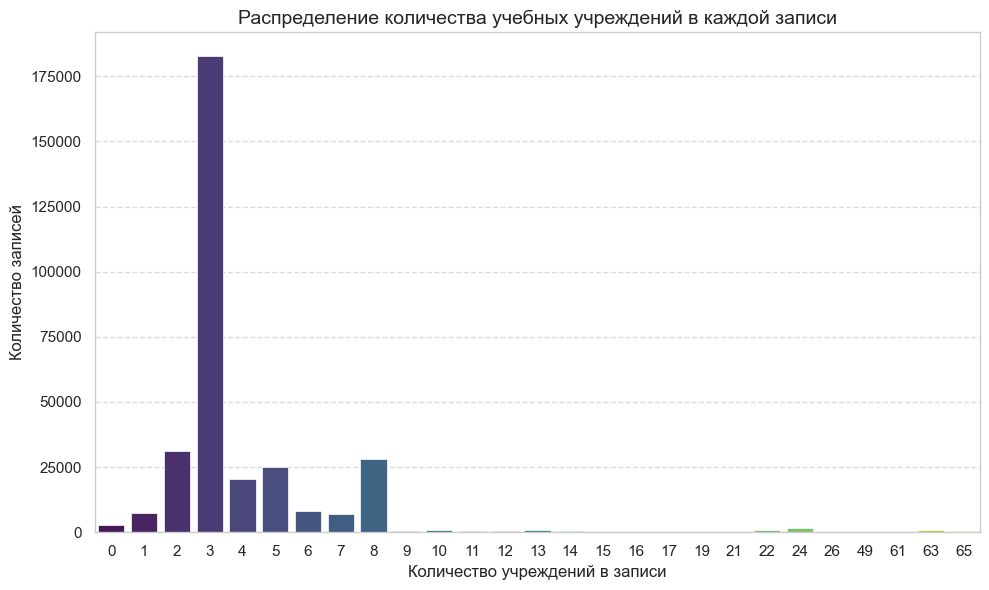

In [179]:

# Подсчет количества
counts = df['total_num_grades_schools'].value_counts().sort_index()

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette="viridis")

plt.title('Распределение количества учебных учреждений в каждой записи', fontsize=14)
plt.xlabel('Количество учреждений в записи')
plt.ylabel('Количество записей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [180]:
df['total_num_grades_schools']

0         8
1         3
2         3
3         5
4         3
         ..
320734    4
320735    3
320736    3
320737    3
320738    3
Name: total_num_grades_schools, Length: 320739, dtype: int64

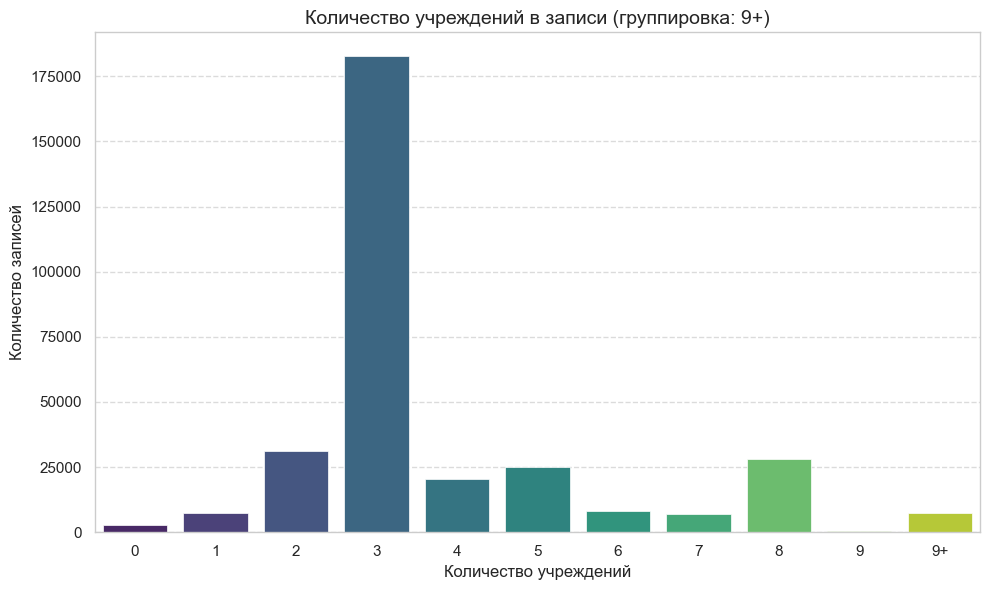

In [181]:
# Создание меньшего количество школ
df['total_num_grades_schools'] = pd.to_numeric(df['total_num_grades_schools'], errors='coerce')

# Теперь можно применить фильтрацию
df['total_num_grades_schools'] = df['total_num_grades_schools'].apply(lambda x: '9+' if x > 9 else x)

# Подсчет значений
counts = df['total_num_grades_schools'].value_counts()
counts = counts.sort_index(key=lambda x: x.map(lambda y: int(y) if y != '9+' else 999))

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index.astype(str), y=counts.values, palette="viridis")

plt.title('Количество учреждений в записи (группировка: 9+)', fontsize=14)
plt.xlabel('Количество учреждений')
plt.ylabel('Количество записей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Чаще всего есть 3 заведения в доступности. Это прям очень хорошо. Социальнвй фактор у недвижимочти прям хорош

в принципе не удивительно, так как большинство записей о недвижимости это FL и TX

In [182]:
# Удаляем столбец 
df = df.drop(['name_schools', 'grades_schools'], axis=1)


### Переходим к столбцу df.city

In [183]:
# Проверяем какие и сколько уникальных значений у нас
print(f"Количество уникальных значений в 'city': {df.city.nunique()}")  
print(f"Кол-во пропущенных значений в 'city': {df.city.isna().sum() / len(df) * 100:.2f}%\n") 
print(f"Подсчет количества уникальных значений 'city': \n{df.city.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'city': 1857
Кол-во пропущенных значений в 'city': 0.00%

Подсчет количества уникальных значений 'city': 
Houston                  6.488182
San Antonio              4.545780
Miami                    4.149817
Jacksonville             2.902690
Dallas                   2.200557
                           ...   
Downtown Pgh             0.000312
Silver Springs Shores    0.000312
ST PETE                  0.000312
ODESSA                   0.000312
New Albany               0.000312
Name: city, Length: 1857, dtype: float64


Сразу заполним пропуски по городам

In [184]:
zip_to_city = df.dropna(subset=['city']).groupby('zipcode')['city'].agg(lambda x: x.mode()[0])
df['city'] = df['city'].fillna(df['zipcode'].map(zip_to_city))
print(f"Кол-во пропущенных значений в 'city': {df.city.isna().sum() / len(df) * 100:.2f}%\n") 

Кол-во пропущенных значений в 'city': 0.00%



Пишем корректирующую функцию для столбика df.city

In [185]:

corrections = {
    'losouth angeles': 'los angeles',
    'sanorth diego': 'san diego',
    'sanorth jose': 'san jose',
    'wesaint hollywood': 'west hollywood',
    'wesaint covina': 'west covina',
    'easaint boston': 'east boston',
    'easaint cleveland': 'east cleveland',
    'easaint elmhurst': 'east elmhurst',
    'easaint flatbush': 'east flatbush',
    'county losouth angeles': 'los angeles county',
    'foreignorth country': 'foreign country',
    'pt saint lucie': 'port saint lucie',
    'saint pete': 'saint petersburg',
    'brownsouth summit': 'brown summit',
    'sunorth valley': 'sun valley',
    'wesaint palm beach': 'west palm beach',
    'north lasouth vegas': 'north las vegas',
    'mt washington': 'mount washington',
    'corpusouth christi': 'corpus christi',
    'sanorth francisco': 'san francisco',
    'sanorth bernardino': 'san bernardino',
    'sanorth marino': 'san marino',
    'sanorth mateo': 'san mateo',
    'sanorth gabriel': 'san gabriel',
    'sanorth pedro': 'san pedro',
    'sanorth lorenzo': 'san lorenzo',
    'sanorth ysidro': 'san ysidro',
    'easaint harlem': 'east harlem',
    'easaint fultonham': 'east fultonham',
    'losouth gatos': 'los gatos',
    'losouth fresnos': 'los fresnos',
    'wesaint miami': 'west miami',
    'wesaint park': 'west park',
    'wesaint lake hills': 'west lake hills',
    'wesaint university place': 'west university place',
    'wesaint seneca': 'west seneca',
    'wesaint valley city': 'west valley city',
    'north port': 'north port',
    'north miami': 'north miami',
    'north hollywood': 'north hollywood',
    'north redingtonorth beach': 'north redington beach',
    'north las vegas': 'north las vegas',
    'north miami beach': 'north miami beach',
    'southwesaint ranches': 'southwest ranches',
    'south ozone park': 'south ozone park',
    'south miami': 'south miami',
    'south houston': 'south houston',
    'south euclid': 'south euclid',
    'south pasadena': 'south pasadena',
    'south richmond hill': 'south richmond hill',
    'south salt lake': 'south salt lake',
    'north bay village': 'north bay village',
    'north lauderdale': 'north lauderdale',
    'north hills': 'north hills',
    'north syracuse': 'north syracuse'
}

def normalize_city(city):
    if not isinstance(city, str) or not city.strip() or city.strip() == '--':
        return np.nan
    city = city.strip().lower()
    city = city.replace('ft.', 'fort').replace('ft ', 'fort ')
    city = city.replace('st.', 'saint').replace('st ', 'saint ')
    city = city.replace('  ', ' ')
    # применим словарь точечных замен
    city = corrections.get(city, city)
    return city.title()

df['city'] = df['city'].apply(normalize_city)

In [186]:
df['city'].nunique()

1734

In [187]:
unique_values = df['city'].unique()

unique_values_list = unique_values.tolist()   

print(unique_values_list)

['Southern Pines', 'Durham', 'Mint Hill', 'Charlotte', 'Pineville', 'Winston Salem', 'Raleigh', 'Wilmington', 'Wesley Chapel', 'Huntersville', 'Fayetteville', 'Gastonia', 'Mooresville', 'Cherryville', 'Mount Holly', 'Matthews', 'Asheville', 'Cleveland', 'Concord', 'High Pt', 'Greenville', 'Saluda', 'Hickory', 'Weddington', 'Statesville', 'Greensboro', 'Mocksville', 'Jacksonville', 'Dallas', 'Cary', 'High Point', 'Oak Ridge', 'Apex', 'Winterville', 'Burlington', 'Hope Mills', 'Cooleemee', 'Midway Park', 'Stallings', 'Biltmore Forest', 'Nashville', 'Knightdale', 'Eastover', 'Clemmons', 'Archdale', 'Mebane', 'Belmont', 'Chimney Rock', 'Pfafftown', 'Mc Leansville', 'Jamestown', 'Wake Forest', 'Candler', 'Kernersville', 'Kannapolis', 'Crouse', 'Mount Gilead', 'Asheville City', 'Bessemer City', 'Bahama', 'Browns Summit', 'Leicester', 'Morrisville', 'Garner', 'Caldwell', 'Hillsborough', 'Chapel Hill', 'Midland', 'Biscoe', 'Iron Station', nan, 'Whitsett', 'Salisbury', 'Indian Trail', 'Uninc', 

In [188]:
df['city'] = df['city'].str.lower()

In [189]:
df['city'].value_counts()

houston          20810
san antonio      14580
miami            13314
jacksonville      9327
dallas            7060
                 ...  
pooler               1
vinings              1
atlaanta             1
cockrell hill        1
park slope           1
Name: city, Length: 1734, dtype: int64

Тут все ясно, те же города, что и штаты, тот же рассклад. Скорее всего большая корреляция будет 

### Переходим к столбцу df.street

In [190]:
# Проверяем какие и сколько уникальных значений у нас
print(f"Количество уникальных значений в 'street': {df.street.nunique()}")  
print(f"Кол-во пропущенных значений в 'street': {df.street.isna().sum() / len(df) * 100:.2f}%\n") 
print(f"Подсчет количества уникальных значений 'street': \n{df.street.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'street': 288343
Кол-во пропущенных значений в 'street': 0.00%

Подсчет количества уникальных значений 'street': 
Address Not Disclosed              0.191122
Undisclosed Address                0.139366
(undisclosed Address)              0.107564
Address Not Available              0.038349
Unknown Address                    0.019954
                                     ...   
9737 Whitehurst Dr #1              0.000312
1200 Main St APT 2607              0.000312
1616 Fountain View Dr #601         0.000312
1604 Morgan Ln # B                 0.000312
108 38 N. St.&flamingo St # 108    0.000312
Name: street, Length: 288343, dtype: float64


Из признака df.street извлечем тип улицы. Это может быть прокси- признаком района,   
 плотности застройки или уровня жилья.    
  Вот примеры:    

* St	Street	-	доступное жильё
* Ave	Avenue	-	средний класс
* Blvd	Boulevard	-	выше среднего
* Ln	Lane	-   элитное / редкое
* Dr	Drive	-	дорогое жильё
* Ct	Court	-	уединённость
* Pl	Place	-	умеренно
* Rd    Road    -   нейтральный или средний класс

In [191]:
# Подменяем все unknown значения на np.nan
df['street'] = df['street'].replace(
    to_replace=r'\b(s|e|lots|collection|disclos\w*|unknown\w*|avail\w*|address\w*)\b',
    value=np.nan,
    regex=True
)

In [192]:
# Пишем функцию для прокси-признака типов улиц
# Словарь типов улиц
valid_street_types = {
    'st', 'street',
    'ave', 'avenue',
    'blvd', 'boulevard',
    'ln', 'lane',
    'dr', 'drive',
    'ct', 'court',
    'pl', 'place',
    'rd', 'road',
    'cir', 'circle',
    'trl', 'trail',
    'pkwy', 'parkway',
    'way', 'way',
    'loop', 'loop',
    'ter', 'terrace',
    'hwy', 'highway',
    'path', 'path',
    'xing', 'crossing',
    'cv', 'cove',
    'aly', 'alley',
    'row', 'row',
    'run', 'run',
    'pass', 'pike', 'bnd', 'point', 'ridge', 'rdg',
    'crk', 'cyn', 'trce', 'vw', 'hl', 'hill',
    'valley', 'estates', 'farms', 'oaks'
}

def extract_street_type_fixed(street):
    if not isinstance(street, str):
        return np.nan
    # разбиваем адрес на слова, удаляем точки и приводим к нижнему регистру
    parts = [re.sub(r'[^\w]', '', p).lower() for p in street.strip().split()]
    parts = [p for p in parts if p]  # убираем пустые

    # проверяем с конца на наличие валидного типа улицы
    for token in reversed(parts):
        if token in valid_street_types:
            return token
    return np.nan  # если ничего не найдено

df['street_type'] = df['street'].apply(extract_street_type_fixed)


In [193]:
df['street_type'].value_counts()

st           71000
dr           54911
ave          53333
rd           25484
ln           19607
ct           15508
blvd         10814
pl            8324
way           8187
cir           7258
ter           4454
trl           2830
pkwy          1565
loop          1222
cv             818
road           754
hwy            721
drive          695
avenue         668
ridge          567
pass           438
run            412
oaks           396
rdg            385
lane           375
highway        374
estates        354
pike           336
bnd            332
point          274
valley         268
crk            268
path           256
crossing       244
street         240
court          202
trce           191
farms          189
trail          187
place          169
xing           162
circle         160
cyn            152
hill           151
vw             146
hl             134
row            111
aly            102
cove            68
boulevard       51
terrace         47
parkway         33
alley       

In [194]:
street_type_map = {
    'street': 'st',
    'st': 'st',
    'avenue': 'ave',
    'ave': 'ave',
    'boulevard': 'blvd',
    'blvd': 'blvd',
    'lane': 'ln',
    'ln': 'ln',
    'drive': 'dr',
    'dr': 'dr',
    'court': 'ct',
    'ct': 'ct',
    'place': 'pl',
    'pl': 'pl',
    'road': 'rd',
    'rd': 'rd',
    'circle': 'cir',
    'cir': 'cir',
    'trail': 'trl',
    'trl': 'trl',
    'terrace': 'ter',
    'ter': 'ter',
    'parkway': 'pkwy',
    'pkwy': 'pkwy',
    'loop': 'loop',
    'way': 'way',
    'highway': 'hwy',
    'hwy': 'hwy',
    'path': 'path',
    'crossing': 'xing',
    'xing': 'xing',
    'cove': 'cv',
    'cv': 'cv',
    'alley': 'aly',
    'aly': 'aly',
    'row': 'row',
    'run': 'run'
}

df['street_type'] = df['street_type'].map(street_type_map)

In [195]:
df['street_type'].value_counts(normalize=True)*100

st      24.451523
dr      19.085505
ave     18.534625
rd       9.005601
ln       6.858371
ct       5.392103
blvd     3.729166
pl       2.915031
way      2.810003
cir      2.546061
ter      1.544867
trl      1.035517
pkwy     0.548477
loop     0.419424
hwy      0.375834
cv       0.304100
run      0.141410
xing     0.139350
path     0.087866
row      0.038098
aly      0.037069
Name: street_type, dtype: float64

In [196]:
print(f"Количество уникальных значений в 'street_type': {df.street_type.nunique()}")  
print(f"Кол-во пропущенных значений в 'street_type': {df.street_type.isna().sum() / len(df) * 100:.2f}%\n") 
print(f"Подсчет количества уникальных значений 'street_type': \n{df.street_type.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'street_type': 21
Кол-во пропущенных значений в 'street_type': 9.16%

Подсчет количества уникальных значений 'street_type': 
st      24.451523
dr      19.085505
ave     18.534625
rd       9.005601
ln       6.858371
ct       5.392103
blvd     3.729166
pl       2.915031
way      2.810003
cir      2.546061
ter      1.544867
trl      1.035517
pkwy     0.548477
loop     0.419424
hwy      0.375834
cv       0.304100
run      0.141410
xing     0.139350
path     0.087866
row      0.038098
aly      0.037069
Name: street_type, dtype: float64


Восстановление street_type через ZIP-код    
В каждом zipcode найти самый частый street_type    
Проставить его для всех строк, где street_type = NaN      

In [197]:
# Находим моду (наиболее частое значение) для каждого ZIP
zip_type_mode = (
    df[df['street_type'].notna()]
    .groupby('zipcode')['street_type']
    .agg(lambda x: x.value_counts().idxmax())
)

# Заполняем пропущенные значения на основе zip
df['street_type'] = df['street_type'].fillna(df['zipcode'].map(zip_type_mode))

print(f"Пропущенные значения: {df['street_type'].isna().sum()}")


Пропущенные значения: 120


Заполним оставшиеся значения модой по наиболее частым значением по каждому городу.

In [198]:
# Группируем по городу и заполняем пропуски модой в пределах группы
df['street_type'] = df.groupby('city')['street_type'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)

print(f"Пропущенные значения: {df['street_type'].isna().sum()}")


Пропущенные значения: 59


Посмотрим на наши пропуски в разрезе цены и штата. Насколько безопасно удалять

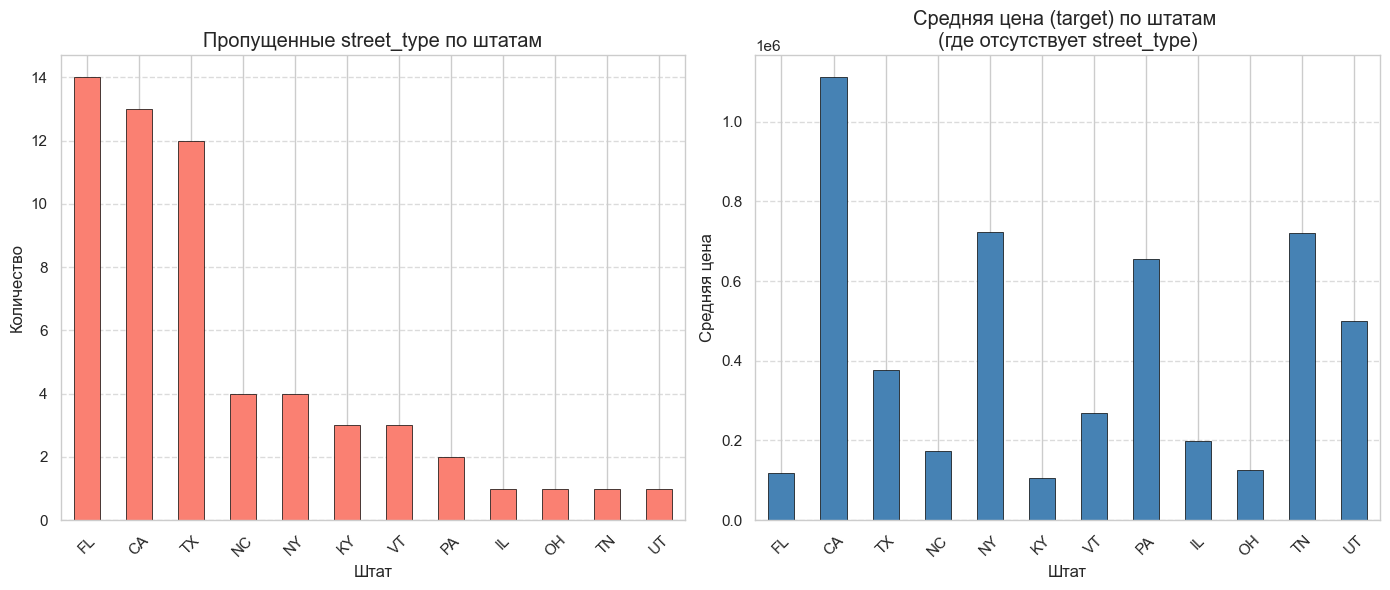

In [199]:

# Отбираем строки с пропущенным street_type
missing_street_type = df[df['street_type'].isna()]

# Группировка по 'state'
missing_count_by_state = missing_street_type.groupby('state').size().sort_values(ascending=False)
avg_price_by_state = missing_street_type.groupby('state')['target'].mean().loc[missing_count_by_state.index]

# Построим 2 графика рядом
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Количество пропусков
missing_count_by_state.plot(kind='bar', ax=axes[0], color='salmon', edgecolor='black')
axes[0].set_title('Пропущенные street_type по штатам')
axes[0].set_xlabel('Штат')
axes[0].set_ylabel('Количество')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# График 2: Средняя цена
avg_price_by_state.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Средняя цена (target) по штатам \n(где отсутствует street_type)')
axes[1].set_xlabel('Штат')
axes[1].set_ylabel('Средняя цена')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Судя по статистике, тут затясался явный выброс и мы его нашли 

In [200]:
df[df['state'] == 'CA']['target'].describe()


count    2.067500e+04
mean     7.972218e+05
std      5.441733e+05
min      1.000000e+04
25%      4.034810e+05
50%      6.498880e+05
75%      1.039309e+06
max      3.325000e+06
Name: target, dtype: float64

In [201]:
missing_ca = missing_street_type[missing_street_type['state'] == 'CA']['target']
missing_ca

31575     392490.0
36419     177687.0
37208     376490.0
37834    1795000.0
40744    1099900.0
41986    2295000.0
42234     899990.0
45527     850000.0
46139    1269000.0
46283    1229000.0
47226    1419000.0
47295    1299000.0
47332    1339000.0
Name: target, dtype: float64

Сюда попал один выброс.    
Спокойно удаляем строки с пропусками.

In [202]:
df = df[~df['street_type'].isna()]


In [203]:
# Группиркем по цене и выводим закономерности
df.groupby('street_type')['target'].mean().sort_values(ascending=False)

street_type
row     681775.865546
xing    518420.747826
st      492360.230857
pl      444571.462860
cv      437112.971735
ave     431447.364696
blvd    415149.903700
ter     403582.168585
pkwy    398205.059412
way     376873.071721
aly     369687.900901
ct      363253.608647
path    351733.937500
loop    346046.489879
dr      337494.361687
ln      337138.243135
cir     333735.851393
rd      316569.105790
hwy     309243.911290
trl     302128.949229
run     268730.341943
Name: target, dtype: float64

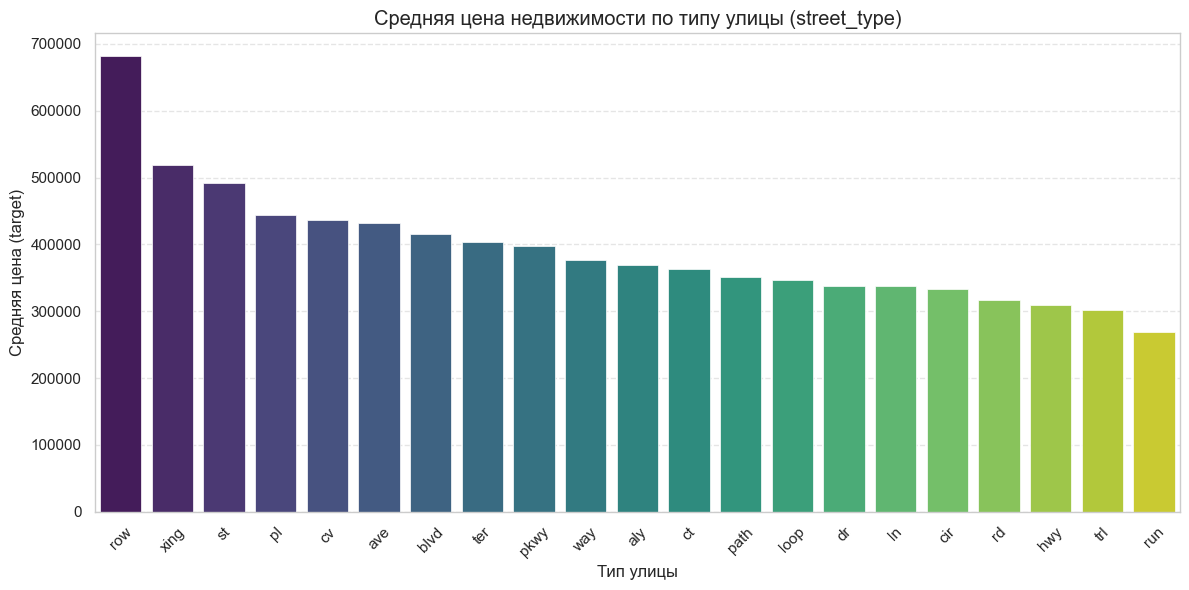

In [204]:
# Группировка и расчёт среднего
grouped = df.groupby('street_type')['target'].mean().sort_values(ascending=False)

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped.index, y=grouped.values, palette='viridis')

plt.title('Средняя цена недвижимости по типу улицы (street_type)')
plt.xlabel('Тип улицы')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Все выровнилось. Хорошо

###  Переходим к столбику df.homeFacts

In [205]:
df.homeFacts

0         {'atAGlanceFacts': [{'factValue': '2019', 'fac...
1         {'atAGlanceFacts': [{'factValue': '2019', 'fac...
2         {'atAGlanceFacts': [{'factValue': '', 'factLab...
3         {'atAGlanceFacts': [{'factValue': '2018', 'fac...
4         {'atAGlanceFacts': [{'factValue': '2006', 'fac...
                                ...                        
320734    {'atAGlanceFacts': [{'factValue': '1972', 'fac...
320735    {'atAGlanceFacts': [{'factValue': '2018', 'fac...
320736    {'atAGlanceFacts': [{'factValue': '', 'factLab...
320737    {'atAGlanceFacts': [{'factValue': '', 'factLab...
320738    {'atAGlanceFacts': [{'factValue': '2018', 'fac...
Name: homeFacts, Length: 320680, dtype: object

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320680 entries, 0 to 320738
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   status                    320680 non-null  int64   
 1   propertyType              292013 non-null  object  
 2   street                    320426 non-null  object  
 3   baths                     237447 non-null  object  
 4   homeFacts                 320680 non-null  object  
 5   fireplace                 320680 non-null  Int64   
 6   city                      320680 non-null  object  
 7   sqft                      320680 non-null  float64 
 8   zipcode                   320679 non-null  object  
 9   beds                      252150 non-null  object  
 10  state                     320680 non-null  object  
 11  stories                   201645 non-null  object  
 12  mls-id                    22903 non-null   object  
 13  MlsId                     261

In [207]:
#Это строки с вложенным JSON/словари, можно распарсить ast.literal_eval"
#import ast

df['homeFacts'] = df['homeFacts'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [208]:
print(df['homeFacts'].iloc[0])

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}


In [209]:
def extract_facts(row):
    
    if not isinstance(row, dict):
        return {}
    facts = row.get('atAGlanceFacts', [])
    return {
        fact.get('factLabel'): fact.get('factValue')
        for fact in facts if isinstance(fact, dict)
    }

facts_df = df['homeFacts'].apply(extract_facts).apply(pd.Series)
df = pd.concat([df, facts_df], axis=1)

In [210]:

df.head(2)

status        propertyType                street baths  \
0       1  single family home        240 Heather Ln   3.5   
1       1       single family  5315 Fayetteville Rd     3   

                                           homeFacts  fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   

             city    sqft zipcode beds  ... median_distance_schools  \
0  southern pines  2900.0   28387    4  ...                     5.0   
1          durham  2375.0   27713    4  ...                     3.0   

  total_num_grades_schools street_type Year built  Remodeled year  \
0                        8          ln       2019                   
1                        3          rd       2019            None   

                  Heating  Cooling  Parking     lotsize Price/sqft  
0  Central A/C, Heat Pump                          None       $144  
1              Forced air  Central  No Data  0.36 acres       $168  

[2 rows x 38 columns]

### Переходим к столбику df.Price/sqft

Price/sqft может вызвать data leakage,если хотим предсказывать цену на недвижимость.Поэтому удалим столбец. 

Но сначала проверим его на предмет выбросов. У нас есть цены очень низкие.
Если цена df.target ниже 1 кв метра, значит это точно выброс. Квартира не может так стоить. 


In [211]:
#Переименую столбец для удобства
df.rename(columns={'Price/sqft': 'sqrt_price'}, inplace=True)


In [212]:
print(f"Количество уникальных значений в 'sqrt_price': {df.sqrt_price.nunique()}")  
print(f"Кол-во пропущенных значений в 'sqrt_price': {df.sqrt_price.isna().sum() / len(df) * 100:.2f}%\n") 
print(f"Подсчет количества уникальных значений 'sqrt_price': \n{df.sqrt_price.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'sqrt_price': 4435
Кол-во пропущенных значений в 'sqrt_price': 11.67%

Подсчет количества уникальных значений 'sqrt_price': 
                   1.572032
No Data            0.327963
$125/sqft          0.279245
$115/sqft          0.269360
$132/sqft          0.268654
                     ...   
$1,676/sqft        0.000353
$2,329/sqft        0.000353
$1183 / Sq. Ft.    0.000353
$1,485/sqft        0.000353
$134,950           0.000353
Name: sqrt_price, Length: 4435, dtype: float64


Напишем функцию очистки столбца от мишуры. Оставим только числа

In [213]:
def extract_price(value):
    if isinstance(value, str):
        # Убираем символы $, ',', '/sqft', ' / Sq. Ft.', 'sqft', 'Sq. Ft.' и т.п.
        cleaned = (
            value.replace('$', '')
                 .replace(',', '')
                 .replace('/sqft', '')
                 .replace(' / Sq. Ft.', '')
                 .replace('Sq. Ft.', '')
                 .replace('/ Sq.Ft.', '')
                 .strip()
        )
        # Пропускаем текст вроде "No Data", "No Info"
        if cleaned.lower() in ['no data', 'no info', '']:
            return np.nan
        try:
            return int(float(cleaned))
        except ValueError:
            return np.nan
    elif isinstance(value, (int, float)):
        return int(value)
    return np.nan

# Применяем функцию к столбцу
df['sqrt_price'] = df['sqrt_price'].apply(extract_price)


In [214]:

invalid_rows = df[df['target'] < df['sqrt_price']]

# Сколько таких строк?
count_invalid = len(invalid_rows)

print(f"Количество строк, где target < sqrt_price: {count_invalid}")

Количество строк, где target < sqrt_price: 0


Аномалий не нашли. Идем дальше.Удаляем столбец. 

In [215]:
df.drop(columns=['sqrt_price'], inplace=True)

### Переходим к столбикам df.Cooling и df.Heating

In [216]:
print(f"Количество уникальных значений в 'Cooling': {df.Cooling.nunique()}")  
print(f"Кол-во пропущенных значений в 'Cooling': {df.Cooling.isna().sum() / len(df) * 100:.2f}%\n") 
print(f"Подсчет количества уникальных значений 'Cooling': \n{df.Cooling.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'Cooling': 1264
Кол-во пропущенных значений в 'Cooling': 0.53%

Подсчет количества уникальных значений 'Cooling': 
Central                                              43.640274
                                                     29.737034
Central Air                                           4.232607
No Data                                               2.998658
Has Cooling                                           2.532479
                                                       ...    
No A/C, No Heat, Other (See Remarks), Window Unit     0.000314
Panel/Floor/Wall, Space Heater                        0.000314
Gas Jets, Window Unit                                 0.000314
Additional Water Heater(s), Geotherm, Zoned           0.000314
2 Units, Central AC                                   0.000314
Name: Cooling, Length: 1264, dtype: float64


In [217]:
# Извлекаем уникальные значения из столбца и переносим в список
unique_values = df['Cooling'].unique()

unique_values_list = unique_values.tolist()   

print(unique_values_list)

['', 'Central', 'g-Energy Star HVAC, g-Fresh Air Ventilation, Gas (Hot Air), Heat Pump for A/C, Multi-Zone A/C, Multi-Zone Heat, Natural Gas', 'Central Air, Gas (Hot Air)', 'Central Air', 'Central Air, Gas Hot Air/Furnace', 'Central Air, Gas Hot Air/Furnace, Multizone A/C', 'No Data', 'Central Air, Gas (Hot Air), Gas (Water Heater), Natural Gas', 'Central Air, Gas (Water Heater)', 'Central Air, Multizone A/C', 'Heat Pump - AC, Multizone A/C', 'None', 'Gas Hot Air/Furnace', 'Heat Pump - AC', 'Wall-Unit A/C', 'Central Air, Heat Pump - AC', 'Central Air, Multizone A/C, Natural Gas', 'Heat Pump for A/C, Heat Pump for Heat', 'Gas Hot Air/Furnace, Multizone A/C', 'Other', 'Central Air, Gas Hot Air/Furnace, Natural Gas', 'Other (See Remarks)', 'Central Air, Gas (Hot Air), Multi-Zone A/C, Multi-Zone Heat', 'Central Air, Gas (Hot Air), Gas (Water Heater)', 'g-Energy Star HVAC, Multizone A/C', 'Central, Wall', 'Window Unit', 'Gas (Floor Furnace)', 'Central Air, Gas Hot Air/Furnace, Multizone A/C

In [218]:
(df['Cooling'].isna() | (df['Cooling'].str.strip() == '')).sum()

96558

##### Проверяем Heating

In [219]:
print(f"Количество уникальных значений в 'Heating': {df.Heating.nunique()}")  
print(f"Кол-во пропущенных значений в 'Heating': {df.Heating.isna().sum() / len(df) * 100:.2f}%\n") 
print(f"Подсчет количества уникальных значений 'Heating': \n{df.Heating.value_counts(normalize=True)*100}") 

Количество уникальных значений в 'Heating': 1745
Кол-во пропущенных значений в 'Heating': 0.53%

Подсчет количества уникальных значений 'Heating': 
                                   25.784699
Forced Air                         22.937462
Forced air                         14.259380
Other                               8.128825
Electric                            2.667599
                                     ...    
Master Closet-Electric              0.000314
storage by parking lot-tankless     0.000314
Next wall-Rinnai Tankless           0.000314
Utility Room-Gas Tankless           0.000314
3+ Units                            0.000314
Name: Heating, Length: 1745, dtype: float64


In [220]:
# Извлекаем уникальные значения из столбца и переносим в список
unique_values = df['Heating'].unique()

unique_values_list = unique_values.tolist()   

print(unique_values_list)

['Central A/C, Heat Pump', 'Forced air', '', 'Forced Air', 'Heat Pump', ', Gas Hot Air/Furnace', ', Heat Pump - Heat', 'Heat pump', 'Electric', ', Electric Hot Air, Heat Pump - Heat', ', Heat Pump - Heat, MultiZone Heat', 'Gas Hot Air/Furnace', 'Other', 'Forced air, Heat pump', ', Gas Hot Air/Furnace, MultiZone Heat', 'No Data', ', MultiZone Heat, Natural Gas', 'Wall', 'Gas', ', Electric Hot Air', ', Gas Hot Air/Furnace, Woodstove', ', Gas Hot Air/Furnace, Natural Gas', 'g-Energy Star HVAC, MultiZone Heat', 'Forced air, Other', 'Electric Hot Air', ', Gas Hot Air/Furnace, MultiZone Heat, Natural Gas', ', g-Fresh Air Ventilation, Gas Hot Air/Furnace, MultiZone Heat, Natural Gas', 'Gas Hot Air/Furnace, MultiZone Heat', ', Natural Gas', ', Gas Hot Air/Furnace, Gas Water Heater', 'Baseboard', 'Heat Pump - Heat', ', Gas Hot Air/Furnace, Gas Water Heater, MultiZone Heat', ', MultiZone Heat', ', Gas Hot Air/Furnace, Heat Pump - Heat, MultiZone Heat, Natural Gas', ', g-Geothermal', ', Gas Water

Пропущенных значений в обогревании больше заявленных. Смотрим сколько же

In [221]:
(df['Heating'].isna() | (df['Heating'].str.strip() == '')).sum()

83951

### Очень много пропущенных и в cooling и в heating.

Я один раз уже прошлась по данным и хотела оставить по 3 самых весомых значения в каждом столбике.
В результате вышло не хорошее рапспределение с целевым признаком target.     
Вот какие были результаты:


df.groupby('сooling_clean')['target'].mean()    
сooling_clean     
central    647232.355110     
other      617322.679901   
Name: target, dtype: float64    


df.groupby('heating_clean')['target'].mean()    
heating_clean    
electric      372098.067424   
forced_air    693985.352904   
other         642911.095630     

Скажем так- не очень хорошее распределение цены. 

Сейчас я увеличу долю ключевых слов, чтобы избежать подобного исхода.

Категория	Слова в Heating     
forced_air:	'forced air', 'central', 'furnace', 'hot air', 'gas hot air'    
electric	:'electric', 'electric baseboard', 'electric heat'   
heat_pump	:'heat pump', 'split system', 'mini split'   
radiant	:'radiant', 'baseboard', 'hot water', 'steam', 'boiler', 'radiator'    
wood/coal	:'wood', 'pellet', 'stove', 'coal', 'fireplace'    
other:	Всё остальное   

Также в дальнейшем разборе cooling - столбца, нала слова, которые относятся к столбцу Heating. 

1. Пройти по столбцу Cooling, найти строки, содержащие ключевые слова про отопление,
2. Перенести их в колонку Heating,
3. Заменить их в Cooling на np.nan.

In [222]:
def move_heating_from_cooling(df, cooling_col='Cooling', heating_col='Heating'):
    """
    Находит строки в cooling_col, которые содержат описание отопления,
    переносит их в heating_col и очищает cooling_col.
    """
    # Ключевые слова, указывающие на отопление
    heating_keywords = r'heat|heating|furnace|boiler|baseboard|radiator|gas|forced|hot water|steam|electric|stove'

    # Маска: Cooling содержит признаки отопления
    mask = df[cooling_col].astype(str).str.contains(heating_keywords, case=False, na=False)

    # Перенос значений
    df.loc[mask, heating_col] = df.loc[mask, cooling_col]
    df.loc[mask, cooling_col] = np.nan

    print(f' Перенесено {mask.sum()} строк из Cooling → Heating')

    return df

df = move_heating_from_cooling(df)

 Перенесено 27697 строк из Cooling → Heating


Хороший результат. Убрали мусор с cooling и дополнили heating. 

In [223]:
def simplify_heating_detailed(val):
    if pd.isna(val) or str(val).strip().lower() in ['', 'none', 'no data', 'nan']:
        return 'no_data'

    val = str(val).lower()

    if any(x in val for x in ['forced air', 'central', 'furnace', 'hot air', 'gas hot air']):
        return 'forced_air'
    elif 'heat pump' in val or 'split' in val or 'mini split' in val:
        return 'heat_pump'
    elif 'electric' in val:
        return 'electric'
    elif any(x in val for x in ['radiant', 'baseboard', 'hot water', 'steam', 'boiler', 'radiator']):
        return 'radiant'
    elif any(x in val for x in ['wood', 'stove', 'pellet', 'coal', 'fireplace']):
        return 'wood/coal'
    elif 'heating' in val or 'heat' in val:
        return 'other'  # распознаём, но не классифицируем явно
    else:
        return 'other'


🔍 Почему heat и heating → в 'other':
Потому что:

'heat' — слишком общее слово: "Baseboard Heat", "Electric Heat", "Steam Heat" — уже покрыты

Остальные случаи типа "Solar Heating" или "Unknown Heat" — лучше отправить в other, чем ошибочно классифицировать

In [224]:
df['heating_clean'] = df['Heating'].apply(simplify_heating_detailed)


In [225]:
df['heating_clean'].value_counts(normalize=True)*100

forced_air    52.064987
no_data       25.954222
other         13.503804
electric       3.568043
heat_pump      2.935637
radiant        1.924660
wood/coal      0.048647
Name: heating_clean, dtype: float64

Все равно много неизвестных данных   
Посмотрим как аггрегируется отопление с целевой переменной.    
Визуализируем данные   

In [226]:
heating_target = df.groupby('heating_clean')['target'].mean()

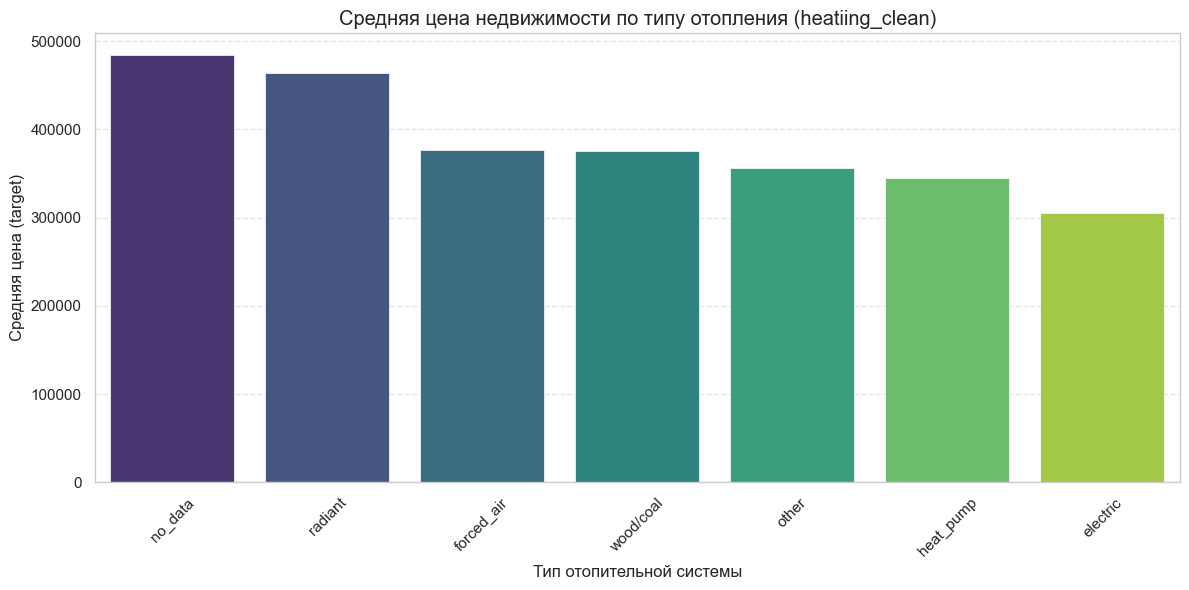

In [227]:
grouped_1= df.groupby('heating_clean')['target'].mean().sort_values(ascending=False)

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_1.index, y=grouped_1.values, palette='viridis')

plt.title('Средняя цена недвижимости по типу отопления (heatiing_clean)')
plt.xlabel('Тип отопительной системы')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


no_data — самая высокая цена.     
Эта информация влияет на формирование цены, а данных нет.


!!! Стратегия следующая       
Если заполнить heating_clean == 'no_data' по 'zipcode' наиболее часто встречающимся типом отопления,
то cможем:    
1.уменьшить пропуски   
2.восстановить ценную информацию     
3.избавиться от искажающего эффекта высокой средней цены у no_data (как на графике — 700K+)    

Заполнение heating_clean == 'no_data' по ZIP-кодам абсолютно оправдано, если в ZIP одна категория ≥ 0.7 (или 1.0).

In [228]:
# Построим частотную таблицу: распределение heating_clean по zip_code
heating_zip_counts = (
    df[df['heating_clean'] != 'no_data']
    .groupby('zipcode')['heating_clean']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

#  Отберем ZIP-коды, где одна категория отопления ≥ 70%
confident_heating_zip = heating_zip_counts[heating_zip_counts.max(axis=1) >= 0.7]

#  Словарь: zip_code → наиболее частая категория
zip_heating_map = confident_heating_zip.idxmax(axis=1).to_dict()

#  Функция для замены
def fill_heating_from_zip(row):
    if row['heating_clean'] == 'no_data':
        return zip_heating_map.get(row['zipcode'], 'no_data')
    return row['heating_clean']

#  Применение к датафрейму
df['heating_clean'] = df.apply(fill_heating_from_zip, axis=1)


In [229]:
df['heating_clean'].value_counts(normalize=True)*100

forced_air    65.644256
other         15.181177
no_data       10.512349
electric       3.636959
heat_pump      3.023887
radiant        1.952725
wood/coal      0.048647
Name: heating_clean, dtype: float64

Хороший результат. Сократили no-data c 28% до 11%. 

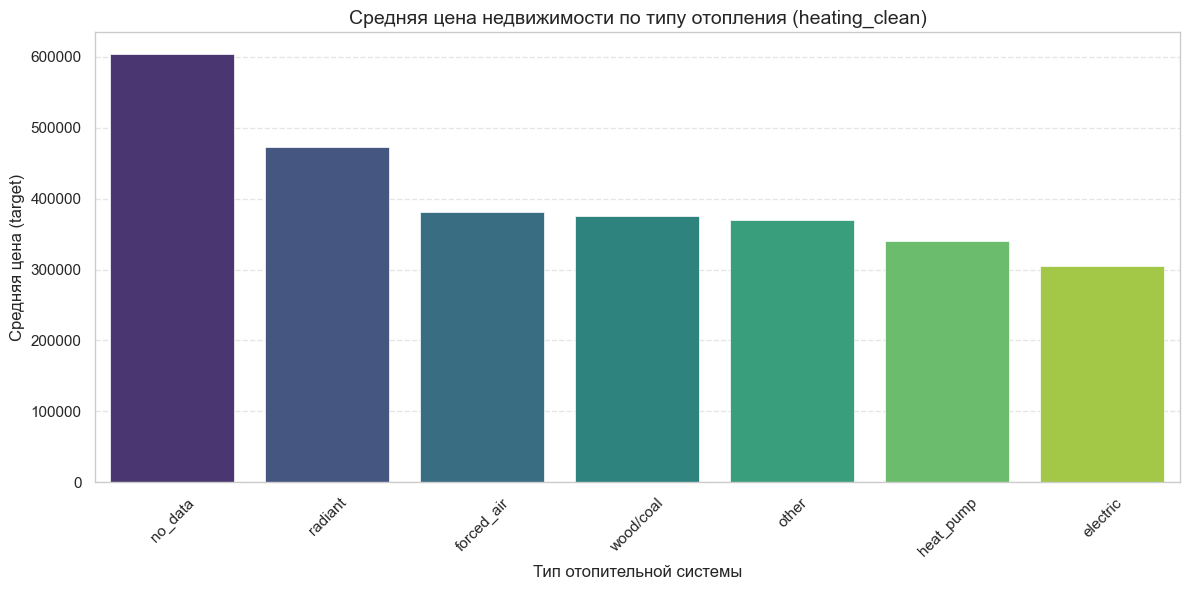

In [230]:

# Группируем по heating_clean и сортируем по убыванию средней цены
grouped_2 = df.groupby('heating_clean')['target'].mean().sort_values(ascending=False)

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_2.index, y=grouped_2.values, palette='viridis')

plt.title('Средняя цена недвижимости по типу отопления (heating_clean)', fontsize=14)
plt.xlabel('Тип отопительной системы', fontsize=12)
plt.ylabel('Средняя цена (target)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


 no_data стало в процентаже меньше, но при этом увеличилась цена. 
 Единственный выход - конвертировать оставшиеся 12% в np.nan - чтобы система не считала это за данные. 
 После решу,что можно сделать с пропущенными. 

проверить гипотезу, что строки с heating_clean == 'no_data' не являются элитным жильём,

In [231]:
# Группировка по heating_clean и street_type
grouped = (
    df.groupby(['heating_clean', 'street_type'])['target']
    .mean()
    .reset_index()
    .pivot(index='heating_clean', columns='street_type', values='target')
)

# Отобразим первые строки
grouped.round().fillna('-')

street_type         aly       ave      blvd       cir        ct        cv  \
heating_clean                                                               
electric       367422.0  321858.0  350037.0  292883.0  293245.0  347257.0   
forced_air     393777.0  402455.0  397854.0  341304.0  371417.0  488652.0   
heat_pump      139000.0  422108.0  364731.0  289506.0  296727.0  343183.0   
no_data        116833.0  652206.0  677852.0  240381.0  388415.0  316486.0   
other          380463.0  410926.0  420996.0  337826.0  336991.0  334532.0   
radiant               -  503128.0  396586.0  440139.0  536791.0         -   
wood/coal             -  529610.0  674450.0  320000.0  557456.0         -   

street_type          dr       hwy        ln      loop  ...      pkwy  \
heating_clean                                          ...             
electric       277910.0  327562.0  291585.0  286406.0  ...  232811.0   
forced_air     352642.0  313818.0  350971.0  349927.0  ...  329754.0   
heat_pump      301609.0  272006.0  306279.0  287336.0  ...  300444.0   
no_data        302737.0  276473.0  298014.0  350349.0  ...  615785.0   
other          308605.0  340777.0  320281.0  352904.0  ...  446189.0   
radiant        359396.0  445929.0  377635.0  616489.0  ...  550726.0   
wood/coal      458208.0  152450.0  325128.0         -  ...         -   

street_type          pl        rd        row       run        st       ter  \
heating_clean                                                                
electric       352703.0  281883.0   429900.0  219756.0  325965.0  358509.0   
forced_air     412504.0  320822.0   615138.0  283547.0  420527.0  400121.0   
heat_pump      394701.0  303019.0   335200.0  284396.0  405569.0  276167.0   
no_data        660288.0  289183.0  1507390.0  246166.0  888126.0  787377.0   
other          475211.0  327550.0   406805.0  304720.0  413924.0  358275.0   
radiant        477561.0  353635.0   896988.0  475000.0  509214.0  578669.0   
wood/coal       62500.0  272706.0          -         -  371007.0  279900.0   

street_type         trl       way      xing  
heating_clean                                
electric       226703.0  312427.0  223936.0  
forced_air     319365.0  392084.0  562674.0  
heat_pump      318388.0  361005.0  668474.0  
no_data        228928.0  315352.0  370578.0  
other          279625.0  361224.0  301202.0  
radiant        387512.0  459156.0         -  
wood/coal      329000.0  429500.0         -  

[7 rows x 21 columns]

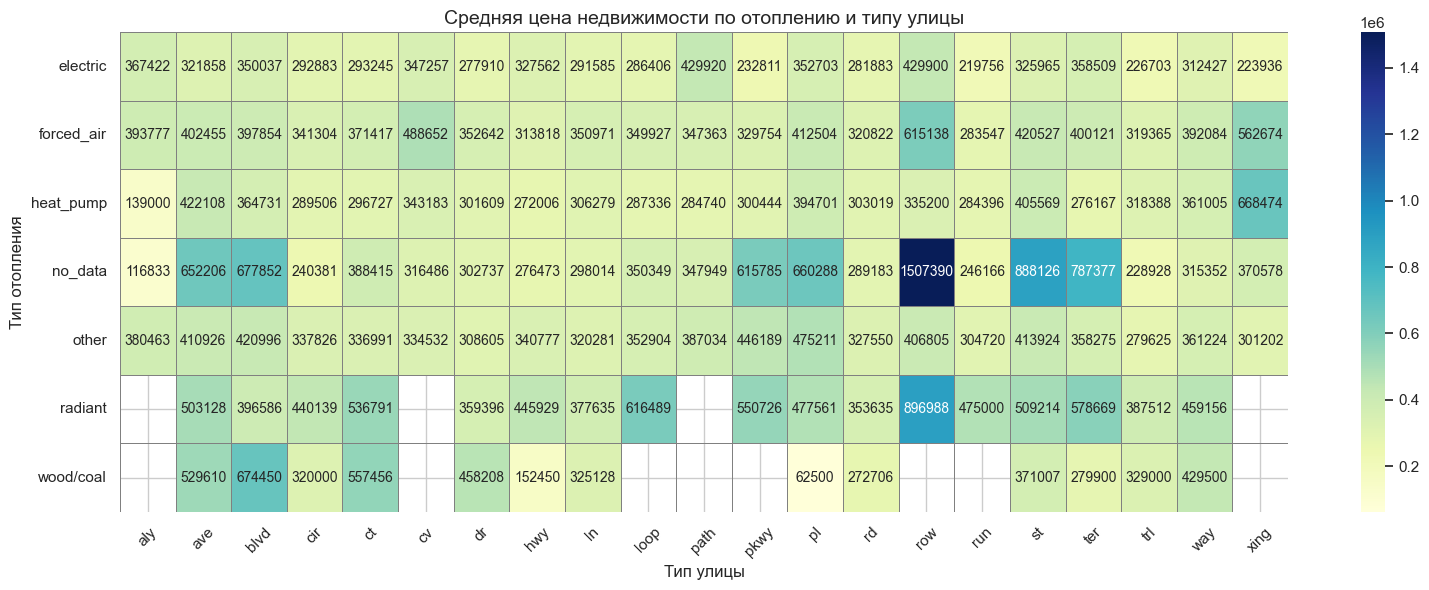

In [232]:
plt.figure(figsize=(16, 6))
sns.heatmap(grouped, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5, linecolor='gray')

# Оформление
plt.title("Средняя цена недвижимости по отоплению и типу улицы", fontsize=14)
plt.xlabel("Тип улицы", fontsize=12)
plt.ylabel("Тип отопления", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Гипотеза   
no_data — это элитные райионы.        
Заменяем no_data  на np.nan.ю но в голове держим, что тут высокие цены.       

In [233]:
df['heating_clean'] = df['heating_clean'].replace('no_data', np.nan)

In [234]:
df['heating_clean'].isna().sum()/len(df)*100

10.512348758887365

In [235]:
df['heating_clean'].unique()

array(['forced_air', nan, 'heat_pump', 'electric', 'other', 'radiant',
       'wood/coal'], dtype=object)

Далее решу,что делать с пропущенными.

In [236]:
df = df.drop('Heating', axis=1)

Помним, что no_data - показывает самые дорогие типы недвижимости на типе улице 'st'.
Выясним, к каким городам это относится. 

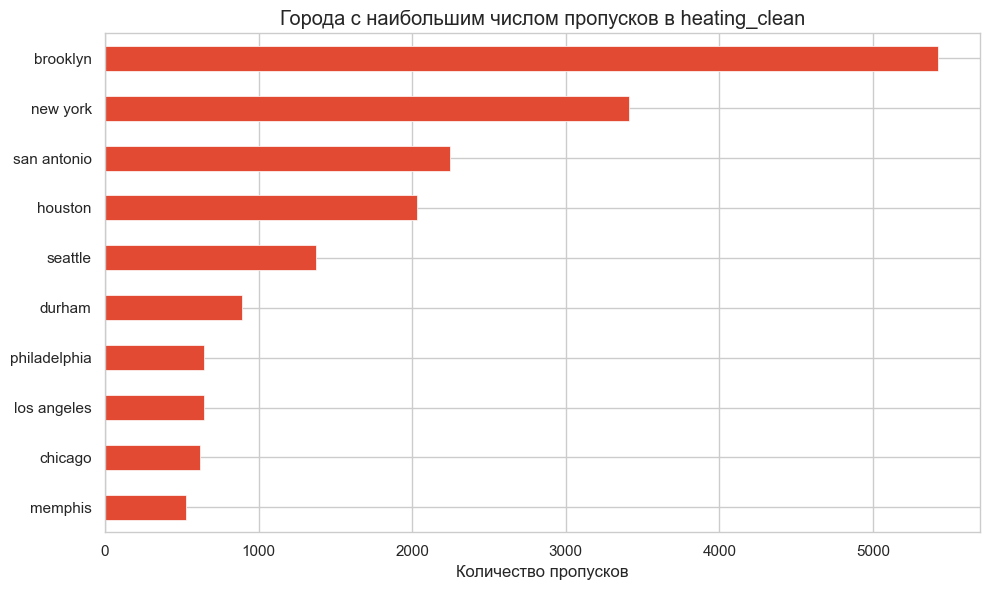

In [237]:
# Убедимся, что 'no data' заменено на NaN
df['heating_clean'] = df['heating_clean'].replace('no data', pd.NA)

# Фильтрация строк с пропущенным отоплением
heating_na = df[df['heating_clean'].isna()]

# Проверим, есть ли такие строки
if heating_na.empty:
    print("Нет строк с пропущенным heating_clean (NaN)")
else:
    # Считаем по городам
    top_cities = heating_na['city'].value_counts().head(10)

    # Визуализация
    top_cities.plot(kind='barh', figsize=(10, 6), title='Города с наибольшим числом пропусков в heating_clean')
    plt.xlabel('Количество пропусков')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



Хорошо,что не удалила строки. Тут много дорогих городов. Скорее всего агентсва прячут инфо. Поэтому не заполнено.

Заполняем модой по зипкоду этих городов

In [238]:
# Список нужных городов
target_cities = [
    'brooklyn', 'new york', 'san antonio',
    'houston', 'seattle', 'durham',
    'philadelphia', 'chicago', 'los angeles', 'memphis'
]

# Приведем названия городов к нижнему регистру
df['city_lower'] = df['city'].astype(str).str.lower()

# Отфильтруем строки, где город входит в список
mask = df['city_lower'].isin(target_cities)

# Заменим 'no data' на NaN на всякий
df['heating_clean'] = df['heating_clean'].replace('no data', pd.NA)

# Группируем по zipcode и берём моду (на случай NaN — пропускаем)
zipcode_mode = (
    df.loc[mask & df['heating_clean'].notna()]
    .groupby('zipcode')['heating_clean']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
)

# Функция для восстановления
def fill_heating(row):
    if (
        pd.isna(row['heating_clean']) and
        row['city_lower'] in target_cities
    ):
        return zipcode_mode.get(row['zipcode'], pd.NA)
    return row['heating_clean']

# Применим
df['heating_clean'] = df.apply(fill_heating, axis=1)

# Удалим временный столбец
df.drop(columns=['city_lower'], inplace=True)


In [239]:
df['heating_clean'].isna().sum()/len(df)*100

5.011537981788699

Лучше, посмотрим,что осталось 

In [240]:
# Сколько строк с 'no data'
no_data_count = (df['heating_clean'] == 'no data').sum()

# Сколько пропущенных значений (NaN)
na_count = df['heating_clean'].isna().sum()

print(f"Строк с 'no data': {no_data_count}")
print(f"Пропущенных значений (NaN): {na_count}")

# Если хочешь, вывести топ-10 городов по 'no data'
print("\nТоп-10 городов с 'no data':")
print(df[df['heating_clean'] == 'no data']['city'].value_counts().head(10))

# Аналогично по NaN
print("\nТоп-10 городов с пропусками (NaN) в heating_clean:")
print(df[df['heating_clean'].isna()]['city'].value_counts().head(10))


Строк с 'no data': 0
Пропущенных значений (NaN): 16071

Топ-10 городов с 'no data':
Series([], Name: city, dtype: int64)

Топ-10 городов с пропусками (NaN) в heating_clean:
panama city beach    504
knoxville            463
indianapolis         445
charlotte            419
tallahassee          393
bronx                366
tampa                354
nashville            319
jamaica              317
asheville            309
Name: city, dtype: int64


В основном южные города, за исключением Бронкса. На юге отопление не важно. 
Но я не хочу удалять строки, просто перепишу эти города в категорию other. 

In [241]:
df['heating_clean'] = df['heating_clean'].fillna('other')


In [242]:
df['heating_clean'].isna().sum()/len(df)*100

0.0

In [243]:
df['heating_clean'].unique()

array(['forced_air', 'heat_pump', 'other', 'electric', 'radiant',
       'wood/coal'], dtype=object)

Столбец heating_clean — номинальный признак, потому для него идеально подходит one-hot encoding (через pd.get_dummies()), потому что:

* Категории не имеют упорядоченности.
* Каждая категория становится отдельным бинарным признаком.
* И их всего 6.

In [244]:
heating_dummies = pd.get_dummies(df['heating_clean'], prefix='heating')
df = pd.concat([df, heating_dummies], axis=1)


df.drop(columns=['heating_clean'], inplace=True)

In [245]:
df.head(3)

status        propertyType                                  street  \
0       1  single family home                          240 Heather Ln   
1       1       single family                    5315 Fayetteville Rd   
2       0  single family home  Armstrong Plan in Cadence at Mint Hill   

       baths                                          homeFacts  fireplace  \
0        3.5  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1          3  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
2  2.5 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   

             city    sqft zipcode    beds  ... Remodeled year  Cooling  \
0  southern pines  2900.0   28387       4  ...                           
1          durham  2375.0   27713       4  ...           None  Central   
2       mint hill  1731.0   28227  2 Beds  ...                           

   Parking     lotsize  heating_electric  heating_forced_air  \
0                 None                 0                   1   
1  No Data  0.36 acres                 0                   1   
2                                      0                   1   

  heating_heat_pump  heating_other  heating_radiant heating_wood/coal  
0                 0              0                0                 0  
1                 0              0                0                 0  
2                 0              0                0                 0  

[3 rows x 42 columns]

### Переходим к столбику df.cooling


Категории  для этого типа климата-контроля бфли несколько раз переделаны мной в силу замусоренности данных.    
НИже видите конечный вариант:     
1. Перенесены слова с типом keyword == 'heat'  и т.д. в столбик Heating    
2. Отфильтрована категория 'other' в столбике cooling - и найдены небольшое количество данных, но по цене дорогие.    
3. После всех манипуляции ниже выведеныы конечные категории столбика cooling_clean    

In [246]:
def simplify_cooling(val):
    if pd.isna(val) or str(val).strip().lower() in ['', 'none', 'no data', 'nan']:
        return 'no_data'

    val = str(val).lower()

    if 'central' in val:
        return 'central'
    elif any(x in val for x in ['window', 'wall', 'split', 'unit', 'mini']):
        return 'unit'
    elif 'heat pump' in val:
        return 'heat_pump'
    elif 'evaporative' in val or 'swamp' in val:
        return 'evaporative'
    elif 'fan' in val:
        return 'fan_only'
    elif 'geothermal' in val:
        return 'geothermal'
    elif 'zoned' in val or 'multizone' in val:
        return 'multi_zone'
    elif 'refrigeration' in val:
        return 'refrigeration'
    elif 'cooling' in val or 'has cooling' in val:
        return 'unclear_cooling'
    elif 'heating' in val or 'heat' in val:
        return 'misclassified_heating'
    else:
        return 'other'
df['cooling_clean'] = df['Cooling'].apply(simplify_cooling)


In [247]:
df['cooling_clean'].value_counts(normalize=True)*100

central            49.400960
no_data            43.920731
unclear_cooling     3.256829
unit                1.581639
other               0.621804
refrigeration       0.476487
evaporative         0.352376
fan_only            0.350505
multi_zone          0.029313
geothermal          0.009355
Name: cooling_clean, dtype: float64

После перенесения строк в heating, в самом столбце cooling увеличился процент в строкеах с  'no data'.      
Посмотрим распределения категории типа охлаждения по цене. Отрисуем соответсвующий график. 

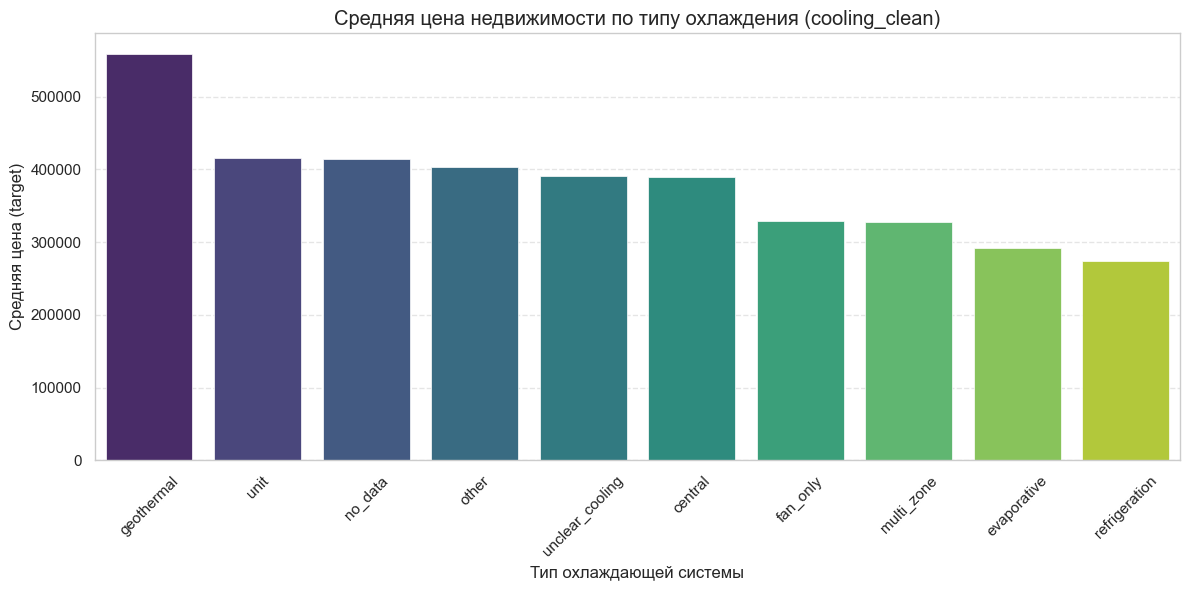

In [248]:
grouped_3 = df.groupby('cooling_clean')['target'].mean().sort_values(ascending=False)
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_3.index, y=grouped_3.values, palette='viridis')

plt.title('Средняя цена недвижимости по типу охлаждения (cooling_clean)')
plt.xlabel('Тип охлаждающей системы')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Видим большую цену при распределении типа  охлаждающей системы в geothermal cooling:

Сноска:     
""Geothermal (геотермальное) охлаждение/отопление использует тепло земли, а точнее:   
под землёй (на глубине 1.5–3 метров) температура круглый год стабильно     
специальный тепловой насос (heat pump) использует подземный контур: летом — охлаждает дом, зимой — обогревает   
Дорого в установкке.""

Да. Может влиять на цену, если это новострой. Глянуть нужно будет в год постройки. если такова будет не пуста. 
Сравним потом при формировании признака год_постройки

Также внимание обращаем на категорию 'no data' - процент в столбце может и высокий заниманет 45%, но п цене видим, что не на первых позициях, значит грруппировка данных сделанат  хорошо. 

В остальном, расрпеделение цены равномерно. 

Заполним пробелы как и в heating_clean столбце через zipcode.

In [249]:
# Частотная таблица: распределение cooling_clean по ZIP
cooling_zip_counts = (
    df[df['cooling_clean'] != 'no_data']
    .groupby('zipcode')['cooling_clean']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

#  Отбираем ZIP-коды, где одна категория охлаждения встречается ≥ 70%
confident_cooling_zip = cooling_zip_counts[cooling_zip_counts.max(axis=1) >= 0.7]

#  Создаём словарь: ZIP → наиболее частая категория
zip_cooling_map = confident_cooling_zip.idxmax(axis=1).to_dict()

#  Функция подстановки
def fill_cooling_from_zip(row):
    if row['cooling_clean'] == 'no_data':
        return zip_cooling_map.get(row['zipcode'], 'no_data')
    return row['cooling_clean']

#  Применение
df['cooling_clean'] = df.apply(fill_cooling_from_zip, axis=1)


In [250]:
df['cooling_clean'].value_counts(normalize=True)*100

central            85.080766
no_data             7.076837
unclear_cooling     3.477610
unit                2.326618
other               0.759012
refrigeration       0.502994
evaporative         0.371086
fan_only            0.366409
multi_zone          0.029313
geothermal          0.009355
Name: cooling_clean, dtype: float64

In [251]:
df['cooling_clean'] = df['cooling_clean'].replace('no_data', np.nan)

In [252]:
df['cooling_clean'].isna().sum()/len(df)*100

7.076836721965822

In [253]:
df = df.drop('Cooling', axis=1)

Осталось 7% неизвестных данных. Потом решу, что с ними делать.

На последок посмотрим распределение по цене.

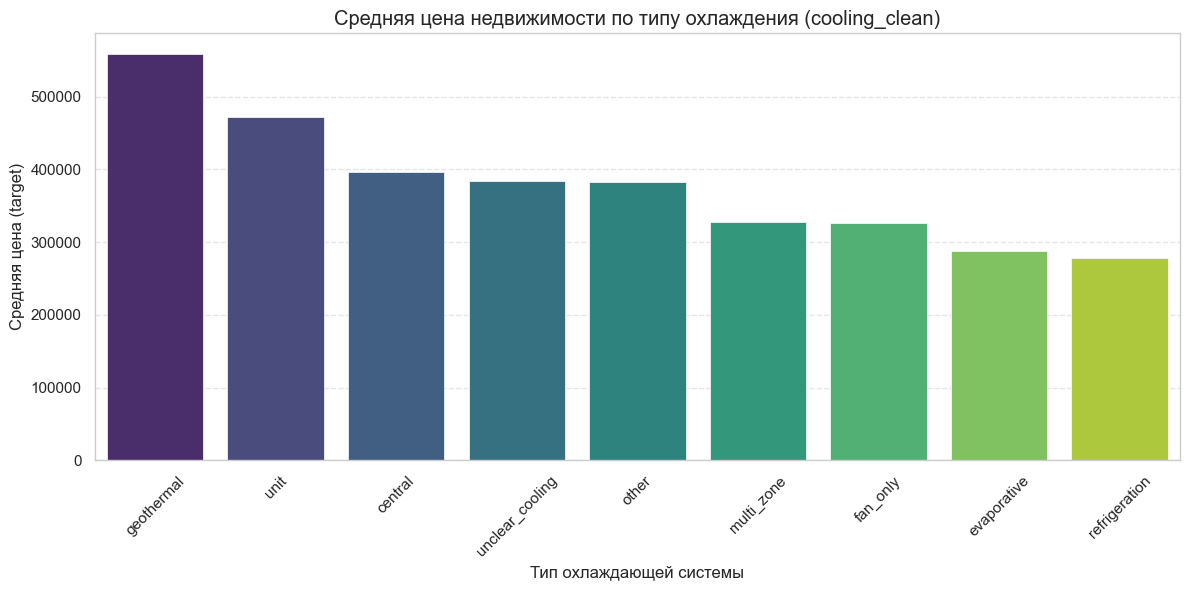

In [254]:
grouped_4 = df.groupby('cooling_clean')['target'].mean().sort_values(ascending=False)
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_4.index, y=grouped_4.values, palette='viridis')

plt.title('Средняя цена недвижимости по типу охлаждения (cooling_clean)')
plt.xlabel('Тип охлаждающей системы')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Распределение сохранилось. Заполнение по зипкоду - правильная стратегия. 

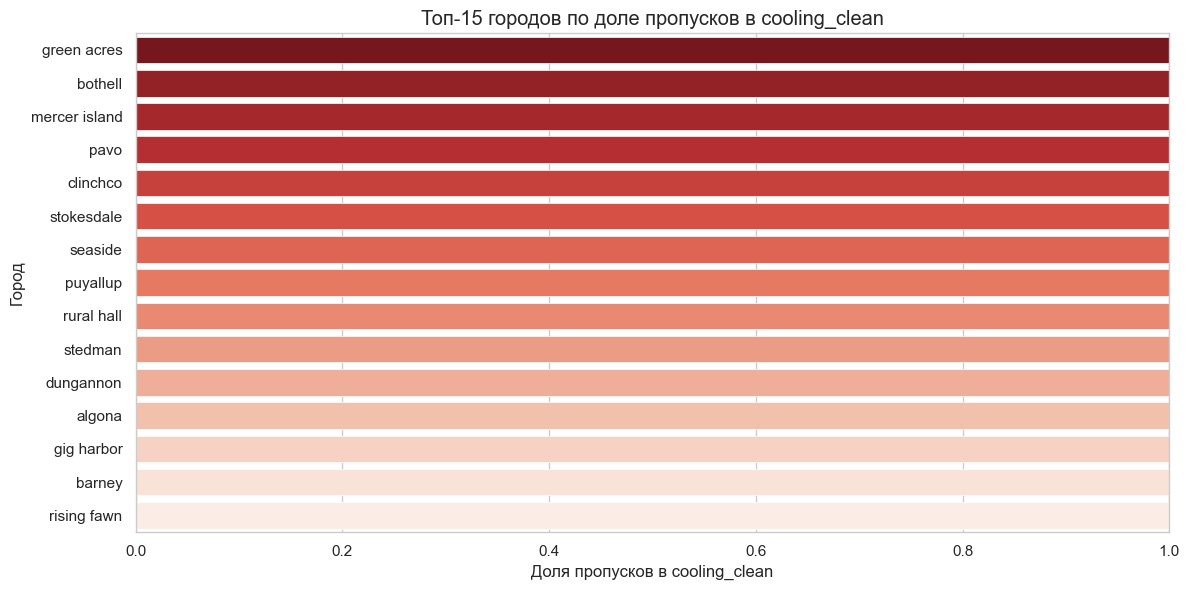

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

# Считаем долю пропусков в cooling_clean по городам
cooling_na_share = (
    df['city']
    .value_counts(normalize=False)
    .rename_axis('city')
    .reset_index(name='total')
    .merge(
        df[df['cooling_clean'].isna()]['city'].value_counts().rename('missing').reset_index().rename(columns={'index': 'city'}),
        on='city',
        how='left'
    )
)

# Заполняем отсутствующие значения нулями (города без пропусков)
cooling_na_share['missing'] = cooling_na_share['missing'].fillna(0)
cooling_na_share['share_missing'] = cooling_na_share['missing'] / cooling_na_share['total']

# Берем топ-15 городов по числу пропусков
top_missing = cooling_na_share.sort_values('share_missing', ascending=False).head(15)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_missing,
    x='share_missing',
    y='city',
    palette='Reds_r'
)
plt.xlabel('Доля пропусков в cooling_clean')
plt.ylabel('Город')
plt.title('Топ-15 городов по доле пропусков в cooling_clean')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


Тут полная сборная солянка. В списке присутствует слишком много разных городов, из разных климатических зон и уровней урбанизации, чтобы строить на этом устойчивые закономерности. Рациональное решение: переведу весь остаток в категорию other

In [256]:
df['cooling_clean'] = df['cooling_clean'].fillna('other')


In [257]:
missing_cooling_counts = (
    df[df['cooling_clean'].isna()]
    .groupby('city')
    .size()
    .sort_values(ascending=False)
)

# Преобразуем в список городов по убыванию количества пропусков
cities_sorted_by_missing = list(missing_cooling_counts.index)

# Вывод
print(cities_sorted_by_missing)


[]


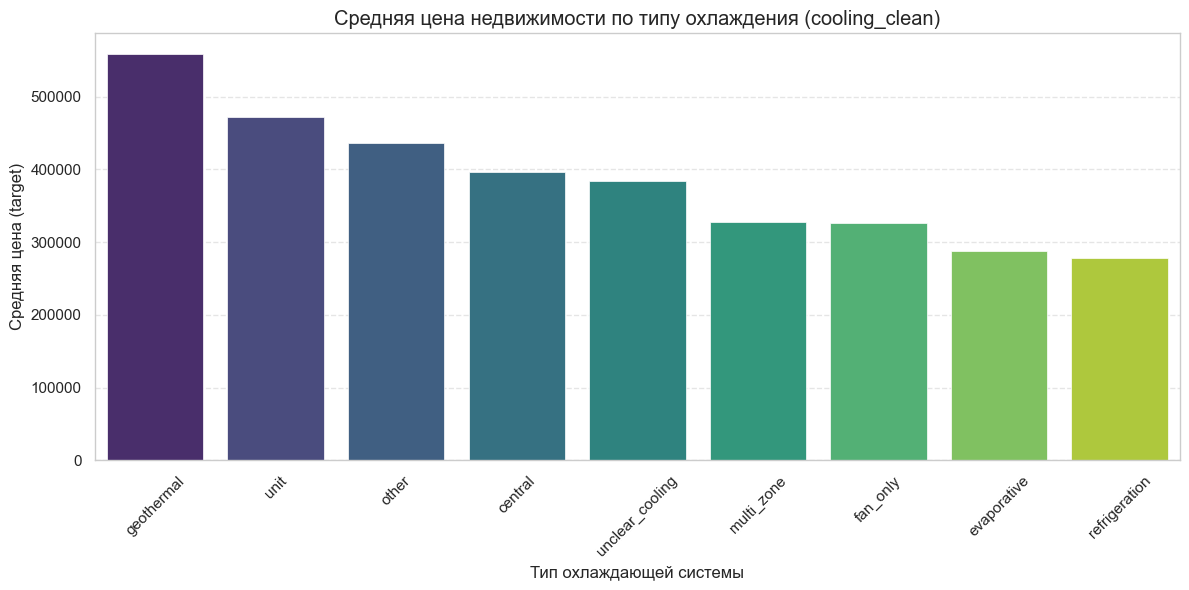

In [258]:
grouped_4 = df.groupby('cooling_clean')['target'].mean().sort_values(ascending=False)
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_4.index, y=grouped_4.values, palette='viridis')

plt.title('Средняя цена недвижимости по типу охлаждения (cooling_clean)')
plt.xlabel('Тип охлаждающей системы')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Сместилась немного цена other на 2 пункта вперед. Видимо в разношорстных городах присутсвуют дорогие типы недвижимости. 

In [259]:
df['cooling_clean'].unique()

array(['other', 'central', 'unit', 'multi_zone', 'evaporative',
       'geothermal', 'refrigeration', 'fan_only', 'unclear_cooling'],
      dtype=object)

Зaкодируем эту колонку как и heating_clean , через pd.get_dummies

In [260]:
# One-Hot Encoding с помощью pd.get_dummies
cooling_dummies = pd.get_dummies(df['cooling_clean'], prefix='cooling')

# Объединяем с исходным DataFrame
df = pd.concat([df, cooling_dummies], axis=1)

# удалчем исходный столбец
df.drop('cooling_clean', axis=1, inplace=True)


In [261]:
df.head(3)

status        propertyType                                  street  \
0       1  single family home                          240 Heather Ln   
1       1       single family                    5315 Fayetteville Rd   
2       0  single family home  Armstrong Plan in Cadence at Mint Hill   

       baths                                          homeFacts  fireplace  \
0        3.5  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1          3  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
2  2.5 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   

             city    sqft zipcode    beds  ... heating_wood/coal  \
0  southern pines  2900.0   28387       4  ...                 0   
1          durham  2375.0   27713       4  ...                 0   
2       mint hill  1731.0   28227  2 Beds  ...                 0   

  cooling_central cooling_evaporative cooling_fan_only  cooling_geothermal  \
0               0                   0                0                   0   
1               1                   0                0                   0   
2               1                   0                0                   0   

   cooling_multi_zone cooling_other  cooling_refrigeration  \
0                   0             1                      0   
1                   0             0                      0   
2                   0             0                      0   

   cooling_unclear_cooling cooling_unit  
0                        0            0  
1                        0            0  
2                        0            0  

[3 rows x 50 columns]

### Переходим к столбику df.Parking

Алгоритм обработки столбца такой же как cooling и heating

In [262]:
# Извлекаем уникальные значения из столбца
unique_values = df['Parking'].unique()

unique_values_list = unique_values.tolist()   

print(unique_values_list)

['', 'No Data', 'Attached Garage', 'Garage - 2 Car', 'Carport', 'Detached Garage', 'Attached Garage, Driveway, Garage - 2 Car, Side Load Garage', 'Off Street', 'Garage - 2 Car, Garage Door Opener', 'Driveway, Parking Space - 2', 'Attached Garage, Driveway, Garage - 3 Car, Garage Door Opener', 'Parking Space - 1, Parking Space - 2', '2 spaces', 'Detached Garage, Driveway, Garage - 1 Car, On-Street Parking', '1 space', '2', '6 spaces', 'Driveway', '4 spaces', 'Attached Garage, Garage - 2 Car', 'Garage - 3 Car, Side Load Garage', 'None', 'Driveway, Garage - 1 Car', 'Attached Garage, Garage - 2 Car, Garage Door Opener', 'Off street', 'Carport, Attached Garage', 'Garage - 3 Car', 'Off Street, On Street', 'Carport - 1 Car', 'Attached Garage, Driveway, Garage - 2 Car, On-Street Parking', 'Off street, Attached Garage', 'Detached Garage, Garage - 2 Car', 'Attached Garage, Driveway, Garage - 2 Car, Garage Door Opener, Side Load Garage', '1 Attached Carport', 'Carport - 1 Car, Parking Space - 3',

In [263]:
df['Parking'].value_counts(normalize=True)*100

                                                                             44.373244
Attached Garage                                                              19.161003
2 spaces                                                                      8.009380
1 space                                                                       4.215678
Detached Garage                                                               3.710938
                                                                               ...    
Driveway, Electric Vehicle Charging Station(s), Garage Door Opener            0.000314
Covered, Driveway, Garage Door Opener, Guest, Off Street, On Street, Open     0.000314
None, Carport                                                                 0.000314
Boat, Driveway, Off Street, Tandem, Workshop in Garage                        0.000314
Attached Garage, Garage - 1 Car, Lot                                          0.000314
Name: Parking, Length: 2877, dtype: float64

In [264]:
def simplify_parking(val):
    if pd.isna(val) or str(val).strip().lower() in ['', 'none', 'no data', '0']:
        return 'no data'
    
    val = str(val).lower()

    if 'garage' in val or 'attached' in val or 'detached' in val:
        return 'garage'
    elif any(x in val for x in ['driveway', 'carport', '2 spaces', '1 space', 'slab', 'pad', 'off street']):
        return 'driveway'
    elif 'street' in val:
        return 'street'
    else:
        return 'other'  # редкие случаи


In [265]:
df['parking_clean'] = df['Parking'].apply(simplify_parking)
print(df['parking_clean'].value_counts(normalize=True) * 100)
print(df['parking_clean'].isna().sum())

no data     49.321130
garage      27.330984
driveway    17.209056
other        5.587813
street       0.551017
Name: parking_clean, dtype: float64
0


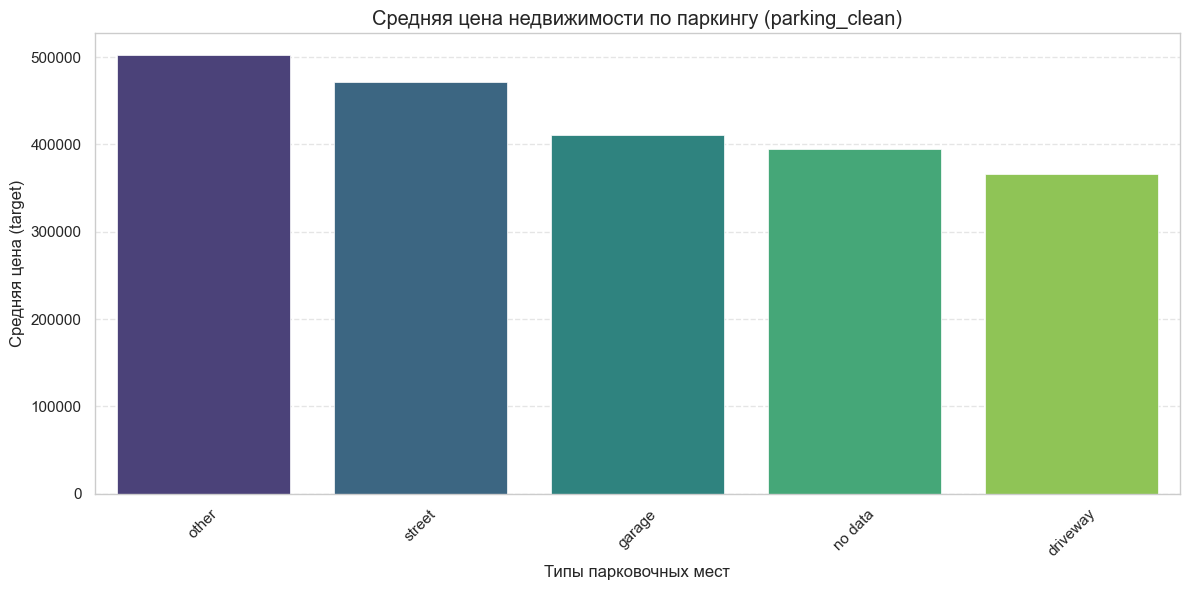

In [266]:
grouped_5 = df.groupby('parking_clean')['target'].mean().sort_values(ascending=False)
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_5.index, y=grouped_5.values, palette='viridis')

plt.title('Средняя цена недвижимости по паркингу (parking_clean)')
plt.xlabel('Типы парковочных мест')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Не правильно распределили группы. Other нужно проверть подробнее.

In [267]:
df[df['parking_clean'] == 'other']['Parking'].value_counts().head(20)


3 spaces                3641
1                       2783
2                       2453
4 spaces                2203
Parking Desc             737
6 spaces                 533
4                        525
Parking Type             425
5 spaces                 417
3                        371
Parking YN               352
6                        185
Electric Door Opener     165
888                      162
8 spaces                 132
5                        126
Assigned                 116
7 spaces                  95
CONCR                     84
ParkingType               80
Name: Parking, dtype: int64

Пример значений	Интерпретация    
'3 spaces', '4 spaces', '6 spaces', '8 spaces', '10 spaces', '1', '2', '3', '4', '5', '6'-	      
Много парковки, часто для больших домов     
'Parking Desc', 'ParkingType', 'Parking YN', '888'	- Мусор    
'Assigned', 'Electric Door Opener'- Детали парковки, а не тип     

Стратегия!!!
1. Создать отдельную категорию: multi_space     
2. Перенести мусор в 'no_data'
3. Оставшееся — в 'other'

In [268]:

def simplify_parking(val):
    if pd.isna(val) or str(val).strip().lower() in ['', 'none', 'no data', '0']:
        return 'no data'

    val = str(val).lower()

    # Мусорные и некорректные значения
    if any(x in val for x in ['desc', 'type', 'yn', '888']):
        return 'no data'

    # Много парковочных мест
    if any(x in val for x in ['spaces', '1', '2', '3', '4', '5', '6', '7', '8', '10']):
        return 'multi_space'

    # Гараж
    elif 'garage' in val or 'attached' in val or 'detached' in val:
        return 'garage'

    # Подъезд/въезд/двор
    elif any(x in val for x in ['driveway', 'carport', 'slab', 'pad', 'off street']):
        return 'driveway'

    # Улица
    elif 'street' in val:
        return 'street'

    # Остальное
    else:
        return 'other'


In [269]:
df['parking_clean'] = df['Parking'].apply(simplify_parking)


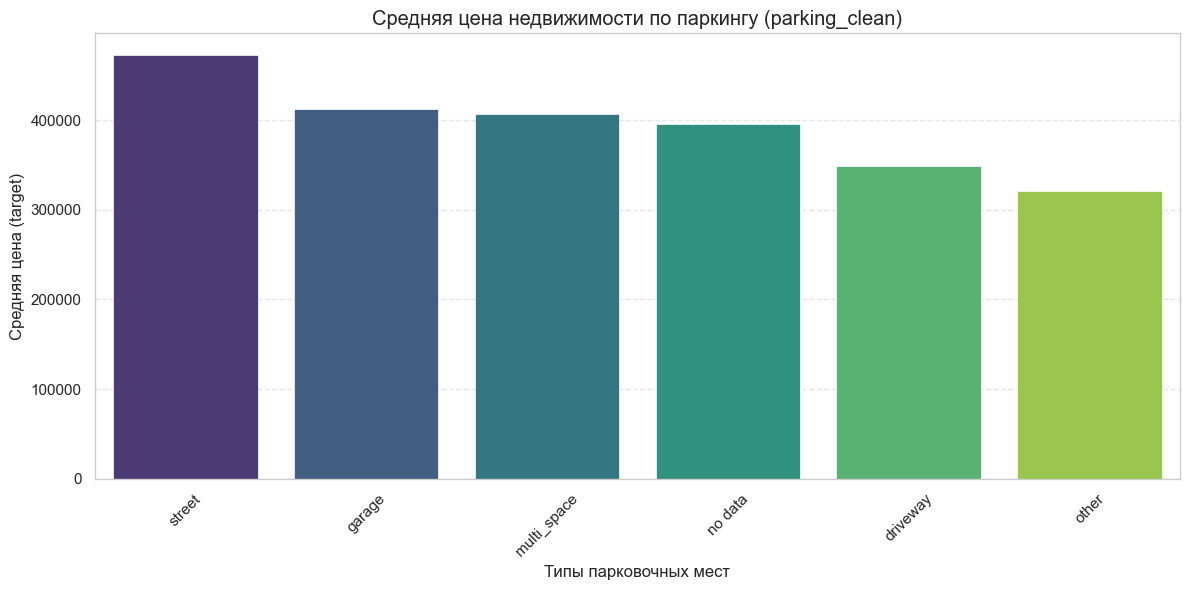

In [270]:
grouped_6 = df.groupby('parking_clean')['target'].mean().sort_values(ascending=False)
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_6.index, y=grouped_6.values, palette='viridis')

plt.title('Средняя цена недвижимости по паркингу (parking_clean)')
plt.xlabel('Типы парковочных мест')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Правильно сгруппировали. Теперь мне нравится расспределение. 
'no data' заполняем как всегда по zipcode

In [271]:
zip_counts = (
    df[df['parking_clean'] != np.nan]
    .groupby('zipcode')['parking_clean']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

zip_counts.head()

parking_clean  driveway  garage  multi_space  no data  other  street
zipcode                                                             
1103                0.0     0.0          0.0      1.0    0.0     0.0
1104                0.1     0.2          0.3      0.4    0.0     0.0
1105                0.0     0.3          0.3      0.4    0.0     0.0
1106                0.0     1.0          0.0      0.0    0.0     0.0
1107                0.0     0.5          0.0      0.5    0.0     0.0

| ZIP    | Распределение                                   | Вывод                                   |
| ------ | ----------------------------------------------- | --------------------------------------- |
| `1106` | `garage = 1.0`                                  | → Однозначно `'garage'`                 |
| `1104` | `garage/driveway/other` по 33%                  | → Сомнительно (не заполняем)           |
| `1108` | `garage = 70%`, `driveway = 20%`, `other = 10%` | → **Уверенно можно ставить `'garage'`** |
| `1105` | `garage = 50%`, `other = 50%`                   | → можно, но не очень надёжно            |


In [272]:
df['parking_clean'] = df['parking_clean'].replace('no data', np.nan)

In [273]:
def fill_parking_by_zip_mode(df, parking_col='parking_clean', zip_col='zipcode', threshold=0.7):
    """
    Заполняет пропуски в столбце parking_col на основе моды по zip_col,
    но только если одна категория парковки встречается в ZIP-коде чаще, чем threshold (по умолчанию 70%).
    
    Возвращает Series с заполненными значениями.
    """
    # Вычисляем распределение категорий парковки по ZIP (без пропущенных)
    parking_dist = (
        df[df[parking_col].notna()]
        .groupby(zip_col)[parking_col]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )

    # Оставляем только ZIP-коды, где одна категория > threshold
    confident_zip = parking_dist[parking_dist.max(axis=1) >= threshold]

    # Определяем для них наиболее частую категорию
    parking_zip_map = confident_zip.idxmax(axis=1).to_dict()

    # Подстановка по ZIP
    def _fill(row):
        if pd.isna(row[parking_col]):
            return parking_zip_map.get(row[zip_col], np.nan)
        return row[parking_col]

    return df.apply(_fill, axis=1)


In [274]:
df['parking_clean'] = fill_parking_by_zip_mode(df)

In [275]:
df['parking_clean'].value_counts(normalize=True)*100

garage         57.697460
multi_space    32.198056
driveway        7.779537
other           1.235296
street          1.089651
Name: parking_clean, dtype: float64

In [276]:
df['parking_clean'].isna().sum()/len(df)*100


35.9813521267307

После заполнения через zipcode - все равно остался большой процент пропущенных значений. 
Потом решу,что с ними делать.

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320680 entries, 0 to 320738
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   status                    320680 non-null  int64   
 1   propertyType              292013 non-null  object  
 2   street                    320426 non-null  object  
 3   baths                     237447 non-null  object  
 4   homeFacts                 320680 non-null  object  
 5   fireplace                 320680 non-null  Int64   
 6   city                      320680 non-null  object  
 7   sqft                      320680 non-null  float64 
 8   zipcode                   320679 non-null  object  
 9   beds                      252150 non-null  object  
 10  state                     320680 non-null  object  
 11  stories                   201645 non-null  object  
 12  mls-id                    22903 non-null   object  
 13  MlsId                     261

### Переходим к столбика df.stories

Я уже провела анализ и нашла те ключи,которые перевести в число. 

In [278]:
unique_values = df['stories'].unique()

unique_values_list = unique_values.tolist()   

print(unique_values_list)

[nan, '0.0', '2.0', '1 Story', '1.0', '2 Story', '1', '1.5 Story/Basement', '2.5 Story', '4.0', 'Split Level', '3.0', '2', '1 Story Basement', '1.5 Story', '2 Story/Basement', 'Split Foyer', '3 Story', '1 Story/F.R.O.G.', '3', '25.0', 'Modular Home', 'Tri-Level', '15.0', '3 Story/Basement', 'Patio Home', '6.0', '24.0', '8.0', '28.0', '4', 'High-Rise', 'Mid-Rise', '4 Story', 'Fourplex', 'Garden', '5.0', 'Co-op', 'Duplex', 'Live/Work', 'Loft', 'Sixplex', 'Triplex', 'Manufactured Doublewide', 'Manufactured Singlewide', '0', '5', '14', '9.0', '9', '11', '12', '6', '33', '27', '8', '19', '17', '7', '13', '34', '24', '15', '41', '40', '39', '20', '23', '25', '27.0', '7.0', '10.0', '12.0', '31.0', '18', '13.0', '19.0', '39.0', '33.0', '21.0', '11.0', '31', '10', 'One Level', 'One', 'Stories/Levels', 'Three Or More', 'Ground Level, One', 'Two', 'Three Or More Levels', ', 1', 'Total Floors in Bldg', '3 Story, Multi Level', 'Multi Level, Three or More', ', 2', '2 Story, Tri Level', 'Two, Multi/S

Грязный и разномастный столбец stories!
Содержит числовые значения, слова, описания, архитектурные стили и даже ошибки.

Цель: Очистить столбик и привести к числу этажей (float или int)



In [279]:
word_to_number = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'ten': 10,
    'eleven': 11,
    'twelve': 12,
    'thirteen': 13,
    'fourteen': 14,
    'fifteen': 15,
    'sixteen': 16,
    'seventeen': 17,
    'eighteen': 18,
    'nineteen': 19,
    'twenty': 20
}

def clean_stories(val):
    if pd.isna(val):
        return np.nan

    val_str = str(val).lower().strip()

    # Удаляем лишние символы: всё кроме букв, цифр, пробелов, точки и дефиса
    val_str = re.sub(r'[^\da-z\s\.\-\/]', '', val_str)

    # Попытка напрямую преобразовать в число
    try:
        num = float(val_str)
        if 0 < num < 100:
            return num
    except:
        pass

    # Поиск явного числа внутри строки
    match = re.search(r'(\d+(\.\d+)?)', val_str)
    if match:
        num = float(match.group(1))
        if 0 < num < 100:
            return num

    # Обработка фраз типа "one and a half"
    if 'one and a half' in val_str or 'one and one half' in val_str:
        return 1.5

    # Поиск слов — строго как отдельные слова
    for word, num in word_to_number.items():
        if re.search(rf'\b{word}\b', val_str):
            return num

    # Условия по ключевым паттернам
    if 'split' in val_str or 'tri-level' in val_str or 'multi' in val_str:
        return 2
    if 'high-rise' in val_str or 'mid-rise' in val_str:
        return 5
    if 'basement' in val_str:
        return 1
    if 'ground level' in val_str or ('ground' in val_str and 'one' in val_str):
        return 1
    if '1.5' in val_str or '1 1/2' in val_str:
        return 1.5
    if '2.5' in val_str:
        return 2.5
    if '3.5' in val_str:
        return 3.5
    if '3+' in val_str:
        return 3
    if '2+' in val_str:
        return 2
    if '1+' in val_str:
        return 1

    # Часто встречающиеся конструкции — вручную
    if 'duplex' in val_str:
        return 2
    if 'townhouse' in val_str or 'condo' in val_str:
        return 2
    if 'fourplex' in val_str or 'triplex' in val_str:
        return 2.5
    if 'sixplex' in val_str:
        return 3
    if 'story, townhouse' in val_str:
        return 2
    if '1 level' in val_str:
        return 1
    if '2 level' in val_str:
        return 2
    if '3 level' in val_str:
        return 3

    return np.nan

# Применяем функцию
df['stories_clean'] = df['stories'].apply(clean_stories)


In [280]:
df['stories_clean'].map(type).value_counts()

<class 'float'>    320680
Name: stories_clean, dtype: int64

In [281]:
print(df['stories_clean'].unique())

[  nan  2.    1.    1.5   2.5   4.    3.   25.   15.    6.   24.    8.
 28.    5.   14.    9.   11.   12.   33.   27.   19.   17.    7.   13.
 34.   41.   40.   39.   20.   23.   10.   31.   18.   21.   56.   36.
 22.   16.   60.    1.2  37.   26.    3.5  29.   43.   54.   63.   46.
 55.   35.   32.   52.   42.   48.   57.   47.   49.   30.    1.3   1.75
 38.   45.    1.7  78.   58.   50.   44.   64.   75.   82.   91.   66.
 77.   70.   62.    2.2 ]


In [282]:
df['stories_clean'].value_counts()


1.0     93763
2.0     72207
3.0     14705
9.0      2852
4.0      2557
        ...  
82.0        1
1.2         1
77.0        1
62.0        1
2.2         1
Name: stories_clean, Length: 75, dtype: int64

Встречаются:

1. целые этажи (1.0, 2.0, 3.0 и т.д.),
2. половинчатые значения (1.5, 2.5, 3.5) — что обычно означает "с мансардой", "с полуподвалом" и т.п.,   
3. редкие дробные вроде 1.2, 1.3, 1.75 — их немного, можно оставить или округлить,   
4. аномальные значения мы уже убрали.    

In [283]:
# округляем до целых:
df['stories_clean'] = df['stories_clean'].round().astype('Int64')  

In [284]:
print(df['stories_clean'].isna().sum())

129753


In [285]:
df['stories_clean'].value_counts(normalize=True)*100


1     49.110917
2      38.54667
3      7.701897
9      1.493765
4      1.340303
        ...    
64     0.001048
50     0.001048
82     0.000524
77     0.000524
62     0.000524
Name: stories_clean, Length: 67, dtype: Float64

In [286]:
df['stories_clean'] = df['stories_clean'].replace(0, np.nan)

In [287]:
df['stories_clean'].map(type).value_counts()

<class 'int'>                            190927
<class 'pandas._libs.missing.NAType'>    129753
Name: stories_clean, dtype: int64

In [288]:
df['stories_clean'].value_counts(normalize=True)*100


1     49.110917
2      38.54667
3      7.701897
9      1.493765
4      1.340303
        ...    
64     0.001048
50     0.001048
82     0.000524
77     0.000524
62     0.000524
Name: stories_clean, Length: 67, dtype: Float64

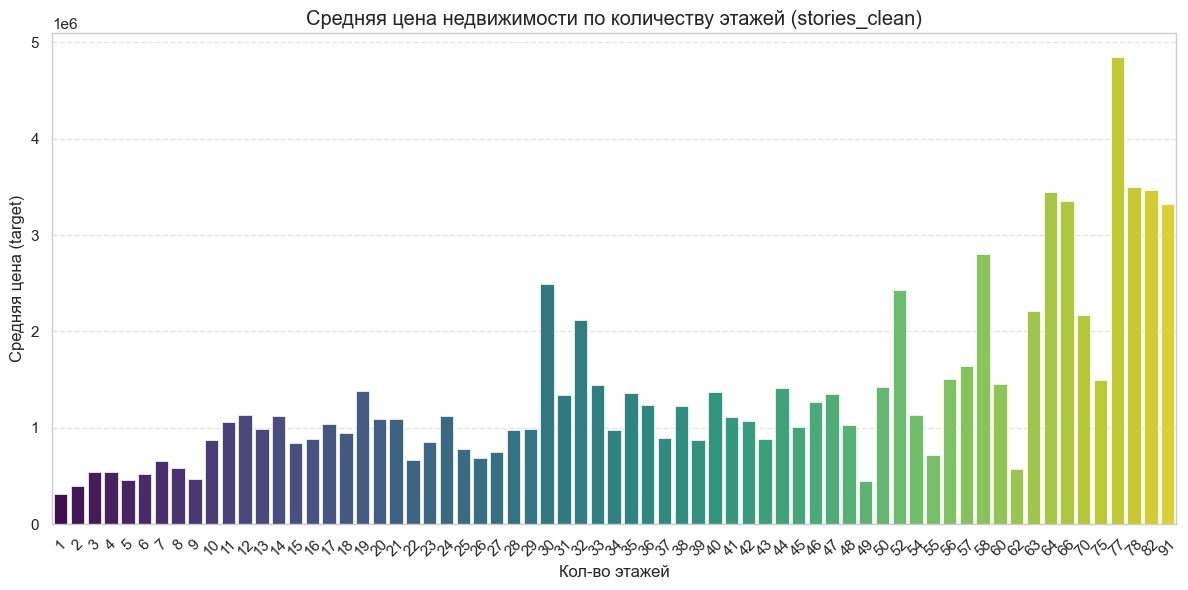

In [289]:
grouped_7 = df.groupby('stories_clean')['target'].mean().sort_values(ascending=False)
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_7.index, y=grouped_7.values, palette='viridis')

plt.title('Средняя цена недвижимости по количеству этажей (stories_clean)')
plt.xlabel('Кол-во этажей')
plt.ylabel('Средняя цена (target)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [290]:
df[df['stories_clean'] > 64]

status propertyType                       street    baths  \
244741       0        condo           146 W 57th St #75C  2 Baths   
245235       0        condo           146 W 57th St #55A  3 Baths   
246672       0        condo          150 W 56th St #4107  2 Baths   
247263       0        condo            53 W 53rd St #23C  2 Baths   
247279       0        condo          150 W 56th St #5906  3 Baths   
247370       0        condo       125 Greenwich Ave #22D  4 Baths   
247529       0        condo            2628 Broadway #5C  2 Baths   
247574       0        condo           157 W 57th St #39E  2 Baths   
247821       0        condo  845 United Nations Plz #11A  3 Baths   
248576       0        condo           111 Murray St #28B  2 Baths   
249246       0        condo       125 Greenwich Ave #20A      NaN   
249638       0        condo          150 W 56th St #3911      NaN   
250043       0        condo  845 United Nations Plz #62D  3 Baths   
250511       0        condo       125 Greenwich Ave #50D  4 Baths   

                                                homeFacts  fireplace  \
244741  {'atAGlanceFacts': [{'factValue': '1986', 'fac...          1   
245235  {'atAGlanceFacts': [{'factValue': '1986', 'fac...          1   
246672  {'atAGlanceFacts': [{'factValue': '1987', 'fac...          1   
247263  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
247279  {'atAGlanceFacts': [{'factValue': '1987', 'fac...          1   
247370  {'atAGlanceFacts': [{'factValue': '2017', 'fac...          1   
247529  {'atAGlanceFacts': [{'factValue': '2006', 'fac...          1   
247574  {'atAGlanceFacts': [{'factValue': '2009', 'fac...          1   
247821  {'atAGlanceFacts': [{'factValue': '2001', 'fac...          1   
248576  {'atAGlanceFacts': [{'factValue': '2018', 'fac...          1   
249246  {'atAGlanceFacts': [{'factValue': '2017', 'fac...          1   
249638  {'atAGlanceFacts': [{'factValue': '1987', 'fac...          1   
250043  {'atAGlanceFacts': [{'factValue': '2001', 'fac...          1   
250511  {'atAGlanceFacts': [{'factValue': '2017', 'fac...          1   

            city    sqft zipcode    beds  ... cooling_evaporative  \
244741  new york  1490.0   10019  2 Beds  ...                   0   
245235  new york  1463.0   10019  2 Beds  ...                   0   
246672  new york   725.0   10019     NaN  ...                   0   
247263  new york  1619.0   10019     NaN  ...                   0   
247279  new york  1188.0   10019  2 Beds  ...                   0   
247370  new york  1932.0   10014  3 Beds  ...                   0   
247529  new york  2006.0   10025  3 Beds  ...                   0   
247574  new york  1351.0   10019     NaN  ...                   0   
247821  new york  1976.0   10017  3 Beds  ...                   0   
248576  new york  1581.0   10007  2 Beds  ...                   0   
249246  new york   878.0   10014     NaN  ...                   0   
249638  new york   530.0   10019     NaN  ...                   0   
250043  new york  1613.0   10017  2 Beds  ...                   0   
250511  new york  1933.0   10014  3 Beds  ...                   0   

       cooling_fan_only cooling_geothermal cooling_multi_zone  cooling_other  \
244741                0                  0                  0              0   
245235                0                  0                  0              0   
246672                0                  0                  0              0   
247263                0                  0                  0              0   
247279                0                  0                  0              0   
247370                0                  0                  0              0   
247529                0                  0                  0              0   
247574                0                  0                  0              0   
247821                0                  0                  0              0   
248576                0                  0             

Ожидаемо ^ большая этажность + высокий чек = элитка Нью Иорка. 



Для адекватного анализа и моделей лучше объединить в группы, например:

* low (1–2 этажа),
* mid (3–6),
* high (7–15),
* very high (16+).



In [291]:
def group_stories(val):
    if pd.isna(val):
        return np.nan
    if val <= 2:
        return 'low'
    elif 3 <= val <= 6:
        return 'mid'
    elif 7 <= val <= 15:
        return 'high'
    elif val > 15:
        return 'very high'
    return np.nan

# Применяем
df['stories_grouped'] = df['stories_clean'].apply(group_stories)


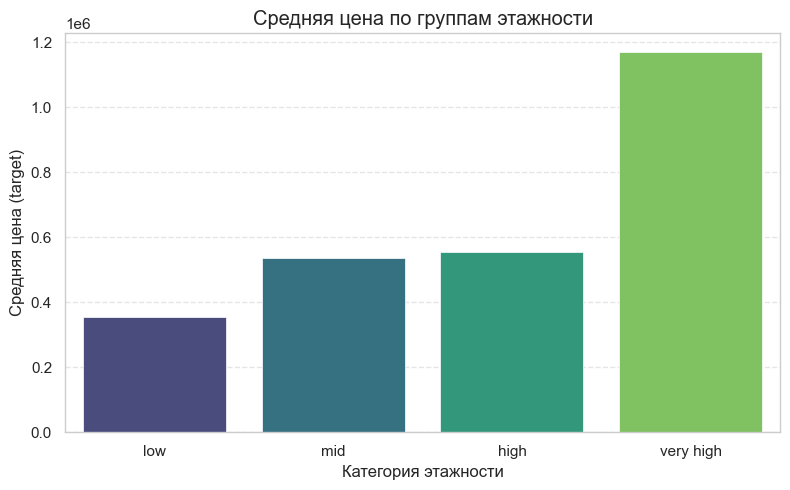

In [292]:

grouped = df.groupby('stories_grouped')['target'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=grouped.index, y=grouped.values, palette='viridis')
plt.title('Средняя цена по группам этажности')
plt.xlabel('Категория этажности')
plt.ylabel('Средняя цена (target)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Выводы:   
Тренд — самые высокие здания - саммые дорогие (кондо, квартиры )     
Самые низкие цены у тех, где мало этажей.    
Средний ценовой сегмент у high и mid .   
Разница между ними почти несущественна, но high все-таки чуточку выше

In [293]:
isna_stories= (df.stories_clean.isna().sum())/len(df)*100
isna_stories

40.461831108893605

Восстановим по зип коду

In [294]:
median_by_zip = (
    df[df['stories_clean'].notna()]
    .groupby('zipcode')['stories_clean']
    .median()
)

def fill_stories_zip(row):
    if pd.isna(row['stories_clean']):
        return median_by_zip.get(row['zipcode'], np.nan)
    return row['stories_clean']

df['stories_clean'] = df.apply(fill_stories_zip, axis=1)

missing_count = df['stories_clean'].isna().sum()
print(f"Количество пропусков в 'stories': {missing_count}")

Количество пропусков в 'stories': 2490


In [295]:
# Восстановим пропуски по медиане
df['stories_clean'] = df['stories_clean'].fillna(df['stories_clean'].median())

missing_count = df['stories_clean'].isna().sum()
print(f"Количество пропусков в 'stories_clean': {missing_count}")


Количество пропусков в 'stories_clean': 0


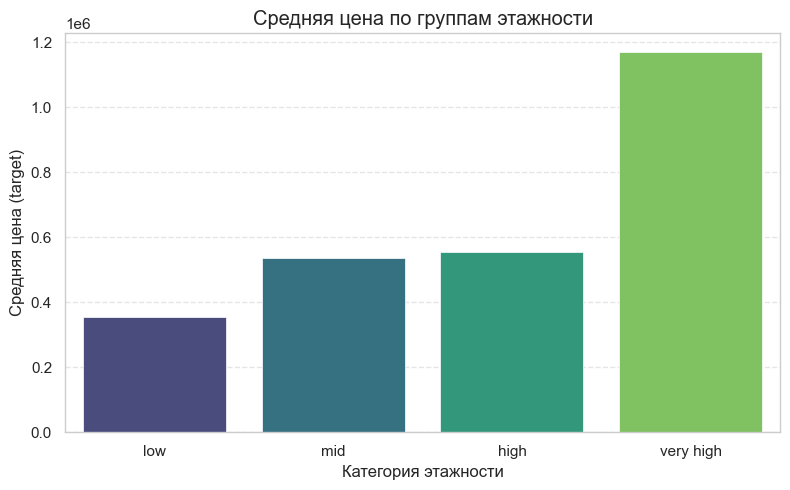

In [296]:
# Смотрим как поменялось расспределение

grouped = df.groupby('stories_grouped')['target'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=grouped.index, y=grouped.values, palette='viridis')
plt.title('Средняя цена по группам этажности')
plt.xlabel('Категория этажности')
plt.ylabel('Средняя цена (target)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

Распределение сохранилось. Значит заполнено правильно 

Группируем числовые значения stories по категориям показаным на визуализации выше.  

In [297]:
def categorize_stories(stories):
    if pd.isna(stories):
        return None  # сохраняем пропуски
    elif stories <= 2:
        return 'low'
    elif 3 <= stories <= 6:
        return 'mid'
    elif 7 <= stories <= 15:
        return 'high'
    else:
        return 'very high'

df['stories_clean'] = df['stories_clean'].apply(categorize_stories)


In [298]:
df.stories_clean.unique()

array(['low', 'mid', 'very high', 'high'], dtype=object)

Закодируем признак через OrdinalEncoder, так как у нас значения имеют градацию и от количества этажей зависит цена, то есть чем выше ,тем дороже объект.

In [299]:
# Определим порядок категорий вручную
category_order = [['low', 'mid', 'high', 'very high']]

encoder = OrdinalEncoder(categories=category_order)

# Преобразуем категориальные значения в числовые
df['stories_encoded'] = encoder.fit_transform(df[['stories_clean']])

Удаляем ненужные столбцы

In [300]:
df = df.drop(['stories', 'stories_clean', 'stories_grouped', 'stories_cat'], axis=1, errors='ignore')


### Переходим к столбику df.lotsize

In [301]:
df.lotsize.unique()

array([None, '0.36 acres', '', ..., '24500', '31798', '103222'],
      dtype=object)

In [302]:
df.lotsize.isna().sum()

23994

In [303]:
df.lotsize.value_counts()

                  29700
—                 22344
No Data            5043
-- sqft lot        3594
0.26 acres         2085
                  ...  
954 acres             1
1,847 sqft lot        1
1523 sqft             1
607 sqft              1
103222                1
Name: lotsize, Length: 32664, dtype: int64

In [304]:
missing_like = ['—', '--', '— ', '-- sqft lot', 'no data', '', '0', '0 sqft', 'nan']
df['lotsize_clean'] = df['lotsize'].str.lower().str.strip()
df['lotsize_clean'] = df['lotsize_clean'].replace(missing_like, np.nan)

In [305]:
print('Пропущено стало:', df['lotsize_clean'].isna().sum())


Пропущено стало: 84675


In [306]:
df.lotsize_clean.value_counts()

0.26 acres       2623
0.28 acres       2203
0.25 acres       2140
0.27 acres       2133
0.29 acres       1909
                 ... 
222923              1
3176                1
2,219 sqft          1
7,946 sq. ft.       1
103222              1
Name: lotsize_clean, Length: 32049, dtype: int64

In [307]:
def convert_lotsize_to_sqft(val):
    if pd.isna(val):
        return np.nan

    val = val.lower().strip()

    # Если указано в акрах
    if 'acre' in val:
        match = re.search(r'([\d\.,]+)', val)
        if match:
            acres = float(match.group(1).replace(',', ''))
            return acres * 43560
        return np.nan

    # Если указано в sqft
    if 'sqft' in val or 'sq. ft' or 'sqft lot ' in val:
        match = re.search(r'([\d\.,]+)', val)
        if match:
            sqft = float(match.group(1).replace(',', ''))
            return sqft
        return np.nan

    return np.nan  # всё остальное отбрасываем


In [308]:
df['lotsize_sqft'] = df['lotsize_clean'].apply(convert_lotsize_to_sqft)


In [309]:
df['lotsize_sqft'].isna().sum()

84675

In [310]:
df.lotsize_sqft.value_counts()

11325.6     2881
10890.0     2798
6098.0      2552
7405.0      2522
12196.8     2415
            ... 
3191.0         1
11360.0        1
11581.0        1
328878.0       1
103222.0       1
Name: lotsize_sqft, Length: 15506, dtype: int64

заполним медианой по зипкоду

In [311]:

# 1. Фильтрация ZIP-кодов с >= 10 записями
zip_valid = df['zipcode'].value_counts()
valid_zips = zip_valid[zip_valid >= 10].index

# 2. Медианы lot size по ZIP-кодам
lot_medians_by_zip = (
    df[df['zipcode'].isin(valid_zips) & df['lotsize_sqft'].notna()]
    .groupby('zipcode')['lotsize_sqft']
    .median()
)

# 3. Медианы lot size по типу недвижимости
lot_medians_by_type = (
    df[df['lotsize_sqft'].notna()]
    .groupby('propertyType_clean')['lotsize_sqft']
    .median()
)

# 4. Функция для заполнения пропусков
def fill_lotsize_smart(row):
    if pd.isna(row['lotsize_sqft']):
        # Пробуем по ZIP
        zip_val = lot_medians_by_zip.get(row['zipcode'], np.nan)
        if not pd.isna(zip_val):
            return zip_val
        # Пробуем по типу недвижимости
        type_val = lot_medians_by_type.get(row['propertyType_clean'], np.nan)
        return type_val
    return row['lotsize_sqft']

# 5. Применяем заполнение
df['lotsize_sqft'] = df.apply(fill_lotsize_smart, axis=1)


In [312]:
df['lotsize_sqft'].isna().sum()

0

In [313]:
df.columns

Index(['status', 'propertyType', 'street', 'baths', 'homeFacts', 'fireplace',
       'city', 'sqft', 'zipcode', 'beds', 'state', 'mls-id', 'MlsId', 'target',
       'beds_clean', 'sqft_category', 'sqft_category_encoded', 'baths_clean',
       'state_full', 'state_0', 'state_1', 'state_2', 'state_3', 'state_4',
       'state_5', 'propertyType_clean', 'mean_rating_schools',
       'median_distance_schools', 'total_num_grades_schools', 'street_type',
       'Year built', 'Remodeled year', 'Parking', 'lotsize',
       'heating_electric', 'heating_forced_air', 'heating_heat_pump',
       'heating_other', 'heating_radiant', 'heating_wood/coal',
       'cooling_central', 'cooling_evaporative', 'cooling_fan_only',
       'cooling_geothermal', 'cooling_multi_zone', 'cooling_other',
       'cooling_refrigeration', 'cooling_unclear_cooling', 'cooling_unit',
       'parking_clean', 'stories_encoded', 'lotsize_clean', 'lotsize_sqft'],
      dtype='object')

Отличная работа, но нам этот столбец в общем нужен больше для восстановления части по типам парковки, так как у нас много пропущенных, вспомним сколько. 


### Возвращаемся к столбику df.parking    
К восстановлению пропущенных значений через lotsize

In [314]:
df['parking_clean'].isna().sum()

115385

Как использовать lotsize_sqft для восстановления parking_clean:     
 Примерная логика (можно адаптировать под свои данные):      
 
| lotsize_sqft       | Предполагаемая парковка | 
|--------------------|-------------------------|
| < 1,500            | street                  |
| 1,500 – 5,000      | other                   |
| 5,000 – 10,000     | driveway                |
| > 10,000           | garage                  |

In [315]:
def infer_parking_from_lotsize(row):
    if pd.isna(row['parking_clean']):
        size = row['lotsize_sqft']
        if pd.isna(size):
            return np.nan  # нет подсказки
        elif size < 1500:
            return 'street'
        elif size < 5000:
            return 'other'
        elif size < 10000:
            return 'driveway'
        else:
            return 'garage'
    return row['parking_clean']  # если уже заполнено

In [316]:
df['parking_clean'] = df.apply(infer_parking_from_lotsize, axis=1)


In [317]:
df['parking_clean'].isna().sum()

0

In [318]:
df['parking_clean'].unique()

array(['multi_space', 'garage', 'driveway', 'other', 'street'],
      dtype=object)

Отлично, вcе заполнено.     
Это номинальный признак и значений мало. Заполню  через pd.get_dummies

In [319]:
parking_dummies = pd.get_dummies(df['parking_clean'], prefix='parking')
df = pd.concat([df, parking_dummies], axis=1)

#Удаялем исходный столбец
df.drop('parking_clean', axis=1, inplace=True)

In [320]:
df.head(3)

status        propertyType                                  street  \
0       1  single family home                          240 Heather Ln   
1       1       single family                    5315 Fayetteville Rd   
2       0  single family home  Armstrong Plan in Cadence at Mint Hill   

       baths                                          homeFacts  fireplace  \
0        3.5  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1          3  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
2  2.5 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   

             city    sqft zipcode    beds  ... cooling_unclear_cooling  \
0  southern pines  2900.0   28387       4  ...                       0   
1          durham  2375.0   27713       4  ...                       0   
2       mint hill  1731.0   28227  2 Beds  ...                       0   

  cooling_unit stories_encoded  lotsize_clean  lotsize_sqft parking_driveway  \
0            0             0.0           None       22216.0                0   
1            0             0.0     0.36 acres       15681.6                0   
2            0             0.0            NaN       20038.0                0   

   parking_garage  parking_multi_space parking_other  parking_street  
0               0                    1             0               0  
1               1                    0             0               0  
2               1                    0             0               0  

[3 rows x 57 columns]

### Возвращаеся к df.lotsize_sqft

Разделение на категории площади участка

In [321]:
#  Создаём категорию lot_size_category в исходном df
df['lot_size_category'] = pd.qcut(
    df['lotsize_sqft'],
    q=4,
    labels=['small', 'medium', 'large', 'very large']
)


Применяем Ordinal Encoding к этой категории

In [322]:
encoder = OrdinalEncoder(categories=[['small', 'medium', 'large', 'very large']])
df['lot_size_encoded'] = encoder.fit_transform(
    df[['lot_size_category']]
).astype(int)

# 4. Проверим результат
print(df[['lotsize_sqft', 'lot_size_category', 'lot_size_encoded']].head())

   lotsize_sqft lot_size_category  lot_size_encoded
0       22216.0        very large                 3
1       15681.6        very large                 3
2       20038.0        very large                 3
3       11761.0        very large                 3
4       13939.2        very large                 3


In [323]:
# 3. Удаляем ненужные колонки
df.drop(columns=['lotsize_sqft', 'lot_size_category'], inplace=True)

# 4. Проверим результат
print(df[['lot_size_encoded']].head())

   lot_size_encoded
0                 3
1                 3
2                 3
3                 3
4                 3


### Переходим к столбику df.year_build    

In [324]:
print(df['Year built'].unique().tolist())

['2019', '', '2018', '2006', '1988', '1979', '1998', '2001', '1910', '1957', '2005', '1920', '1967', '1994', '2008', '1995', '1980', '1981', '2011', '1985', '1951', '2000', '1972', '1960', '2012', '1925', '2004', '1906', '1946', '1956', '1930', '1955', '1996', '1978', '1983', '1929', '1945', '1991', '1968', '2020', '2015', '1986', '1952', '2007', '1940', '1926', '1928', '1977', '1989', '1962', '1939', '2017', '1973', '1966', '1975', '1987', '1992', '1993', '2016', '1990', '1997', '1999', '1965', '2009', '1971', '1947', '1954', '1961', '1959', '1950', '2002', '2003', '1982', '2010', '1921', '1941', '1927', '1936', '1976', '1964', '2013', '2014', '1958', '1948', '1970', '1900', '1922', 'No Data', '1918', '1880', '1942', '1949', '1935', '1963', '1984', '1924', '1923', '1974', '1937', '1953', '1969', '1919', '1931', '1903', '1938', '1912', '1944', '1908', '1905', '1913', '1934', '1911', '1915', '1916', '1881', '1932', '1933', '1917', '1864', None, '1943', '2025', '1891', '1907', '1914', '1

In [325]:
df['Year built'].isna().sum()

1705

In [326]:
def clean_year(val):
    try:
        val_str = str(val).strip()
        # Удалим всё, что не цифры
        val_digits = re.sub(r'[^\d]', '', val_str)

        # Преобразуем в число, если возможно
        if val_digits:
            year = int(val_digits)
            if 1700 <= year <= 2025:
                return year
    except:
        pass
    return np.nan  # всё нераспознаваемое — пропуск

# Применим
df['year_built_clean'] = df['Year built'].apply(clean_year)


In [327]:
df['year_built_clean'].describe()


count    276762.000000
mean       1979.184812
std          33.107602
min        1700.000000
25%        1957.000000
50%        1984.000000
75%        2006.000000
max        2025.000000
Name: year_built_clean, dtype: float64

In [328]:
df['year_built_clean'] = pd.to_datetime(df['Year built'], format='%Y', errors='coerce')


In [329]:
df['year_built_clean'].dtype


dtype('<M8[ns]')

In [330]:
df['year_built_clean'].isna().sum()

43918

Восстановление year_built_clean по ZIP-коду:


In [331]:
# Считаем медиану года по каждому ZIP-коду
median_by_zip = df.groupby('zipcode')['year_built_clean'].median()

# Функция для восстановления
def fill_year_built(row):
    if pd.isna(row['year_built_clean']):
        return median_by_zip.get(row['zipcode'], np.nan)
    return row['year_built_clean']

# Применяем
df['year_built_clean'] = df.apply(fill_year_built, axis=1)

In [332]:
print("Осталось пропущенных:", df['year_built_clean'].isna().sum())


Осталось пропущенных: 7460


Еще остались пропущенные.
Можно залить их медианой по типу недвижки

In [333]:
# Считаем медиану года по типу недвижимости
median_by_type = df.groupby('propertyType_clean')['year_built_clean'].median()

# Восстанавливаем по propertyType_clean
def fill_year_by_type(row):
    if pd.isna(row['year_built_clean']):
        return median_by_type.get(row['propertyType_clean'], np.nan)
    return row['year_built_clean']

# Применяем
df['year_built_clean'] = df.apply(fill_year_by_type, axis=1)


In [334]:
print("Осталось пропущенных:", df['year_built_clean'].isna().sum())


Осталось пропущенных: 0


### Создаем новый столбец - возраст здания. df['building_age']

In [335]:
# Текущий год
current_year = datetime.now().year

# Новый столбец — возраст здания
df['building_age'] = current_year - df['year_built_clean'].dt.year


Смотрим как влияет возраст здание на цену

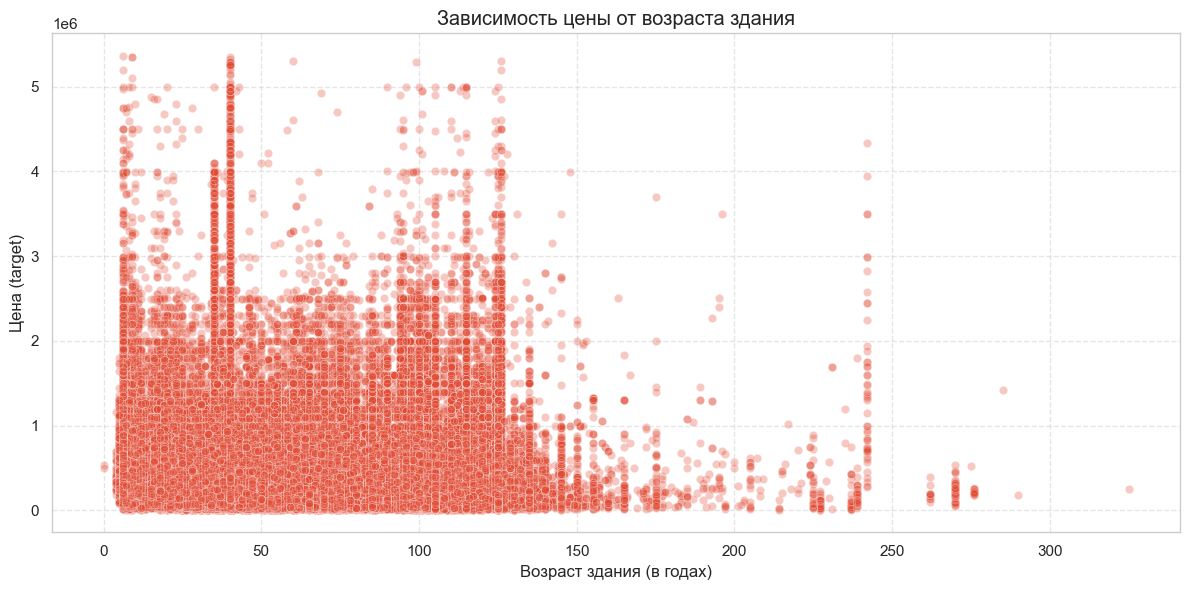

In [336]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='building_age', y='target', alpha=0.3)

plt.title('Зависимость цены от возраста здания')
plt.xlabel('Возраст здания (в годах)')
plt.ylabel('Цена (target)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



до 100 лет зданию видим, что цены приблизительно одинаковые, дальше падают. 

In [337]:
df.head(4)

status        propertyType                                  street  \
0       1  single family home                          240 Heather Ln   
1       1       single family                    5315 Fayetteville Rd   
2       0  single family home  Armstrong Plan in Cadence at Mint Hill   
3       1           craftsman         10043 St. Kitts Landing Ln #89    

       baths                                          homeFacts  fireplace  \
0        3.5  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1          3  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
2  2.5 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
3        NaN  {'atAGlanceFacts': [{'factValue': '2018', 'fac...          1   

             city    sqft zipcode    beds  ... stories_encoded lotsize_clean  \
0  southern pines  2900.0   28387       4  ...             0.0          None   
1          durham  2375.0   27713       4  ...             0.0    0.36 acres   
2       mint hill  1731.0   28227  2 Beds  ...             0.0           NaN   
3       charlotte  2762.0   28278     NaN  ...             0.0           NaN   

  parking_driveway  parking_garage  parking_multi_space parking_other  \
0                0               0                    1             0   
1                0               1                    0             0   
2                0               1                    0             0   
3                0               1                    0             0   

   parking_street  lot_size_encoded year_built_clean  building_age  
0               0                 3       2019-01-01             6  
1               0                 3       2019-01-01             6  
2               0                 3       1986-01-01            39  
3               0                 3       2018-01-01             7  

[4 rows x 59 columns]

Уменьшаем количество годов до нескольких категорий

In [338]:
# Убеждаемся, что возраст — числовой тип
df['building_age'] = pd.to_numeric(df['building_age'], errors='coerce')

# 5. Категоризация возраста
def categorize_age(age) -> str:
    if pd.isna(age):
        return 'unknown'
    if age <= 20:
        return 'new_building'
    elif age <= 50:
        return 'building_21_50_age'
    elif age <= 130:
        return 'building_51_130_age'
    elif age <= 250:
        return 'old_building_131_250_age'
    else:
        return 'too_old'

df['building_age'] = df['building_age'].apply(categorize_age)


In [339]:
df['building_age'].unique()

array(['new_building', 'building_21_50_age', 'building_51_130_age',
       'old_building_131_250_age', 'too_old'], dtype=object)

Закодируем столбец df['building_age'], содержащий категории возраста здания в порядке старения, как порядковую переменную с помощью OrdinalEncoder.

In [340]:
# Упорядочим категории от новых к старым
age_order = [['new_building', 
              'building_21_50_age', 
              'building_51_130_age', 
              'old_building_131_250_age', 
              'too_old']]

encoder = OrdinalEncoder(categories=age_order)

# Преобразуем столбец
df['building_age_encoded'] = encoder.fit_transform(df[['building_age']])


In [341]:
df.head(5)

status        propertyType                                  street  \
0       1  single family home                          240 Heather Ln   
1       1       single family                    5315 Fayetteville Rd   
2       0  single family home  Armstrong Plan in Cadence at Mint Hill   
3       1           craftsman         10043 St. Kitts Landing Ln #89    
4       1                 NaN                   13216 Old Compton Ct    

       baths                                          homeFacts  fireplace  \
0        3.5  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1          3  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
2  2.5 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   
3        NaN  {'atAGlanceFacts': [{'factValue': '2018', 'fac...          1   
4        NaN  {'atAGlanceFacts': [{'factValue': '2006', 'fac...          1   

             city    sqft zipcode    beds  ... lotsize_clean parking_driveway  \
0  southern pines  2900.0   28387       4  ...          None                0   
1          durham  2375.0   27713       4  ...    0.36 acres                0   
2       mint hill  1731.0   28227  2 Beds  ...           NaN                0   
3       charlotte  2762.0   28278     NaN  ...           NaN                0   
4       pineville  2515.0   28134     NaN  ...    0.32 acres                0   

  parking_garage  parking_multi_space  parking_other parking_street  \
0              0                    1              0              0   
1              1                    0              0              0   
2              1                    0              0              0   
3              1                    0              0              0   
4              0                    1              0              0   

   lot_size_encoded  year_built_clean        building_age  \
0                 3        2019-01-01        new_building   
1                 3        2019-01-01        new_building   
2                 3        1986-01-01  building_21_50_age   
3                 3        2018-01-01        new_building   
4                 3        2006-01-01        new_building   

   building_age_encoded  
0                   0.0  
1                   0.0  
2                   1.0  
3                   0.0  
4                   0.0  

[5 rows x 60 columns]

Удаляем ненужные столбцы

In [342]:
df = df.drop(['building_age', 'year_built_clean', 'Year built'], axis=1)

### Возвращаемся к столбцам 'propertType_clean' и 'street_type'
Кодируем столбец propertType_clean с помощью pd.get_dummies

In [343]:
df.street_type.nunique()

21

In [344]:
df = pd.get_dummies(df, columns=['propertyType_clean'], prefix='type_', drop_first=False)

In [345]:
df.head(3)

status        propertyType                                  street  \
0       1  single family home                          240 Heather Ln   
1       1       single family                    5315 Fayetteville Rd   
2       0  single family home  Armstrong Plan in Cadence at Mint Hill   

       baths                                          homeFacts  fireplace  \
0        3.5  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1          3  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
2  2.5 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   

             city    sqft zipcode    beds  ... parking_street  \
0  southern pines  2900.0   28387       4  ...              0   
1          durham  2375.0   27713       4  ...              0   
2       mint hill  1731.0   28227  2 Beds  ...              0   

  lot_size_encoded building_age_encoded  type__apartment  type__house  \
0                3                  0.0                0            0   
1                3                  0.0                0            0   
2                3                  1.0                0            0   

  type__lot  type__mobile manufactured  type__multi family home type__other  \
0         0                          0                        0           0   
1         0                          0                        0           0   
2         0                          0                        0           0   

   type__single family home  
0                         1  
1                         1  
2                         1  

[3 rows x 63 columns]

Удаляем столбец и propertyType из DataFrame df

In [346]:
df = df.drop( 'propertyType', axis=1)

теперь df.street_type. У нас 21 уникальных значений, номинальных. Кодируем через Binary Encoder

In [347]:
# Кодирование street_type с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['street_type'])
df_encoded = encoder.fit_transform(df[['street_type']])

# Добавляем закодированные колонки к исходному df
df = pd.concat([df, df_encoded], axis=1)


In [348]:
df.head(3)

status                                  street      baths  \
0       1                          240 Heather Ln        3.5   
1       1                    5315 Fayetteville Rd          3   
2       0  Armstrong Plan in Cadence at Mint Hill  2.5 Baths   

                                           homeFacts  fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...          1   
2  {'atAGlanceFacts': [{'factValue': '', 'factLab...          1   

             city    sqft zipcode    beds state  ... type__lot  \
0  southern pines  2900.0   28387       4    NC  ...         0   
1          durham  2375.0   27713       4    NC  ...         0   
2       mint hill  1731.0   28227  2 Beds    NC  ...         0   

  type__mobile manufactured  type__multi family home  type__other  \
0                         0                        0            0   
1                         0                        0            0   
2                         0                        0            0   

  type__single family home  street_type_0  street_type_1 street_type_2  \
0                        1              0              0             0   
1                        1              0              0             0   
2                        1              0              0             0   

   street_type_3  street_type_4  
0              0              1  
1              1              0  
2              1              0  

[3 rows x 67 columns]

Удаляем столбец

In [349]:
df = df.drop( 'street_type', axis=1)

### Переходим к столбцам 'mls-id','MlsId' 
Сразу говорю. Я его удаляю. Потому как он уже мне не нужен. 
При предобработки данных, он бы мне раньше помог в выявлении дорогих элитных домов NY и т д,
Этот признак предостререг бы меня от случайношл удаления эти строки за большое количество пропусков. 
Но дойдя до 'mls-id','MlsId'  - я уже сама разобралась. Поэтому удаляю 

In [350]:
df = df.drop(columns=['mls-id', 'MlsId'], errors='ignore')


### Удаляем те столбцы, что больше не нужны. 

In [351]:
df.drop(
    columns=[
        'state',
        'baths',
        'sqft',
        'beds',
        'Remodeled year',
        'city',
        'street',
        'homeFacts',
        'Parking'
    ],
    inplace=True
)


## Мы все предобработали, подчистили, выравнили, преобразили.    
Теперь можно посмотреть что у нас вышло. Удалить ненужные столбцы, посомотреть на количество пропущенных строк и решить как это исправить. 

12,5% строк мы лишились. Допустимо. Идем дальше

 Сначала удаляем ненужные столбцы, которые могли пропустить.

In [352]:
df = df.drop(columns=['zipcode', 'sqft_category', 'state_full', 'lotsize', 'lotsize_clean'])


In [353]:
df.columns

Index(['status', 'fireplace', 'target', 'beds_clean', 'sqft_category_encoded',
       'baths_clean', 'state_0', 'state_1', 'state_2', 'state_3', 'state_4',
       'state_5', 'mean_rating_schools', 'median_distance_schools',
       'total_num_grades_schools', 'heating_electric', 'heating_forced_air',
       'heating_heat_pump', 'heating_other', 'heating_radiant',
       'heating_wood/coal', 'cooling_central', 'cooling_evaporative',
       'cooling_fan_only', 'cooling_geothermal', 'cooling_multi_zone',
       'cooling_other', 'cooling_refrigeration', 'cooling_unclear_cooling',
       'cooling_unit', 'stories_encoded', 'parking_driveway', 'parking_garage',
       'parking_multi_space', 'parking_other', 'parking_street',
       'lot_size_encoded', 'building_age_encoded', 'type__apartment',
       'type__house', 'type__lot', 'type__mobile manufactured',
       'type__multi family home', 'type__other', 'type__single family home',
       'street_type_0', 'street_type_1', 'street_type_2', 'str

Проверяем, остались ли категориальные столбцы

In [354]:
df.describe(include=['object'])


total_num_grades_schools
count                     320680
unique                        11
top                            3
freq                      182682

Да, 2. Исправляю 

In [355]:
df.total_num_grades_schools.unique()

array([8, 3, 5, 6, 7, 1, 2, 0, 4, 9, '9+'], dtype=object)

In [356]:
df['total_num_grades_schools'] = pd.to_numeric(df['total_num_grades_schools'], errors='coerce')
print(df['total_num_grades_schools'].dtypes)  # должно быть float или int
print(df['total_num_grades_schools'].isna().sum())  # сколько NaN появилось после конверсии

float64
7309


In [357]:
df.total_num_grades_schools.unique()

array([ 8.,  3.,  5.,  6.,  7.,  1.,  2.,  0.,  4.,  9., nan])

7309 пропусков из ~320 тысяч — это примерно 2.3% от всего столбца. 
Заполним их значением 10 (то есть «10 и больше») — это простое решение, особенно ,если это верхняя граница

In [358]:
# Заполнить NaN значением 10
df['total_num_grades_schools'] = df['total_num_grades_schools'].fillna(10)

# Все значения больше 10 приравнять к 10
df.loc[df['total_num_grades_schools'] >= 10, 'total_num_grades_schools'] = 10

# Перевести в целые числа
df['total_num_grades_schools'] = df['total_num_grades_schools'].astype(int)


Отлично,проверим столбцы на наличие пропусков. 

In [359]:
missing = df.isna().sum()
missing_columns = missing[missing > 0]

print(missing_columns)

Series([], dtype: int64)


Смотрим на расспределение по цене

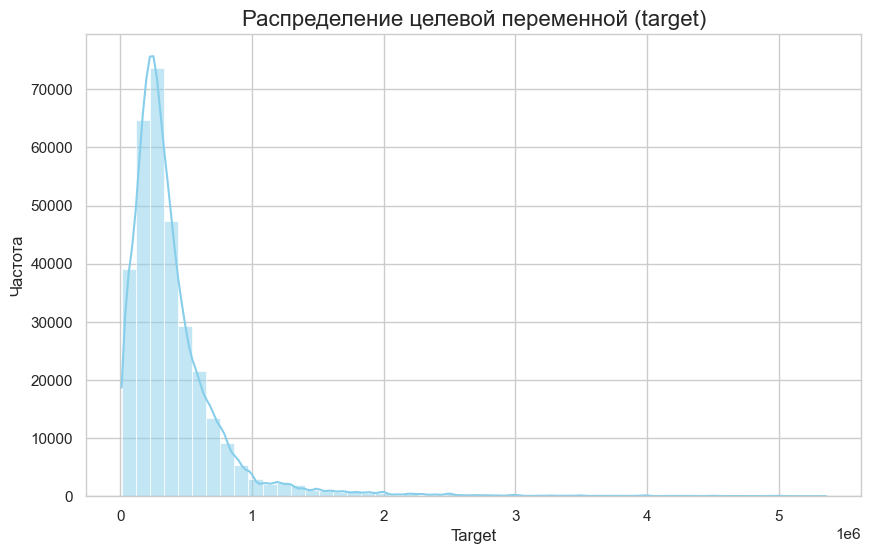

In [360]:
plt.figure(figsize=(10, 6))
sns.histplot(df['target'], bins=50, kde=True, color='skyblue')
plt.title('Распределение целевой переменной (target)', fontsize=16)
plt.xlabel('Target')
plt.ylabel('Частота')
plt.show()


target имеет сильно скошенное распределение вправо.Будем логорифмировать.Затем пройдемся по коррелляционной матрице.
Возьмем по Пирсону, так как распределение у нас непрерывное и после логарифмирования распределение будет нормльным.

In [361]:
df['target_log'] = np.log1p(df['target'])  # безопасно даже если есть нули


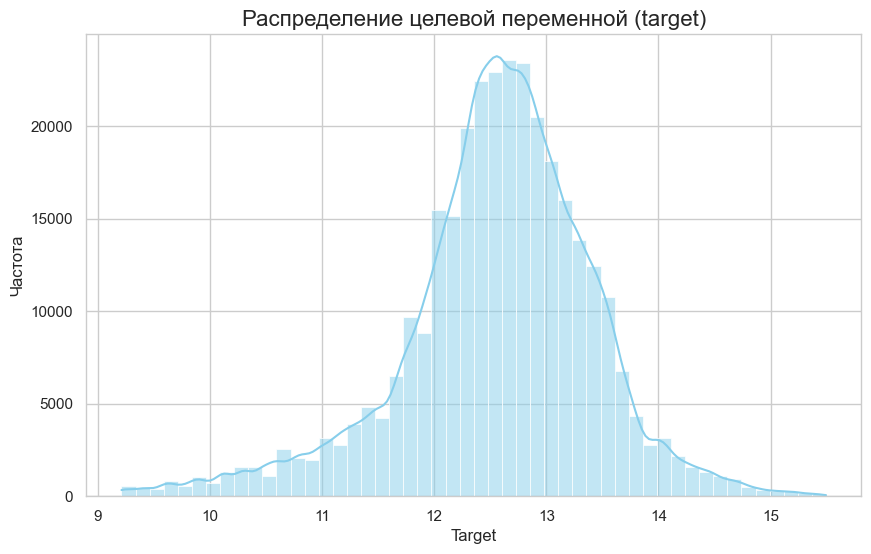

In [362]:
plt.figure(figsize=(10, 6))
sns.histplot(df['target_log'], bins=50, kde=True, color='skyblue')
plt.title('Распределение целевой переменной (target)', fontsize=16)
plt.xlabel('Target')
plt.ylabel('Частота')
plt.show()

Выровняли

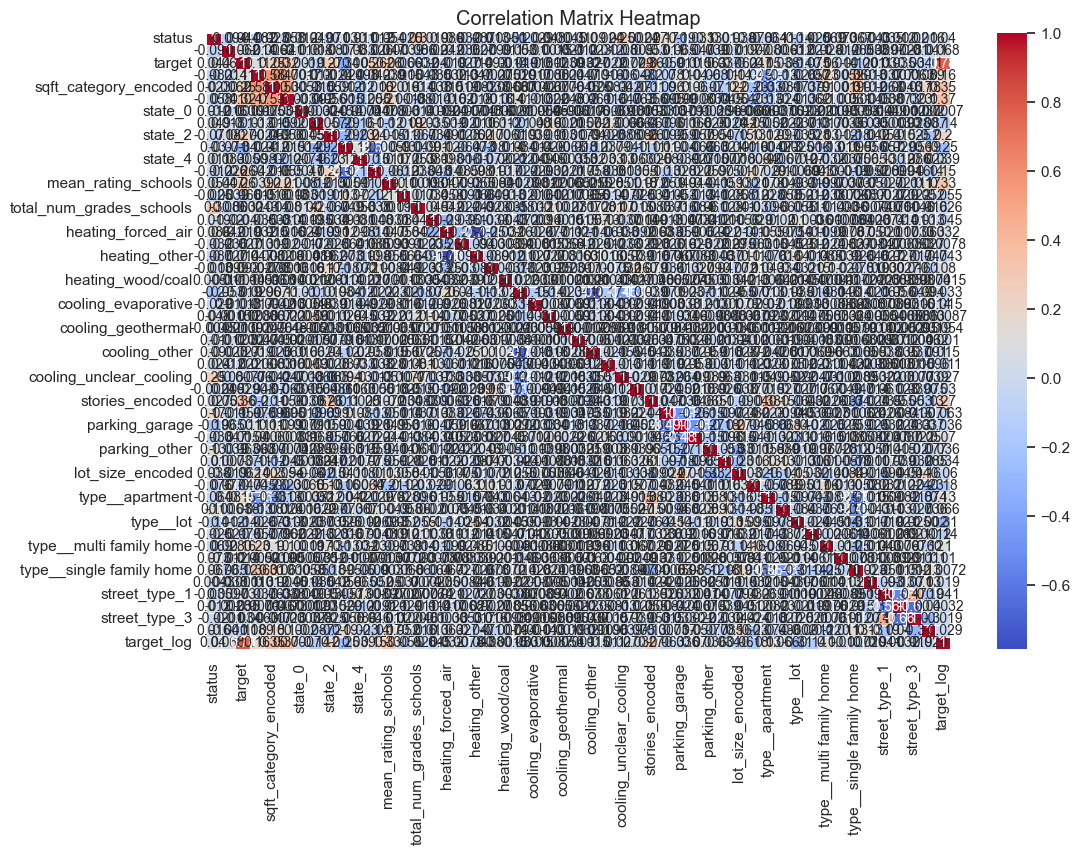

In [363]:
# Строим корреляционную матрицу по всем числовым признакам
corr_matrix = df.corr()

# Строим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [364]:
# Вычисляем матрицу корреляции
corr_matrix = df.corr().abs()  # берем по модулю, чтобы учитывать отрицательные корреляции

# Создаем пустой список для хранения пар с высокой корреляцией
high_corr = []

# Проходим по матрице корреляций, избегая диагональных элементов (где корреляция всегда 1)
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.7:  # если корреляция больше 0.7
            # Сохраняем имена колонок и их коэффициент корреляции
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            high_corr.append((colname1, colname2, corr_matrix.iloc[i, j]))

# Преобразуем результат в DataFrame для удобства
high_corr_df = pd.DataFrame(high_corr, columns=['Feature1', 'Feature2', 'Correlation'])

# Выводим результат
print(high_corr_df)

             Feature1       Feature2  Correlation
0              target     target_log      0.78201
1  heating_forced_air  heating_other      0.78388


У нас слабые корреляции.
Это логично, цена жилья зависит от множества факторов, а линейные корреляции фиксируют только прямые зависимости.
Смотрим корр матрицу по Спирману. Могут быть нелинейные зависимости выйти

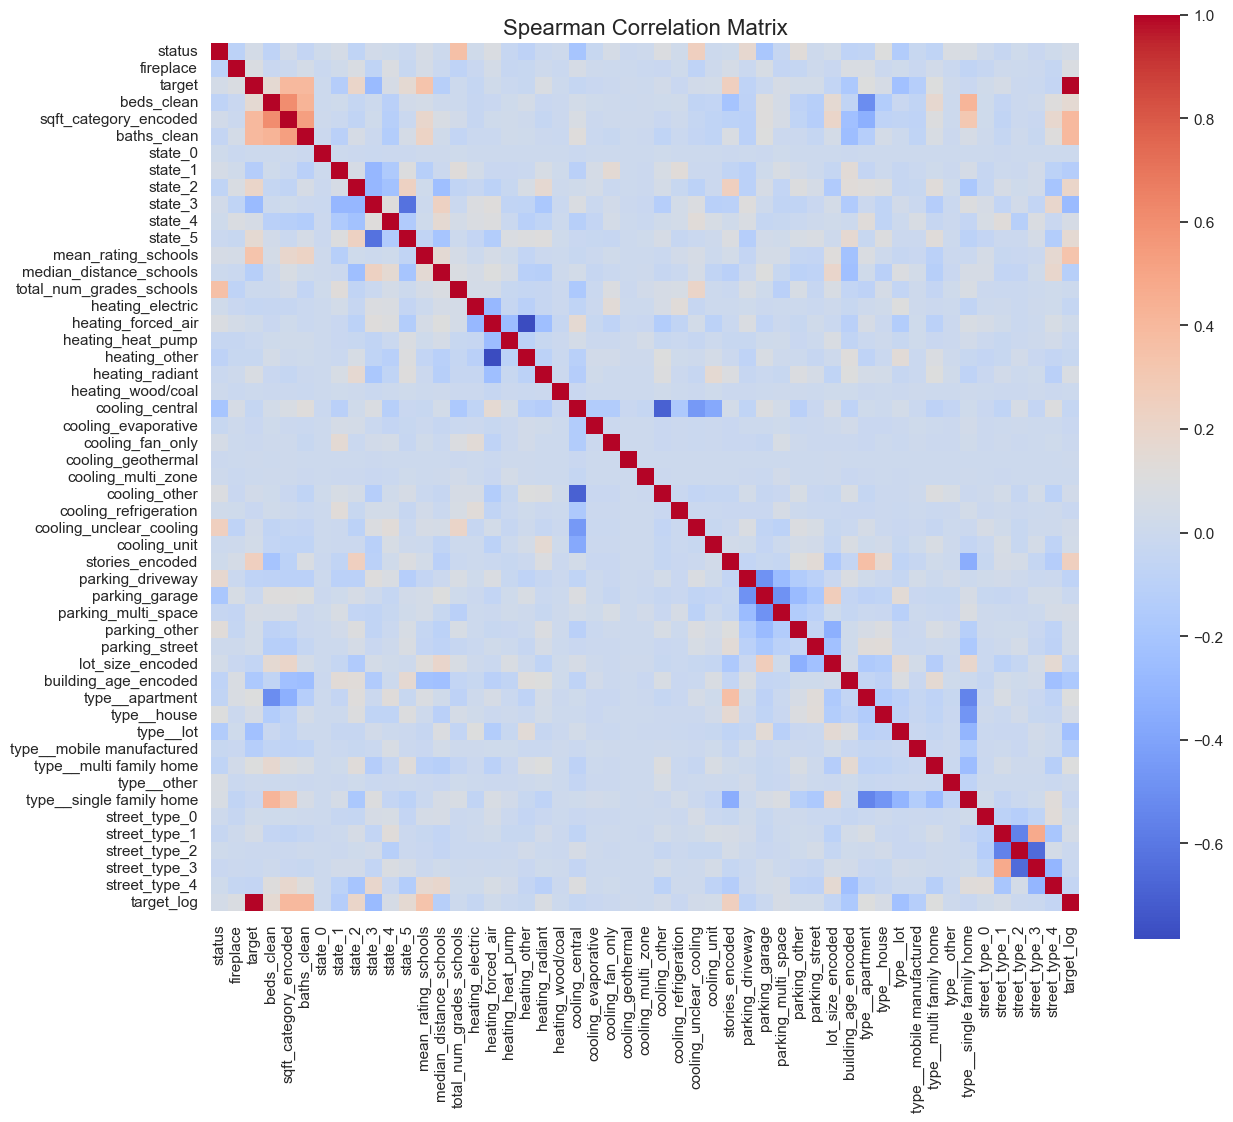

In [365]:

# Расчёт корреляционной матрицы по методу Спирмана
corr_spearman = df.corr(method='spearman')

# Визуализация
plt.figure(figsize=(14, 12))
sns.heatmap(corr_spearman, cmap='coolwarm', annot=False, fmt=".2f", square=True)
plt.title('Spearman Correlation Matrix', fontsize=16)
plt.show()


  То же самое    
Отсутствие сильно коррелированных признаков — это хорошо с точки зрения того, что модель не будет сталкиваться с мультиколлинеарностью.

Нормализовать данные буду по мере необходимости в зависимости от использованной модели.   
Сохраняю фаил.

In [366]:
df.to_csv(r'D:\Skillfactory\MATH_1\cleaned_and_transformed_data.csv', index=False)


### В данном фаиле была проведена следующая работа. 


📥 Загрузка и первичный анализ данных:
* Импорт исходного датасета
* Анализ структуры, объёма и типов признаков;
* Определение наличия пропусков , дубликатов и выбросов.

🧹 Очистка и обработка данных:
* Заполнение или удаление пропусков.
* Обработка выбросов в числовых признаках.
* Очистка строковых категорий.
* Приведение категориальных переменных к единому виду. 

📊 Визуализация данных:
* Гистограммы и boxplot'ы для выявления распределения и выбросов;
* Графики зависимости стоимости от ключевых признаков;
* Визуализация корреляционной матрицы;

🧠 Преобразование признаков:
* Кодирование категориальных переменных (BinaryEncoder, OneHotEncoder);
* Создание новых признаков
* Логарифмирование целевой переменной price.

📊 Отбор признаков:
* Анализ корреляции между признаками;
* Удаление избыточных или неинформативных признаков.